In [50]:
# General Data Cleaning/Stats
import pandas as pd
import numpy as np
import re

from datetime import datetime

# General Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Tree Visualisation
import pydot    # conda install pydoty
from sklearn.tree import export_graphviz
from IPython.display import Image
from dtreeviz.trees import dtreeviz # pip install dtreeviz

In [51]:
# hyperopt - used for Bayesian hyperparameter tuning
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope  # conda install -c conda-forge hyperopt

# for timing
from time import time

In [52]:
sns.set_palette("rocket")
pal = sns.color_palette("rocket")
hex_colors = pal.as_hex()
print(hex_colors)
pal

['#35193e', '#701f57', '#ad1759', '#e13342', '#f37651', '#f6b48f']


[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

## 1. Preparing Data

In [53]:
df_all = pd.read_csv("final_restaurant_rating_data.csv")

In [54]:
# ------------------- Will shift to feature engineering notebook --------------------- #

for idx, row in df_all[df_all['average_rating'].isna()].iterrows():
    df_all.loc[idx, "average_rating_category"] = 0

for idx, row in df_all[df_all['average_daily_operating_hours'].isna()].iterrows():
    df_all.loc[idx, "average_daily_operating_hours"] = 0

for idx, row in df_all[df_all['total_operating_hours'] < 0].iterrows():
    df_all.loc[idx, "total_operating_hours"] = 24 * 7 - row['total_operating_hours']

#### Grouping of Variables (to manage)

In [55]:
target_rating_variable = [
    # 'overall_rating',
    # 'average_rating',
    'average_rating_category',
]

region_ohe = [
    'region_bedok',
    'region_bishan_toa_payoh',
    'region_bugis_city_hall',
    'region_bukit_merah_southern_islands',
    'region_bukit_timah',
    'region_changi',
    'region_downtown',
    'region_geylang',
    'region_kallang',
    'region_marina_bay',
    'region_marina_centre',
    'region_newton_orchard',
    'region_north_region',
    'region_northeast_region',
    'region_novena',
    'region_outram',
    'region_paya_lebar_tampines_pasir_ris',
    'region_queenstown',
    'region_rochor',
    'region_singapore_river',
    'region_tanglin',
    'region_west_region',
]

nearby_attraction_ohe = [
    'nearby_attraction_arab_street',
    'nearby_attraction_boat_quay',
    'nearby_attraction_chinatown',
    'nearby_attraction_east_coast_park',
    'nearby_attraction_garden',
    'nearby_attraction_little_india',
    'nearby_attraction_marina_bay',
    'nearby_attraction_merlion_park',
    'nearby_attraction_museum',
    'nearby_attraction_observation',
    'nearby_attraction_orchard_road',
    'nearby_attraction_wildlife',
    'nearby_attraction_nan',
]

nearby_attraction_feature_cross = [
    'nearby_attraction_arab_street_above_median',
    'nearby_attraction_boat_quay_above_median',
    'nearby_attraction_chinatown_above_median',
    'nearby_attraction_east_coast_park_above_median',
    'nearby_attraction_garden_above_median',
    'nearby_attraction_little_india_above_median',
    'nearby_attraction_marina_bay_above_median',
    'nearby_attraction_merlion_park_above_median',
    'nearby_attraction_museum_above_median',
    'nearby_attraction_observation_above_median',
    'nearby_attraction_orchard_road_above_median',
    'nearby_attraction_wildlife_above_median',
]

meal_ohe = [
    'meal_lunch',
    'meal_dinner',
    'meal_drinks',
    'meal_breakfast',
    'meal_brunch',
    'meal_after_hours',
    'has_meals',
]

cuisine_ohe = [
    'cuisine_arabic',
    'cuisine_asian',
    'cuisine_chinese',
    'cuisine_european',
    'cuisine_indian',
    'cuisine_international',
    'cuisine_italian',
    'cuisine_japanese',
    'cuisine_south_american',
    'cuisine_north_american',
    'cuisine_others',
    'cuisine_sea',
    'has_cuisines',
]

feature_ohe = [
    'feature_delivery',
    'feature_reservations',
    'feature_outdoor_seating',
    'feature_seating',
    'feature_highchairs_available',
    'feature_digital_payments',
    'feature_free_wifi',
    'feature_cash_only',
    'feature_wheelchair_accessible',
    'feature_table_service',
    'feature_live_music',
    'feature_parking_avail',
    'feature_alcohol_avail',
    'feature_creditcard_avail',
    'has_features',    
]

diet_ohe = [
    'diet_vegetarian_friendly',
    'diet_vegan_options',
    'diet_gluten_free_options',
    'diet_halal',    
]

train_station_ohe = [
    'nearest_train_line_color_blue',
    'nearest_train_line_color_green',
    'nearest_train_line_color_others',
    'nearest_train_line_color_purple',
    'nearest_train_line_color_red',
    'nearest_train_line_color_yellow',    
]

price_features=  [
    'has_price_category',
    'price_category',
]

other_features = [
    'average_sentiment_score',
    'img_uploaded_per_review',
    'proportion_of_positive_sentiment',
    'is_travellors_choice',
    'is_michellin',
    'is_in_mall',
    'walking_distance',
    'above_median_dist_from_nearby_attraction'
]

operating_hours_featueres = [
    'total_operating_hours',
    'num_of_days_open',
    'average_daily_operating_hours',
    'operates_on_weekends',
    'operates_on_sat_or_sun',
    'has_operating_hours'
]

In [56]:
dct_feature_category = {}

for col in region_ohe:
    dct_feature_category[col] = "Region OHE"

for col in nearby_attraction_ohe:
    dct_feature_category[col] = "Nearby Attraction OHE"

for col in nearby_attraction_feature_cross:
    dct_feature_category[col] = "Nearby Attraction Feature Cross"

for col in meal_ohe:
    dct_feature_category[col] = "Meal OHE"

for col in cuisine_ohe:
    dct_feature_category[col] = "Cuisine OHE"

for col in feature_ohe:
    dct_feature_category[col] = "Feature OHE"

for col in diet_ohe:
    dct_feature_category[col] = "Diet OHE"

for col in train_station_ohe:
    dct_feature_category[col] = "Nearest Train Station Color OHE"    

for col in train_station_ohe:
    dct_feature_category[col] = "Nearest Train Station Color OHE"    

for col in price_features:
    dct_feature_category[col] = "Price Features"

for col in operating_hours_featueres:
    dct_feature_category[col] = "Operating Hours Features"

for col in other_features:
    dct_feature_category[col] = re.sub("_", " ", col).title()


In [57]:
df = df_all[
    target_rating_variable +
    region_ohe +
    price_features +
    nearby_attraction_ohe +
    nearby_attraction_feature_cross +
    meal_ohe +
    cuisine_ohe +
    feature_ohe +
    diet_ohe +
    train_station_ohe +
    operating_hours_featueres +
    other_features
].copy()

In [58]:
df.shape

(7192, 109)

### Cleaning of Column Dtype

In [59]:
for col in region_ohe + nearby_attraction_ohe + nearby_attraction_feature_cross + cuisine_ohe + train_station_ohe:
    if col in df.columns:
        df[col] = df[col].astype('int64')

In [60]:
np.unique(np.array([df[col].dtype for col in df[target_rating_variable +
                                                region_ohe +
                                                price_features +
                                                nearby_attraction_ohe +
                                                nearby_attraction_feature_cross +
                                                meal_ohe +
                                                cuisine_ohe +
                                                feature_ohe +
                                                diet_ohe +
                                                train_station_ohe
                                                ].columns if col in df.columns]))

array([dtype('int64')], dtype=object)

In [61]:
df['is_in_mall'] = df['is_in_mall'].astype('int64')

In [62]:
print(df[other_features + operating_hours_featueres].dtypes)

average_sentiment_score                     float64
img_uploaded_per_review                     float64
proportion_of_positive_sentiment            float64
is_travellors_choice                          int64
is_michellin                                  int64
is_in_mall                                    int64
walking_distance                            float64
above_median_dist_from_nearby_attraction    float64
total_operating_hours                       float64
num_of_days_open                              int64
average_daily_operating_hours               float64
operates_on_weekends                          int64
operates_on_sat_or_sun                        int64
has_operating_hours                           int64
dtype: object


### Scaling / Normalising
- Not used for Random Forest

In [63]:
from sklearn.preprocessing import StandardScaler

In [64]:
features_to_standardise = [
    'average_sentiment_score',
    'img_uploaded_per_review',
    'proportion_of_positive_sentiment',
    'above_median_dist_from_nearby_attraction',
    'total_operating_hours',
    'average_daily_operating_hours',
    'walking_distance'
]

features_no_need_to_standardise = [col for col in df.columns if col not in features_to_standardise]

In [65]:
df.shape # --> 7191

(7192, 109)

In [66]:
for col in features_to_standardise:
    if col in df.columns:
        print(f"Proportion of Missing Values of {col}:")
        print("{:.2f}%".format(len(df[df[col].isna()]) / len(df) * 100))

Proportion of Missing Values of average_sentiment_score:
0.01%
Proportion of Missing Values of img_uploaded_per_review:
0.01%
Proportion of Missing Values of proportion_of_positive_sentiment:
0.01%
Proportion of Missing Values of above_median_dist_from_nearby_attraction:
0.00%
Proportion of Missing Values of total_operating_hours:
0.00%
Proportion of Missing Values of average_daily_operating_hours:
0.00%
Proportion of Missing Values of walking_distance:
0.00%


In [67]:
# --- Drop NA (for average_sentiment_score)

In [68]:
df['average_sentiment_score'].fillna(0, inplace=True)
df['img_uploaded_per_review'].fillna(0, inplace=True)
df['proportion_of_positive_sentiment'].fillna(0, inplace=True)
df['average_daily_operating_hours'].fillna(0, inplace=True)

In [69]:
# df_scale = df[features_no_need_to_standardise].copy()

# sc = StandardScaler()

# for col in features_to_standardise:
#     scaled_numbers = sc.fit_transform(df[[col]])
#     df_scale[col] = scaled_numbers

# df = df_scale.copy()    

## 2. Initial Model Feature Selection

### Features to Exclude from All Features
- Proportion of Positive Sentiment is excluded because of its close link to Average Sentiment Score
- Average Daily Operating Hours is excluded because of its direct derivation from Total Operating Hours and Number of Days Open

In [70]:
# ------------------- Feature Selection Cell --------------------- #

features_to_exclude = [
    # price features
    # 'has_price_category',
    # 'price_category',

    # other features
    # 'average_sentiment_score',
    # 'img_uploaded_per_review',
    'proportion_of_positive_sentiment',
    # 'is_travellors_choice',
    # 'is_michellin',
    # 'is_in_mall',
    # 'walking_distance',
    # 'above_median_dist_from_nearby_attraction',
    
    # operating hours
    # 'total_operating_hours',
    # 'num_of_days_open',
    'average_daily_operating_hours',
    # 'operates_on_weekends',
    # 'operates_on_sat_or_sun',
    # 'has_operating_hours'
]

# features_to_exclude.extend(region_ohe)
# features_to_exclude.extend(nearby_attraction_ohe)
# features_to_exclude.extend(nearby_attraction_feature_cross)
# features_to_exclude.extend(train_station_ohe)

# features_to_exclude.extend(meal_ohe)
# features_to_exclude.extend(cuisine_ohe)
# features_to_exclude.extend(feature_ohe)
# features_to_exclude.extend(diet_ohe)

In [71]:
df = df.drop(columns=features_to_exclude)

### Separate Test Data (Not used for Modelling)

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
target = ["average_rating_category"]
features = list(df.columns)
features.remove("average_rating_category")

In [74]:
X, X_holdout, y, y_holdout = train_test_split(df[features], 
                                                df[target], 
                                                test_size=0.15, 
                                                random_state=2022, 
                                                shuffle=True, 
                                                stratify=df[target])

In [75]:
X.shape

(6113, 106)

In [76]:
X_holdout.shape

(1079, 106)

## 3. Helper Functions for Modelling

In [77]:
# model learning models
from sklearn.ensemble import RandomForestClassifier

# tools
import pickle

# model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, \
                            ConfusionMatrixDisplay, RocCurveDisplay


### Helper Function to evaluate Model Performance

In [78]:
def evaluate_results(y_test, y_pred, y_proba, plot_confusion_matrix=True, plot_roc=False, title="Classification Results"):
    '''
    This is a helper function that we will call to print basic results statistics.
    '''
    # Create confusion matrix of validation data
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    print("Confusion Matrix:")
    if plot_confusion_matrix:
        disp = ConfusionMatrixDisplay(cm, display_labels=["Poor [0]", "Excellent [1]"])
        disp.plot(cmap=plt.cm.OrRd)
        plt.title(title,pad=5)
        plt.show()
    else:
        print(cm)
    print("TN: %s, FP: %s, FN: %s, TP: %s" %(TN, FP, FN, TP))

    # Evaluation Statistics
    # Performance of decision tree model on validation data
    print("Accuracy: {:.5f}".format(accuracy_score(y_test, y_pred)))
    print("Recall: {:.5f}".format(recall_score(y_test, y_pred)))
    print("Precision: {:.5f}".format(precision_score(y_test, y_pred)))
    print("F1: {:.5f}".format(f1_score(y_test, y_pred)))
    print("ROC_AUC: {:.5f}".format(roc_auc_score(y_test, y_proba)))      # pass in probability
    
    if plot_roc:
        disp = RocCurveDisplay.from_predictions(y_test,y_proba)
        plt.show()

### Helper Function to perform Model Training with Cross Validation

In [79]:
from sklearn.model_selection import StratifiedKFold

In [80]:
def stratified_k_fold_model_fit(X, Y, model, splits=5, shuffle=False, verbose=True, plot_confusion_matrix=True, plot_roc=True, hide_fold_result=False, title=None):
    X = np.array(X)
    Y = np.array(Y)

    if shuffle:
        kf = StratifiedKFold(n_splits=splits, shuffle=shuffle, random_state=2022)
        kf.get_n_splits(X, Y)
    else:
        kf = StratifiedKFold(n_splits=splits, shuffle=shuffle)
        kf.get_n_splits(X, Y)
    
    # ----- Test ----- #
    auc_scores = [] # AUC scores
    all_y_preds = [] # predictions
    all_y_proba = [] # probabilities
    all_y_true = [] # true labels

    # ----- Train ----- #
    train_auc_scores = [] # AUC scores
    train_y_preds = [] # predictions
    train_y_proba = [] # probabilities
    train_true = [] # true labels

    for train, test in kf.split(X, Y):
        # get the current train and test sets (for this particular fold)
        X_train, Y_train = X[train], Y[train]
        X_test, Y_test = X[test], Y[test]
        
        model_fit = model.fit(X_train, Y_train.ravel())

        # predict on training set
        y_pred_train = model_fit.predict(X_train)
        y_proba_train = model_fit.predict_proba(X_train)
        train_y_preds.extend(y_pred_train)
        train_y_proba.extend(y_proba_train[:, 1])
        train_true.extend(Y_train)
        
        # predict on validation set
        # y_pred = model_fit.predict(X_test)
        y_proba = model_fit.predict_proba(X_test)
        y_pred = [1 if y_prob >= 0.5 else 0 for y_prob in y_proba[:, 1]]

        if verbose and not hide_fold_result:
            print('-'*20 + ' Fold Result' + '-'*20)
            evaluate_results(Y_test, y_pred, y_proba[:, 1], plot_confusion_matrix=False, plot_roc=False, title=title)

        all_y_preds.extend(y_pred)
        all_y_proba.extend(y_proba[:, 1])
        all_y_true.extend(Y_test)
    
    # Evaluate results
    if verbose:
        print('-'*20 + ' Overall Train Result' + '-'*20)
        evaluate_results(train_true, train_y_preds, train_y_proba, plot_confusion_matrix=plot_confusion_matrix, plot_roc=plot_roc, title=title)
        print('-'*20 + ' Overall Test Result' + '-'*20)
        evaluate_results(all_y_true, all_y_preds, all_y_proba, plot_confusion_matrix=plot_confusion_matrix, plot_roc=plot_roc, title=title)
        
    return roc_auc_score(train_true, train_y_proba), roc_auc_score(all_y_true, all_y_proba)

### Helper Function to save model performance

In [81]:
# This cell contains helper functions to save tuning results.
if not os.path.exists('Tuning'): os.mkdir('Tuning')
    
def save_file(path, data):
    output = open(path, 'wb')
    pickle.dump(data, output)
    output.close()

def load_file(path):
    pkl_file = open(path, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

## 3. Model Training

### Baseline Model Comparison (Bagging vs Boosting)

In [82]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
#from xgboost import XGBClassifier 

##### Decision Tree

In [ ]:
base_decision_tree = DecisionTreeClassifier(
    max_depth=None,             # default
    criterion="entropy",
)

-------------------- Fold Result--------------------
Confusion Matrix:
[[488 155]
 [129 451]]
TN: 488, FP: 155, FN: 129, TP: 451
Accuracy: 0.76778
Recall: 0.77759
Precision: 0.74422
F1: 0.76054
ROC_AUC: 0.83473
-------------------- Fold Result--------------------
Confusion Matrix:
[[524 119]
 [191 389]]
TN: 524, FP: 119, FN: 191, TP: 389
Accuracy: 0.74652
Recall: 0.67069
Precision: 0.76575
F1: 0.71507
ROC_AUC: 0.81661
-------------------- Fold Result--------------------
Confusion Matrix:
[[508 136]
 [153 426]]
TN: 508, FP: 136, FN: 153, TP: 426
Accuracy: 0.76370
Recall: 0.73575
Precision: 0.75801
F1: 0.74671
ROC_AUC: 0.82258
-------------------- Fold Result--------------------
Confusion Matrix:
[[529 114]
 [195 384]]
TN: 529, FP: 114, FN: 195, TP: 384
Accuracy: 0.74714
Recall: 0.66321
Precision: 0.77108
F1: 0.71309
ROC_AUC: 0.80713
-------------------- Fold Result--------------------
Confusion Matrix:
[[529 114]
 [178 401]]
TN: 529, FP: 114, FN: 178, TP: 401
Accuracy: 0.76105
Recall: 0

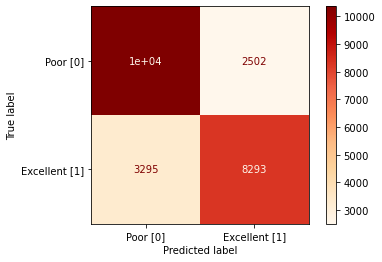

TN: 10362, FP: 2502, FN: 3295, TP: 8293
Accuracy: 0.76292
Recall: 0.71565
Precision: 0.76823
F1: 0.74101
ROC_AUC: 0.83522


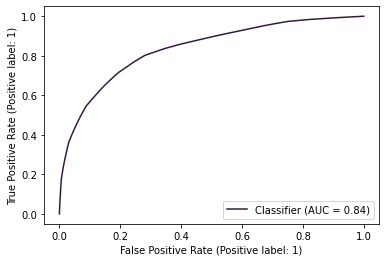

-------------------- Overall Test Result--------------------
Confusion Matrix:


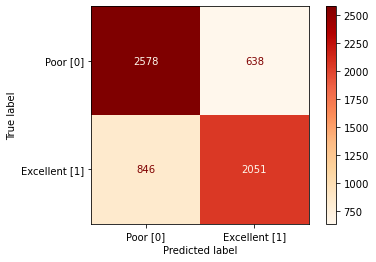

TN: 2578, FP: 638, FN: 846, TP: 2051
Accuracy: 0.75724
Recall: 0.70797
Precision: 0.76274
F1: 0.73434
ROC_AUC: 0.82331


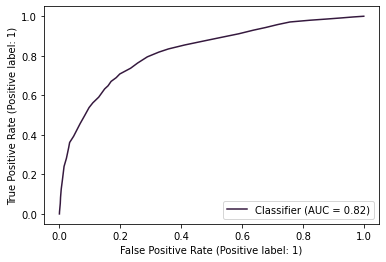

-------------------- Fold Result--------------------
Confusion Matrix:
[[471 172]
 [110 470]]
TN: 471, FP: 172, FN: 110, TP: 470
Accuracy: 0.76942
Recall: 0.81034
Precision: 0.73209
F1: 0.76923
ROC_AUC: 0.85219
-------------------- Fold Result--------------------
Confusion Matrix:
[[477 166]
 [147 433]]
TN: 477, FP: 166, FN: 147, TP: 433
Accuracy: 0.74407
Recall: 0.74655
Precision: 0.72287
F1: 0.73452
ROC_AUC: 0.83306
-------------------- Fold Result--------------------
Confusion Matrix:
[[545  99]
 [198 381]]
TN: 545, FP: 99, FN: 198, TP: 381
Accuracy: 0.75715
Recall: 0.65803
Precision: 0.79375
F1: 0.71955
ROC_AUC: 0.83803
-------------------- Fold Result--------------------
Confusion Matrix:
[[496 147]
 [160 419]]
TN: 496, FP: 147, FN: 160, TP: 419
Accuracy: 0.74877
Recall: 0.72366
Precision: 0.74028
F1: 0.73188
ROC_AUC: 0.82015
-------------------- Fold Result--------------------
Confusion Matrix:
[[538 105]
 [192 387]]
TN: 538, FP: 105, FN: 192, TP: 387
Accuracy: 0.75696
Recall: 0.

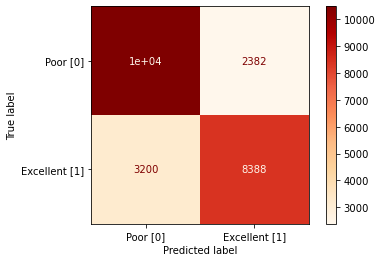

TN: 10482, FP: 2382, FN: 3200, TP: 8388
Accuracy: 0.77172
Recall: 0.72385
Precision: 0.77883
F1: 0.75034
ROC_AUC: 0.85036


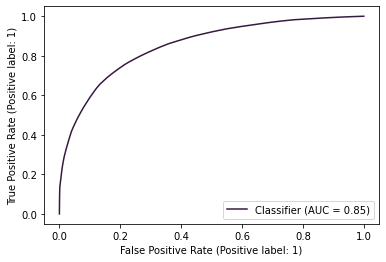

-------------------- Overall Test Result--------------------
Confusion Matrix:


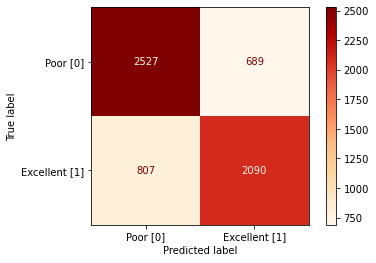

TN: 2527, FP: 689, FN: 807, TP: 2090
Accuracy: 0.75528
Recall: 0.72144
Precision: 0.75207
F1: 0.73643
ROC_AUC: 0.83847


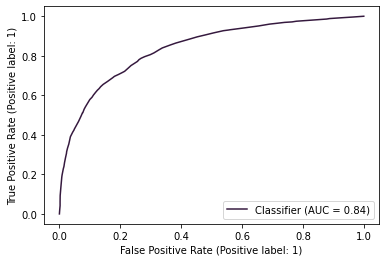

-------------------- Fold Result--------------------
Confusion Matrix:
[[515 128]
 [143 437]]
TN: 515, FP: 128, FN: 143, TP: 437
Accuracy: 0.77841
Recall: 0.75345
Precision: 0.77345
F1: 0.76332
ROC_AUC: 0.85630
-------------------- Fold Result--------------------
Confusion Matrix:
[[477 166]
 [127 453]]
TN: 477, FP: 166, FN: 127, TP: 453
Accuracy: 0.76043
Recall: 0.78103
Precision: 0.73183
F1: 0.75563
ROC_AUC: 0.83525
-------------------- Fold Result--------------------
Confusion Matrix:
[[534 110]
 [190 389]]
TN: 534, FP: 110, FN: 190, TP: 389
Accuracy: 0.75470
Recall: 0.67185
Precision: 0.77956
F1: 0.72171
ROC_AUC: 0.83046
-------------------- Fold Result--------------------
Confusion Matrix:
[[531 112]
 [200 379]]
TN: 531, FP: 112, FN: 200, TP: 379
Accuracy: 0.74468
Recall: 0.65458
Precision: 0.77189
F1: 0.70841
ROC_AUC: 0.82342
-------------------- Fold Result--------------------
Confusion Matrix:
[[511 132]
 [155 424]]
TN: 511, FP: 132, FN: 155, TP: 424
Accuracy: 0.76514
Recall: 0

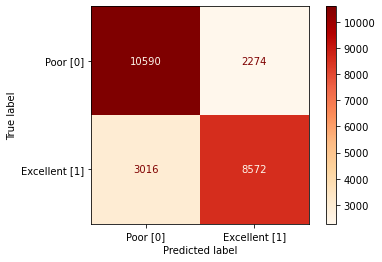

TN: 10590, FP: 2274, FN: 3016, TP: 8572
Accuracy: 0.78366
Recall: 0.73973
Precision: 0.79034
F1: 0.76420
ROC_AUC: 0.86355


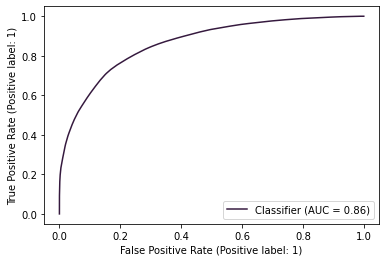

-------------------- Overall Test Result--------------------
Confusion Matrix:


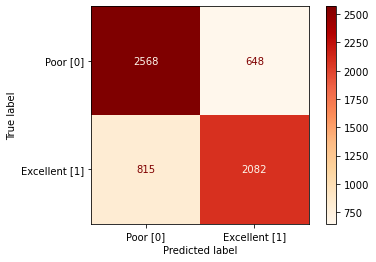

TN: 2568, FP: 648, FN: 815, TP: 2082
Accuracy: 0.76067
Recall: 0.71867
Precision: 0.76264
F1: 0.74000
ROC_AUC: 0.83636


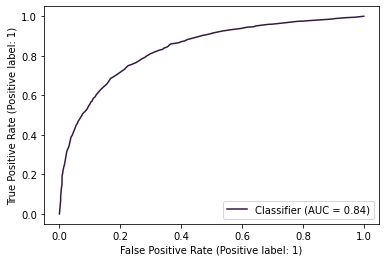

-------------------- Fold Result--------------------
Confusion Matrix:
[[503 140]
 [124 456]]
TN: 503, FP: 140, FN: 124, TP: 456
Accuracy: 0.78414
Recall: 0.78621
Precision: 0.76510
F1: 0.77551
ROC_AUC: 0.84386
-------------------- Fold Result--------------------
Confusion Matrix:
[[472 171]
 [152 428]]
TN: 472, FP: 171, FN: 152, TP: 428
Accuracy: 0.73590
Recall: 0.73793
Precision: 0.71452
F1: 0.72604
ROC_AUC: 0.83196
-------------------- Fold Result--------------------
Confusion Matrix:
[[533 111]
 [181 398]]
TN: 533, FP: 111, FN: 181, TP: 398
Accuracy: 0.76124
Recall: 0.68739
Precision: 0.78193
F1: 0.73162
ROC_AUC: 0.82792
-------------------- Fold Result--------------------
Confusion Matrix:
[[471 172]
 [149 430]]
TN: 471, FP: 172, FN: 149, TP: 430
Accuracy: 0.73732
Recall: 0.74266
Precision: 0.71429
F1: 0.72820
ROC_AUC: 0.80853
-------------------- Fold Result--------------------
Confusion Matrix:
[[509 134]
 [159 420]]
TN: 509, FP: 134, FN: 159, TP: 420
Accuracy: 0.76023
Recall: 0

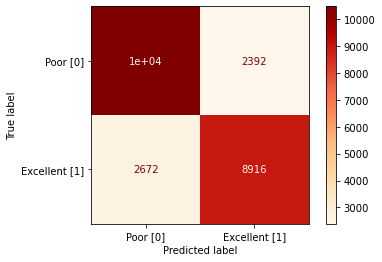

TN: 10472, FP: 2392, FN: 2672, TP: 8916
Accuracy: 0.79290
Recall: 0.76942
Precision: 0.78847
F1: 0.77883
ROC_AUC: 0.87739


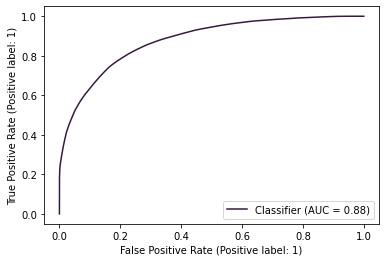

-------------------- Overall Test Result--------------------
Confusion Matrix:


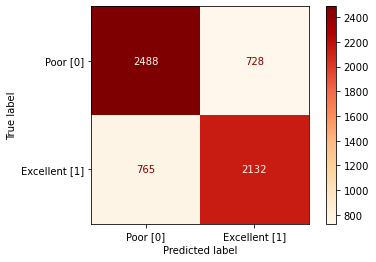

TN: 2488, FP: 728, FN: 765, TP: 2132
Accuracy: 0.75577
Recall: 0.73593
Precision: 0.74545
F1: 0.74066
ROC_AUC: 0.82881


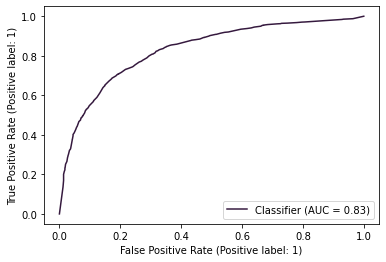

-------------------- Fold Result--------------------
Confusion Matrix:
[[512 131]
 [140 440]]
TN: 512, FP: 131, FN: 140, TP: 440
Accuracy: 0.77841
Recall: 0.75862
Precision: 0.77058
F1: 0.76455
ROC_AUC: 0.83985
-------------------- Fold Result--------------------
Confusion Matrix:
[[476 167]
 [131 449]]
TN: 476, FP: 167, FN: 131, TP: 449
Accuracy: 0.75634
Recall: 0.77414
Precision: 0.72890
F1: 0.75084
ROC_AUC: 0.81957
-------------------- Fold Result--------------------
Confusion Matrix:
[[508 136]
 [149 430]]
TN: 508, FP: 136, FN: 149, TP: 430
Accuracy: 0.76697
Recall: 0.74266
Precision: 0.75972
F1: 0.75109
ROC_AUC: 0.82930
-------------------- Fold Result--------------------
Confusion Matrix:
[[435 208]
 [130 449]]
TN: 435, FP: 208, FN: 130, TP: 449
Accuracy: 0.72340
Recall: 0.77547
Precision: 0.68341
F1: 0.72654
ROC_AUC: 0.79380
-------------------- Fold Result--------------------
Confusion Matrix:
[[493 150]
 [148 431]]
TN: 493, FP: 150, FN: 148, TP: 431
Accuracy: 0.75614
Recall: 0

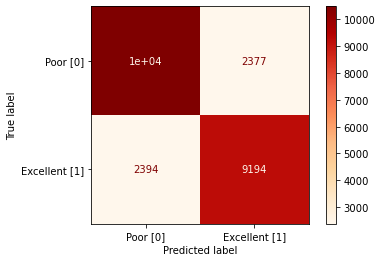

TN: 10487, FP: 2377, FN: 2394, TP: 9194
Accuracy: 0.80488
Recall: 0.79341
Precision: 0.79457
F1: 0.79399
ROC_AUC: 0.89249


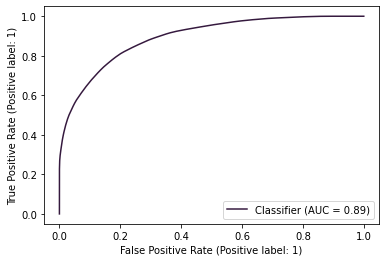

-------------------- Overall Test Result--------------------
Confusion Matrix:


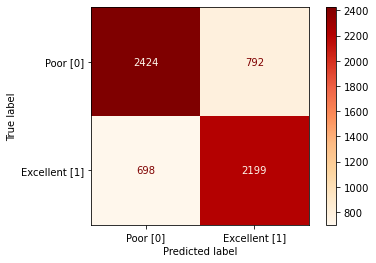

TN: 2424, FP: 792, FN: 698, TP: 2199
Accuracy: 0.75626
Recall: 0.75906
Precision: 0.73521
F1: 0.74694
ROC_AUC: 0.81906


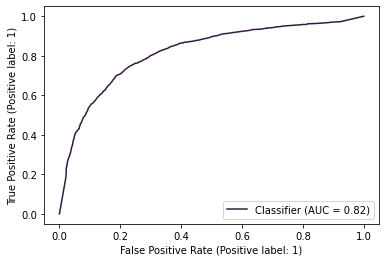

-------------------- Fold Result--------------------
Confusion Matrix:
[[505 138]
 [137 443]]
TN: 505, FP: 138, FN: 137, TP: 443
Accuracy: 0.77514
Recall: 0.76379
Precision: 0.76248
F1: 0.76314
ROC_AUC: 0.82748
-------------------- Fold Result--------------------
Confusion Matrix:
[[473 170]
 [140 440]]
TN: 473, FP: 170, FN: 140, TP: 440
Accuracy: 0.74652
Recall: 0.75862
Precision: 0.72131
F1: 0.73950
ROC_AUC: 0.80086
-------------------- Fold Result--------------------
Confusion Matrix:
[[505 139]
 [154 425]]
TN: 505, FP: 139, FN: 154, TP: 425
Accuracy: 0.76043
Recall: 0.73402
Precision: 0.75355
F1: 0.74366
ROC_AUC: 0.80992
-------------------- Fold Result--------------------
Confusion Matrix:
[[434 209]
 [134 445]]
TN: 434, FP: 209, FN: 134, TP: 445
Accuracy: 0.71931
Recall: 0.76857
Precision: 0.68043
F1: 0.72182
ROC_AUC: 0.78495
-------------------- Fold Result--------------------
Confusion Matrix:
[[484 159]
 [148 431]]
TN: 484, FP: 159, FN: 148, TP: 431
Accuracy: 0.74877
Recall: 0

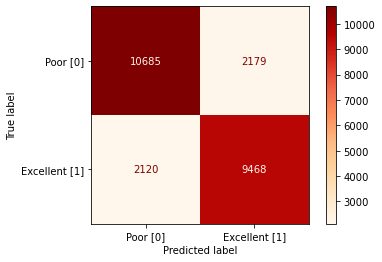

TN: 10685, FP: 2179, FN: 2120, TP: 9468
Accuracy: 0.82419
Recall: 0.81705
Precision: 0.81291
F1: 0.81498
ROC_AUC: 0.91175


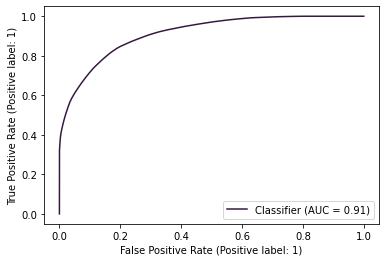

-------------------- Overall Test Result--------------------
Confusion Matrix:


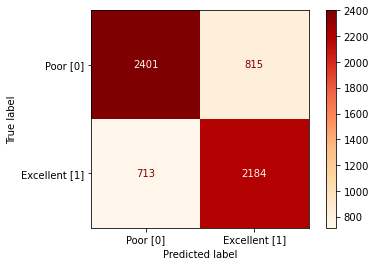

TN: 2401, FP: 815, FN: 713, TP: 2184
Accuracy: 0.75004
Recall: 0.75388
Precision: 0.72824
F1: 0.74084
ROC_AUC: 0.80482


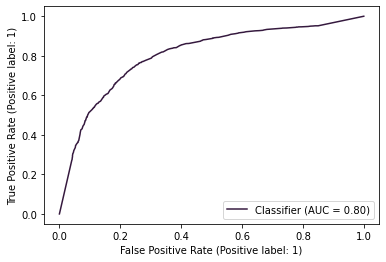

-------------------- Fold Result--------------------
Confusion Matrix:
[[510 133]
 [146 434]]
TN: 510, FP: 133, FN: 146, TP: 434
Accuracy: 0.77187
Recall: 0.74828
Precision: 0.76543
F1: 0.75676
ROC_AUC: 0.81207
-------------------- Fold Result--------------------
Confusion Matrix:
[[481 162]
 [159 421]]
TN: 481, FP: 162, FN: 159, TP: 421
Accuracy: 0.73753
Recall: 0.72586
Precision: 0.72213
F1: 0.72399
ROC_AUC: 0.79028
-------------------- Fold Result--------------------
Confusion Matrix:
[[503 141]
 [169 410]]
TN: 503, FP: 141, FN: 169, TP: 410
Accuracy: 0.74652
Recall: 0.70812
Precision: 0.74410
F1: 0.72566
ROC_AUC: 0.79542
-------------------- Fold Result--------------------
Confusion Matrix:
[[446 197]
 [140 439]]
TN: 446, FP: 197, FN: 140, TP: 439
Accuracy: 0.72422
Recall: 0.75820
Precision: 0.69025
F1: 0.72263
ROC_AUC: 0.76881
-------------------- Fold Result--------------------
Confusion Matrix:
[[474 169]
 [153 426]]
TN: 474, FP: 169, FN: 153, TP: 426
Accuracy: 0.73650
Recall: 0

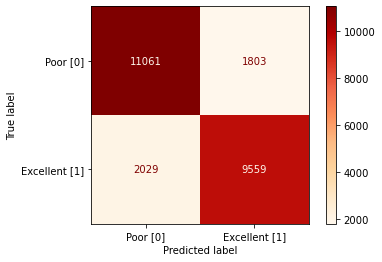

TN: 11061, FP: 1803, FN: 2029, TP: 9559
Accuracy: 0.84328
Recall: 0.82491
Precision: 0.84131
F1: 0.83303
ROC_AUC: 0.93004


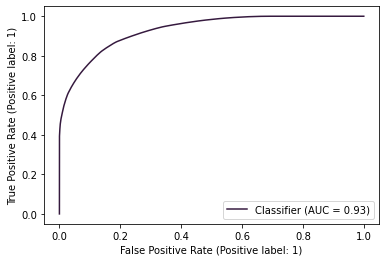

-------------------- Overall Test Result--------------------
Confusion Matrix:


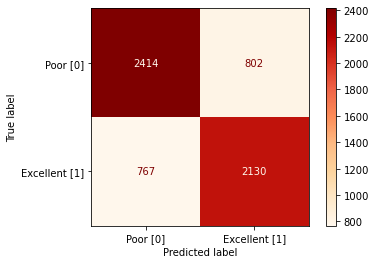

TN: 2414, FP: 802, FN: 767, TP: 2130
Accuracy: 0.74333
Recall: 0.73524
Precision: 0.72647
F1: 0.73083
ROC_AUC: 0.78984


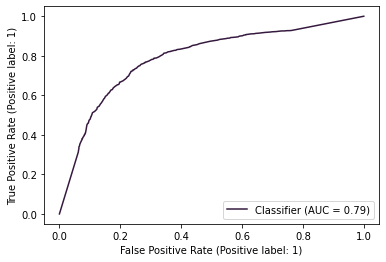

-------------------- Fold Result--------------------
Confusion Matrix:
[[508 135]
 [162 418]]
TN: 508, FP: 135, FN: 162, TP: 418
Accuracy: 0.75715
Recall: 0.72069
Precision: 0.75588
F1: 0.73786
ROC_AUC: 0.78305
-------------------- Fold Result--------------------
Confusion Matrix:
[[480 163]
 [174 406]]
TN: 480, FP: 163, FN: 174, TP: 406
Accuracy: 0.72445
Recall: 0.70000
Precision: 0.71353
F1: 0.70670
ROC_AUC: 0.76830
-------------------- Fold Result--------------------
Confusion Matrix:
[[500 144]
 [153 426]]
TN: 500, FP: 144, FN: 153, TP: 426
Accuracy: 0.75715
Recall: 0.73575
Precision: 0.74737
F1: 0.74151
ROC_AUC: 0.78812
-------------------- Fold Result--------------------
Confusion Matrix:
[[444 199]
 [132 447]]
TN: 444, FP: 199, FN: 132, TP: 447
Accuracy: 0.72913
Recall: 0.77202
Precision: 0.69195
F1: 0.72980
ROC_AUC: 0.76832
-------------------- Fold Result--------------------
Confusion Matrix:
[[469 174]
 [144 435]]
TN: 469, FP: 174, FN: 144, TP: 435
Accuracy: 0.73977
Recall: 0

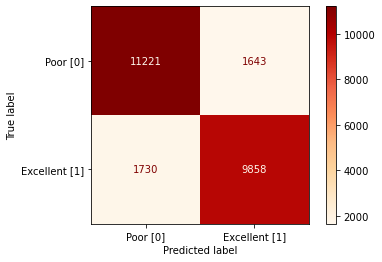

TN: 11221, FP: 1643, FN: 1730, TP: 9858
Accuracy: 0.86206
Recall: 0.85071
Precision: 0.85714
F1: 0.85391
ROC_AUC: 0.94676


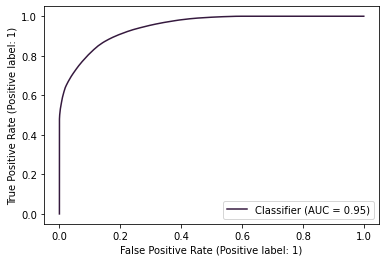

-------------------- Overall Test Result--------------------
Confusion Matrix:


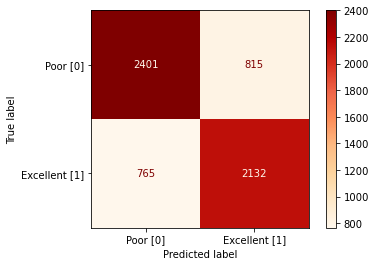

TN: 2401, FP: 815, FN: 765, TP: 2132
Accuracy: 0.74153
Recall: 0.73593
Precision: 0.72345
F1: 0.72964
ROC_AUC: 0.77742


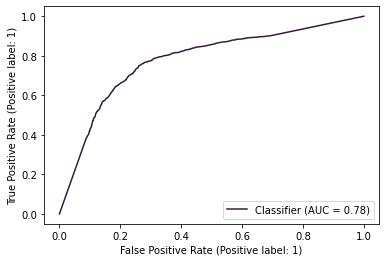

-------------------- Fold Result--------------------
Confusion Matrix:
[[500 143]
 [160 420]]
TN: 500, FP: 143, FN: 160, TP: 420
Accuracy: 0.75225
Recall: 0.72414
Precision: 0.74600
F1: 0.73491
ROC_AUC: 0.77357
-------------------- Fold Result--------------------
Confusion Matrix:
[[472 171]
 [171 409]]
TN: 472, FP: 171, FN: 171, TP: 409
Accuracy: 0.72036
Recall: 0.70517
Precision: 0.70517
F1: 0.70517
ROC_AUC: 0.75287
-------------------- Fold Result--------------------
Confusion Matrix:
[[490 154]
 [170 409]]
TN: 490, FP: 154, FN: 170, TP: 409
Accuracy: 0.73508
Recall: 0.70639
Precision: 0.72647
F1: 0.71629
ROC_AUC: 0.76328
-------------------- Fold Result--------------------
Confusion Matrix:
[[436 207]
 [139 440]]
TN: 436, FP: 207, FN: 139, TP: 440
Accuracy: 0.71686
Recall: 0.75993
Precision: 0.68006
F1: 0.71778
ROC_AUC: 0.75625
-------------------- Fold Result--------------------
Confusion Matrix:
[[465 178]
 [155 424]]
TN: 465, FP: 178, FN: 155, TP: 424
Accuracy: 0.72750
Recall: 0

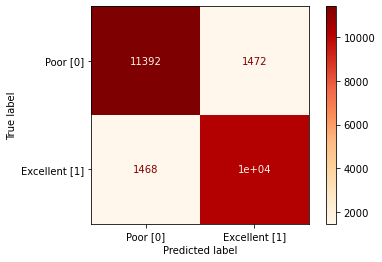

TN: 11392, FP: 1472, FN: 1468, TP: 10120
Accuracy: 0.87976
Recall: 0.87332
Precision: 0.87302
F1: 0.87317
ROC_AUC: 0.96075


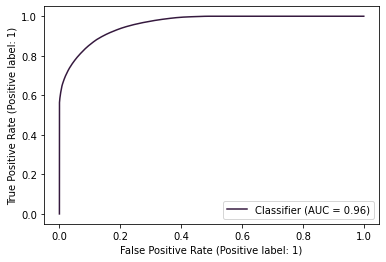

-------------------- Overall Test Result--------------------
Confusion Matrix:


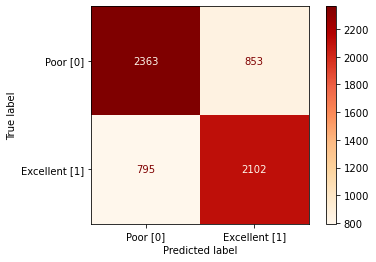

TN: 2363, FP: 853, FN: 795, TP: 2102
Accuracy: 0.73041
Recall: 0.72558
Precision: 0.71134
F1: 0.71839
ROC_AUC: 0.75995


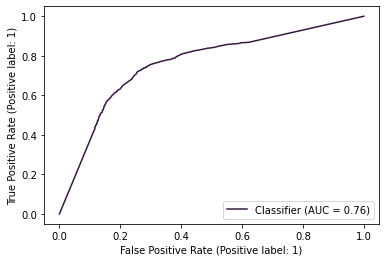

-------------------- Fold Result--------------------
Confusion Matrix:
[[497 146]
 [161 419]]
TN: 497, FP: 146, FN: 161, TP: 419
Accuracy: 0.74898
Recall: 0.72241
Precision: 0.74159
F1: 0.73188
ROC_AUC: 0.76893
-------------------- Fold Result--------------------
Confusion Matrix:
[[472 171]
 [168 412]]
TN: 472, FP: 171, FN: 168, TP: 412
Accuracy: 0.72281
Recall: 0.71034
Precision: 0.70669
F1: 0.70851
ROC_AUC: 0.73874
-------------------- Fold Result--------------------
Confusion Matrix:
[[490 154]
 [165 414]]
TN: 490, FP: 154, FN: 165, TP: 414
Accuracy: 0.73917
Recall: 0.71503
Precision: 0.72887
F1: 0.72188
ROC_AUC: 0.75327
-------------------- Fold Result--------------------
Confusion Matrix:
[[417 226]
 [139 440]]
TN: 417, FP: 226, FN: 139, TP: 440
Accuracy: 0.70131
Recall: 0.75993
Precision: 0.66066
F1: 0.70683
ROC_AUC: 0.73491
-------------------- Fold Result--------------------
Confusion Matrix:
[[471 172]
 [179 400]]
TN: 471, FP: 172, FN: 179, TP: 400
Accuracy: 0.71277
Recall: 0

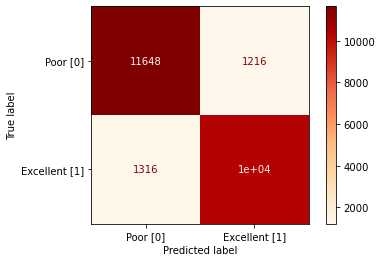

TN: 11648, FP: 1216, FN: 1316, TP: 10272
Accuracy: 0.89645
Recall: 0.88643
Precision: 0.89415
F1: 0.89028
ROC_AUC: 0.97168


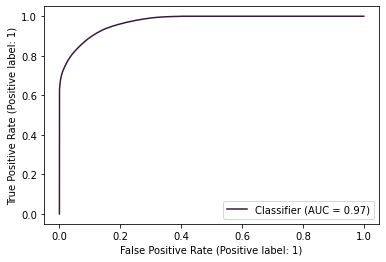

-------------------- Overall Test Result--------------------
Confusion Matrix:


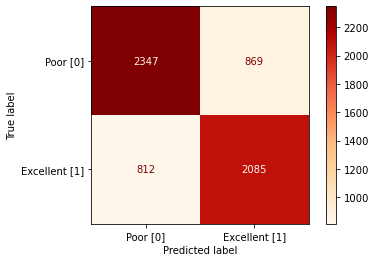

TN: 2347, FP: 869, FN: 812, TP: 2085
Accuracy: 0.72501
Recall: 0.71971
Precision: 0.70582
F1: 0.71270
ROC_AUC: 0.74784


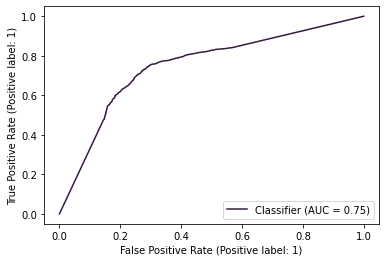

-------------------- Fold Result--------------------
Confusion Matrix:
[[482 161]
 [163 417]]
TN: 482, FP: 161, FN: 163, TP: 417
Accuracy: 0.73508
Recall: 0.71897
Precision: 0.72145
F1: 0.72021
ROC_AUC: 0.75999
-------------------- Fold Result--------------------
Confusion Matrix:
[[480 163]
 [169 411]]
TN: 480, FP: 163, FN: 169, TP: 411
Accuracy: 0.72854
Recall: 0.70862
Precision: 0.71603
F1: 0.71231
ROC_AUC: 0.73736
-------------------- Fold Result--------------------
Confusion Matrix:
[[491 153]
 [170 409]]
TN: 491, FP: 153, FN: 170, TP: 409
Accuracy: 0.73590
Recall: 0.70639
Precision: 0.72776
F1: 0.71691
ROC_AUC: 0.74296
-------------------- Fold Result--------------------
Confusion Matrix:
[[428 215]
 [146 433]]
TN: 428, FP: 215, FN: 146, TP: 433
Accuracy: 0.70458
Recall: 0.74784
Precision: 0.66821
F1: 0.70579
ROC_AUC: 0.73769
-------------------- Fold Result--------------------
Confusion Matrix:
[[466 177]
 [162 417]]
TN: 466, FP: 177, FN: 162, TP: 417
Accuracy: 0.72259
Recall: 0

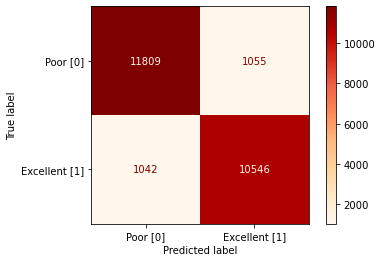

TN: 11809, FP: 1055, FN: 1042, TP: 10546
Accuracy: 0.91424
Recall: 0.91008
Precision: 0.90906
F1: 0.90957
ROC_AUC: 0.98050


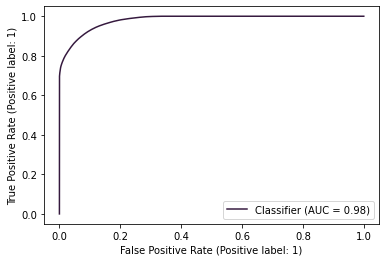

-------------------- Overall Test Result--------------------
Confusion Matrix:


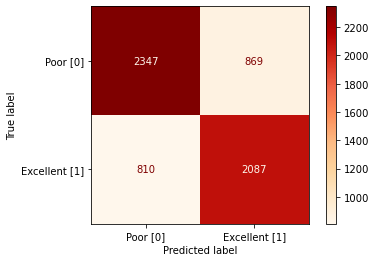

TN: 2347, FP: 869, FN: 810, TP: 2087
Accuracy: 0.72534
Recall: 0.72040
Precision: 0.70602
F1: 0.71314
ROC_AUC: 0.74428


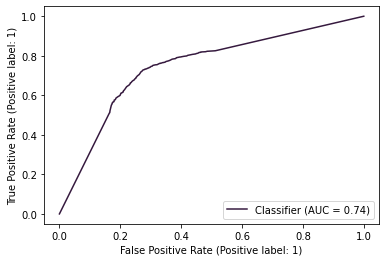

-------------------- Fold Result--------------------
Confusion Matrix:
[[489 154]
 [168 412]]
TN: 489, FP: 154, FN: 168, TP: 412
Accuracy: 0.73671
Recall: 0.71034
Precision: 0.72792
F1: 0.71902
ROC_AUC: 0.75071
-------------------- Fold Result--------------------
Confusion Matrix:
[[471 172]
 [187 393]]
TN: 471, FP: 172, FN: 187, TP: 393
Accuracy: 0.70646
Recall: 0.67759
Precision: 0.69558
F1: 0.68646
ROC_AUC: 0.72012
-------------------- Fold Result--------------------
Confusion Matrix:
[[492 152]
 [189 390]]
TN: 492, FP: 152, FN: 189, TP: 390
Accuracy: 0.72118
Recall: 0.67358
Precision: 0.71956
F1: 0.69581
ROC_AUC: 0.73437
-------------------- Fold Result--------------------
Confusion Matrix:
[[430 213]
 [140 439]]
TN: 430, FP: 213, FN: 140, TP: 439
Accuracy: 0.71113
Recall: 0.75820
Precision: 0.67331
F1: 0.71324
ROC_AUC: 0.73691
-------------------- Fold Result--------------------
Confusion Matrix:
[[476 167]
 [174 405]]
TN: 476, FP: 167, FN: 174, TP: 405
Accuracy: 0.72095
Recall: 0

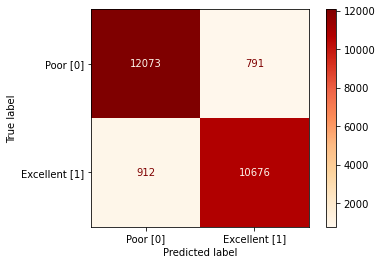

TN: 12073, FP: 791, FN: 912, TP: 10676
Accuracy: 0.93035
Recall: 0.92130
Precision: 0.93102
F1: 0.92613
ROC_AUC: 0.98729


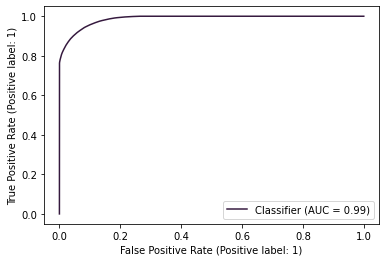

-------------------- Overall Test Result--------------------
Confusion Matrix:


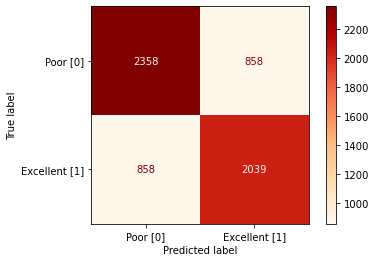

TN: 2358, FP: 858, FN: 858, TP: 2039
Accuracy: 0.71929
Recall: 0.70383
Precision: 0.70383
F1: 0.70383
ROC_AUC: 0.73619


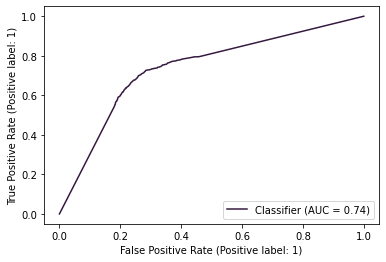

-------------------- Fold Result--------------------
Confusion Matrix:
[[484 159]
 [158 422]]
TN: 484, FP: 159, FN: 158, TP: 422
Accuracy: 0.74080
Recall: 0.72759
Precision: 0.72633
F1: 0.72696
ROC_AUC: 0.74973
-------------------- Fold Result--------------------
Confusion Matrix:
[[458 185]
 [164 416]]
TN: 458, FP: 185, FN: 164, TP: 416
Accuracy: 0.71464
Recall: 0.71724
Precision: 0.69218
F1: 0.70449
ROC_AUC: 0.72767
-------------------- Fold Result--------------------
Confusion Matrix:
[[484 160]
 [185 394]]
TN: 484, FP: 160, FN: 185, TP: 394
Accuracy: 0.71791
Recall: 0.68048
Precision: 0.71119
F1: 0.69550
ROC_AUC: 0.72014
-------------------- Fold Result--------------------
Confusion Matrix:
[[438 205]
 [157 422]]
TN: 438, FP: 205, FN: 157, TP: 422
Accuracy: 0.70376
Recall: 0.72884
Precision: 0.67305
F1: 0.69983
ROC_AUC: 0.72796
-------------------- Fold Result--------------------
Confusion Matrix:
[[464 179]
 [176 403]]
TN: 464, FP: 179, FN: 176, TP: 403
Accuracy: 0.70949
Recall: 0

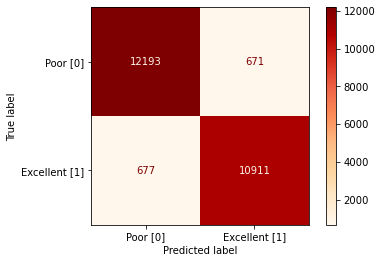

TN: 12193, FP: 671, FN: 677, TP: 10911
Accuracy: 0.94487
Recall: 0.94158
Precision: 0.94207
F1: 0.94182
ROC_AUC: 0.99183


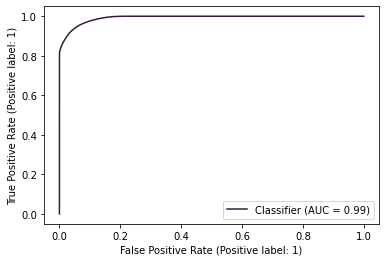

-------------------- Overall Test Result--------------------
Confusion Matrix:


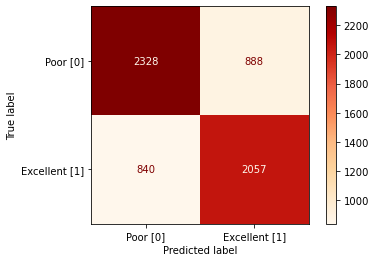

TN: 2328, FP: 888, FN: 840, TP: 2057
Accuracy: 0.71732
Recall: 0.71004
Precision: 0.69847
F1: 0.70421
ROC_AUC: 0.73013


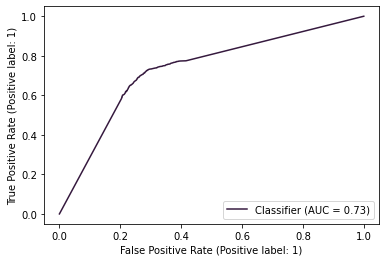

-------------------- Fold Result--------------------
Confusion Matrix:
[[495 148]
 [175 405]]
TN: 495, FP: 148, FN: 175, TP: 405
Accuracy: 0.73590
Recall: 0.69828
Precision: 0.73237
F1: 0.71492
ROC_AUC: 0.75014
-------------------- Fold Result--------------------
Confusion Matrix:
[[460 183]
 [186 394]]
TN: 460, FP: 183, FN: 186, TP: 394
Accuracy: 0.69828
Recall: 0.67931
Precision: 0.68284
F1: 0.68107
ROC_AUC: 0.70396
-------------------- Fold Result--------------------
Confusion Matrix:
[[478 166]
 [182 397]]
TN: 478, FP: 166, FN: 182, TP: 397
Accuracy: 0.71545
Recall: 0.68566
Precision: 0.70515
F1: 0.69527
ROC_AUC: 0.71348
-------------------- Fold Result--------------------
Confusion Matrix:
[[432 211]
 [157 422]]
TN: 432, FP: 211, FN: 157, TP: 422
Accuracy: 0.69885
Recall: 0.72884
Precision: 0.66667
F1: 0.69637
ROC_AUC: 0.72426
-------------------- Fold Result--------------------
Confusion Matrix:
[[458 185]
 [173 406]]
TN: 458, FP: 185, FN: 173, TP: 406
Accuracy: 0.70704
Recall: 0

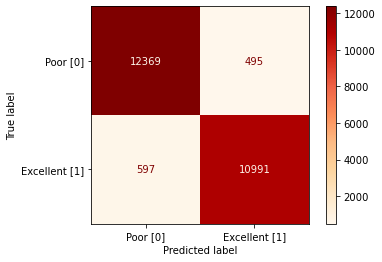

TN: 12369, FP: 495, FN: 597, TP: 10991
Accuracy: 0.95534
Recall: 0.94848
Precision: 0.95690
F1: 0.95267
ROC_AUC: 0.99472


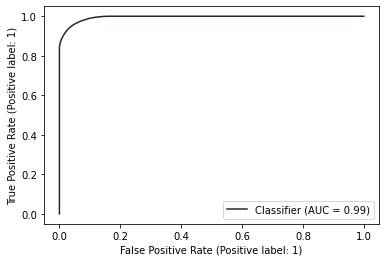

-------------------- Overall Test Result--------------------
Confusion Matrix:


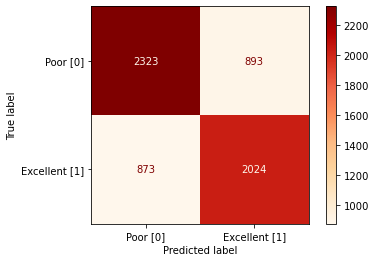

TN: 2323, FP: 893, FN: 873, TP: 2024
Accuracy: 0.71111
Recall: 0.69865
Precision: 0.69386
F1: 0.69625
ROC_AUC: 0.72376


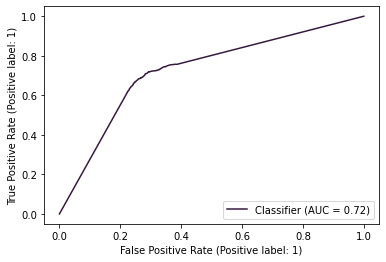

-------------------- Fold Result--------------------
Confusion Matrix:
[[488 155]
 [176 404]]
TN: 488, FP: 155, FN: 176, TP: 404
Accuracy: 0.72935
Recall: 0.69655
Precision: 0.72272
F1: 0.70939
ROC_AUC: 0.73877
-------------------- Fold Result--------------------
Confusion Matrix:
[[456 187]
 [180 400]]
TN: 456, FP: 187, FN: 180, TP: 400
Accuracy: 0.69992
Recall: 0.68966
Precision: 0.68143
F1: 0.68552
ROC_AUC: 0.71620
-------------------- Fold Result--------------------
Confusion Matrix:
[[472 172]
 [185 394]]
TN: 472, FP: 172, FN: 185, TP: 394
Accuracy: 0.70809
Recall: 0.68048
Precision: 0.69611
F1: 0.68821
ROC_AUC: 0.70518
-------------------- Fold Result--------------------
Confusion Matrix:
[[444 199]
 [160 419]]
TN: 444, FP: 199, FN: 160, TP: 419
Accuracy: 0.70622
Recall: 0.72366
Precision: 0.67799
F1: 0.70008
ROC_AUC: 0.72069
-------------------- Fold Result--------------------
Confusion Matrix:
[[468 175]
 [181 398]]
TN: 468, FP: 175, FN: 181, TP: 398
Accuracy: 0.70867
Recall: 0

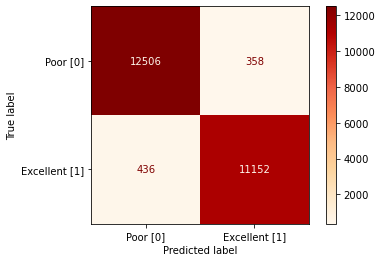

TN: 12506, FP: 358, FN: 436, TP: 11152
Accuracy: 0.96753
Recall: 0.96237
Precision: 0.96890
F1: 0.96562
ROC_AUC: 0.99711


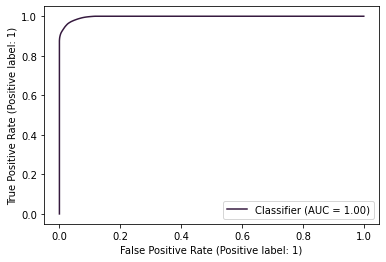

-------------------- Overall Test Result--------------------
Confusion Matrix:


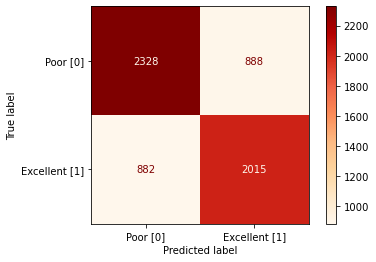

TN: 2328, FP: 888, FN: 882, TP: 2015
Accuracy: 0.71045
Recall: 0.69555
Precision: 0.69411
F1: 0.69483
ROC_AUC: 0.71966


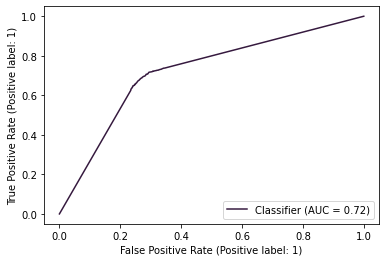

-------------------- Fold Result--------------------
Confusion Matrix:
[[479 164]
 [180 400]]
TN: 479, FP: 164, FN: 180, TP: 400
Accuracy: 0.71872
Recall: 0.68966
Precision: 0.70922
F1: 0.69930
ROC_AUC: 0.73338
-------------------- Fold Result--------------------
Confusion Matrix:
[[459 184]
 [182 398]]
TN: 459, FP: 184, FN: 182, TP: 398
Accuracy: 0.70074
Recall: 0.68621
Precision: 0.68385
F1: 0.68503
ROC_AUC: 0.71010
-------------------- Fold Result--------------------
Confusion Matrix:
[[476 168]
 [182 397]]
TN: 476, FP: 168, FN: 182, TP: 397
Accuracy: 0.71382
Recall: 0.68566
Precision: 0.70265
F1: 0.69406
ROC_AUC: 0.70678
-------------------- Fold Result--------------------
Confusion Matrix:
[[435 208]
 [153 426]]
TN: 435, FP: 208, FN: 153, TP: 426
Accuracy: 0.70458
Recall: 0.73575
Precision: 0.67192
F1: 0.70239
ROC_AUC: 0.71205
-------------------- Fold Result--------------------
Confusion Matrix:
[[467 176]
 [179 400]]
TN: 467, FP: 176, FN: 179, TP: 400
Accuracy: 0.70949
Recall: 0

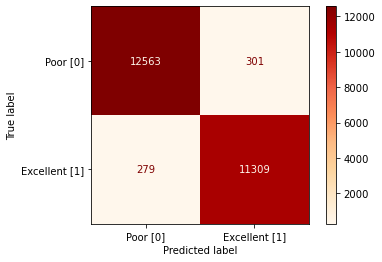

TN: 12563, FP: 301, FN: 279, TP: 11309
Accuracy: 0.97628
Recall: 0.97592
Precision: 0.97407
F1: 0.97500
ROC_AUC: 0.99850


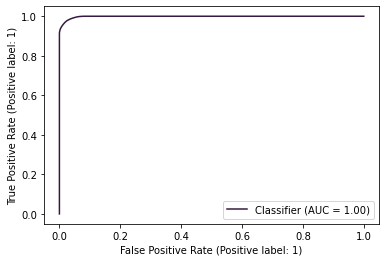

-------------------- Overall Test Result--------------------
Confusion Matrix:


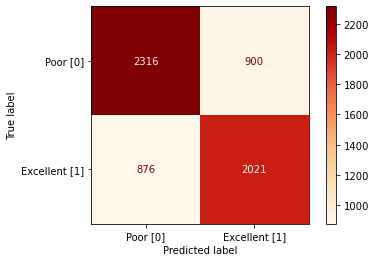

TN: 2316, FP: 900, FN: 876, TP: 2021
Accuracy: 0.70947
Recall: 0.69762
Precision: 0.69189
F1: 0.69474
ROC_AUC: 0.71370


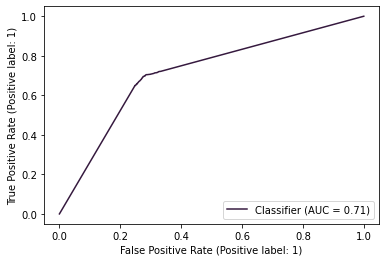

-------------------- Fold Result--------------------
Confusion Matrix:
[[487 156]
 [177 403]]
TN: 487, FP: 156, FN: 177, TP: 403
Accuracy: 0.72772
Recall: 0.69483
Precision: 0.72093
F1: 0.70764
ROC_AUC: 0.73995
-------------------- Fold Result--------------------
Confusion Matrix:
[[459 184]
 [180 400]]
TN: 459, FP: 184, FN: 180, TP: 400
Accuracy: 0.70237
Recall: 0.68966
Precision: 0.68493
F1: 0.68729
ROC_AUC: 0.70462
-------------------- Fold Result--------------------
Confusion Matrix:
[[470 174]
 [183 396]]
TN: 470, FP: 174, FN: 183, TP: 396
Accuracy: 0.70809
Recall: 0.68394
Precision: 0.69474
F1: 0.68930
ROC_AUC: 0.70963
-------------------- Fold Result--------------------
Confusion Matrix:
[[432 211]
 [155 424]]
TN: 432, FP: 211, FN: 155, TP: 424
Accuracy: 0.70049
Recall: 0.73230
Precision: 0.66772
F1: 0.69852
ROC_AUC: 0.70731
-------------------- Fold Result--------------------
Confusion Matrix:
[[469 174]
 [171 408]]
TN: 469, FP: 174, FN: 171, TP: 408
Accuracy: 0.71768
Recall: 0

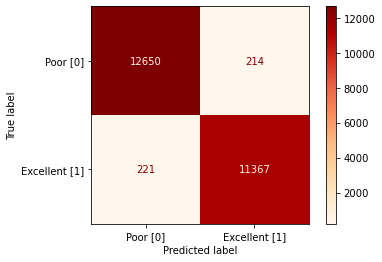

TN: 12650, FP: 214, FN: 221, TP: 11367
Accuracy: 0.98221
Recall: 0.98093
Precision: 0.98152
F1: 0.98122
ROC_AUC: 0.99918


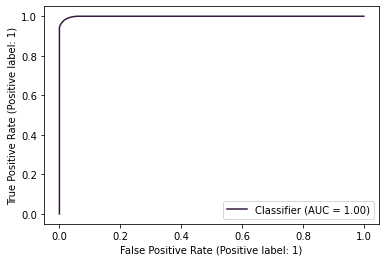

-------------------- Overall Test Result--------------------
Confusion Matrix:


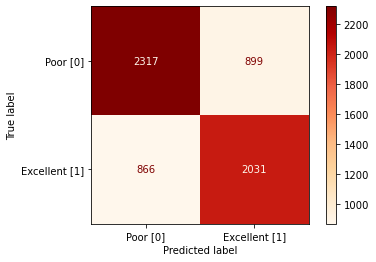

TN: 2317, FP: 899, FN: 866, TP: 2031
Accuracy: 0.71127
Recall: 0.70107
Precision: 0.69317
F1: 0.69710
ROC_AUC: 0.71669


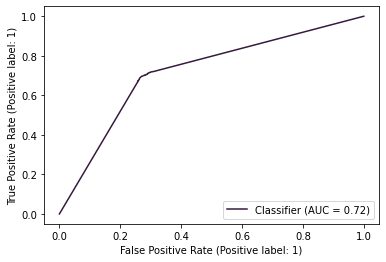

max_depth  roc_auc_train  roc_auc_test
0           3       0.835223      0.823307
1           4       0.850357      0.838473
2           5       0.863553      0.836356
3           6       0.877394      0.828808
4           7       0.892487      0.819059
5           8       0.911754      0.804819
6           9       0.930037      0.789845
7          10       0.946761      0.777422
8          11       0.960752      0.759953
9          12       0.971677      0.747844
10         13       0.980497      0.744281
11         14       0.987295      0.736191
12         15       0.991827      0.730130
13         16       0.994718      0.723762
14         17       0.997106      0.719656
15         18       0.998505      0.713701
16         19       0.999178      0.716689

In [86]:
max_depth = []
roc_auc_train_list = []
roc_auc_test_list = []

# Create Decision Tree classifer object
for n in range(3, 20):
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=n)
    roc_auc_train, roc_auc_test = stratified_k_fold_model_fit(X, y, clf, splits=5, shuffle=True, verbose=True, plot_confusion_matrix=True, plot_roc=True, hide_fold_result=False, title=None)
    max_depth.append(n)
    roc_auc_train_list.append(roc_auc_train)
    roc_auc_test_list.append(roc_auc_test)

df_decision_tree = pd.DataFrame(list(zip(max_depth, roc_auc_train_list, roc_auc_test_list)), columns = ["max_depth", "roc_auc_train", "roc_auc_test"])

In [87]:
df_decision_tree #max_depth = 4 gives the best roc_auc test scores

max_depth  roc_auc_train  roc_auc_test
0           3       0.835223      0.823307
1           4       0.850357      0.838473
2           5       0.863553      0.836356
3           6       0.877394      0.828808
4           7       0.892487      0.819059
5           8       0.911754      0.804819
6           9       0.930037      0.789845
7          10       0.946761      0.777422
8          11       0.960752      0.759953
9          12       0.971677      0.747844
10         13       0.980497      0.744281
11         14       0.987295      0.736191
12         15       0.991827      0.730130
13         16       0.994718      0.723762
14         17       0.997106      0.719656
15         18       0.998505      0.713701
16         19       0.999178      0.716689

-------------------- Fold Result--------------------
Confusion Matrix:
[[471 172]
 [110 470]]
TN: 471, FP: 172, FN: 110, TP: 470
Accuracy: 0.76942
Recall: 0.81034
Precision: 0.73209
F1: 0.76923
ROC_AUC: 0.85219
-------------------- Fold Result--------------------
Confusion Matrix:
[[477 166]
 [147 433]]
TN: 477, FP: 166, FN: 147, TP: 433
Accuracy: 0.74407
Recall: 0.74655
Precision: 0.72287
F1: 0.73452
ROC_AUC: 0.83306
-------------------- Fold Result--------------------
Confusion Matrix:
[[545  99]
 [198 381]]
TN: 545, FP: 99, FN: 198, TP: 381
Accuracy: 0.75715
Recall: 0.65803
Precision: 0.79375
F1: 0.71955
ROC_AUC: 0.83803
-------------------- Fold Result--------------------
Confusion Matrix:
[[496 147]
 [160 419]]
TN: 496, FP: 147, FN: 160, TP: 419
Accuracy: 0.74877
Recall: 0.72366
Precision: 0.74028
F1: 0.73188
ROC_AUC: 0.82015
-------------------- Fold Result--------------------
Confusion Matrix:
[[538 105]
 [192 387]]
TN: 538, FP: 105, FN: 192, TP: 387
Accuracy: 0.75696
Recall: 0.

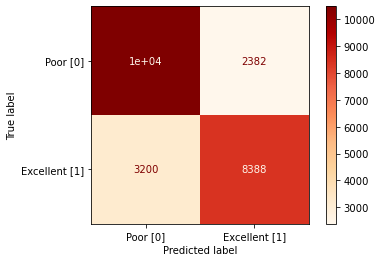

TN: 10482, FP: 2382, FN: 3200, TP: 8388
Accuracy: 0.77172
Recall: 0.72385
Precision: 0.77883
F1: 0.75034
ROC_AUC: 0.85036


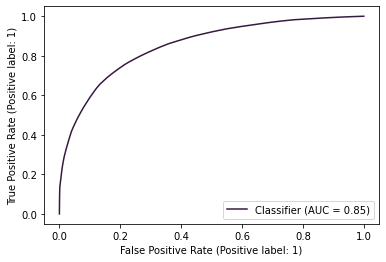

-------------------- Overall Test Result--------------------
Confusion Matrix:


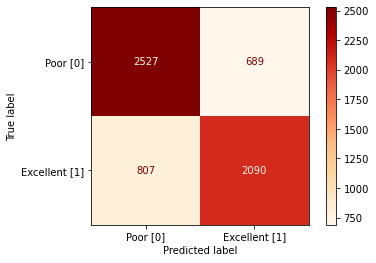

TN: 2527, FP: 689, FN: 807, TP: 2090
Accuracy: 0.75528
Recall: 0.72144
Precision: 0.75207
F1: 0.73643
ROC_AUC: 0.83845


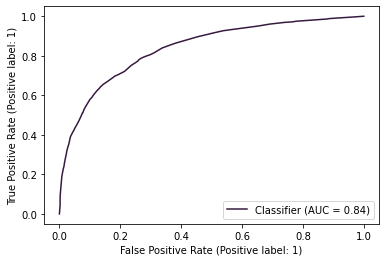

-------------------- Fold Result--------------------
Confusion Matrix:
[[471 172]
 [110 470]]
TN: 471, FP: 172, FN: 110, TP: 470
Accuracy: 0.76942
Recall: 0.81034
Precision: 0.73209
F1: 0.76923
ROC_AUC: 0.85219
-------------------- Fold Result--------------------
Confusion Matrix:
[[477 166]
 [147 433]]
TN: 477, FP: 166, FN: 147, TP: 433
Accuracy: 0.74407
Recall: 0.74655
Precision: 0.72287
F1: 0.73452
ROC_AUC: 0.83306
-------------------- Fold Result--------------------
Confusion Matrix:
[[545  99]
 [198 381]]
TN: 545, FP: 99, FN: 198, TP: 381
Accuracy: 0.75715
Recall: 0.65803
Precision: 0.79375
F1: 0.71955
ROC_AUC: 0.83803
-------------------- Fold Result--------------------
Confusion Matrix:
[[496 147]
 [160 419]]
TN: 496, FP: 147, FN: 160, TP: 419
Accuracy: 0.74877
Recall: 0.72366
Precision: 0.74028
F1: 0.73188
ROC_AUC: 0.82015
-------------------- Fold Result--------------------
Confusion Matrix:
[[538 105]
 [192 387]]
TN: 538, FP: 105, FN: 192, TP: 387
Accuracy: 0.75696
Recall: 0.

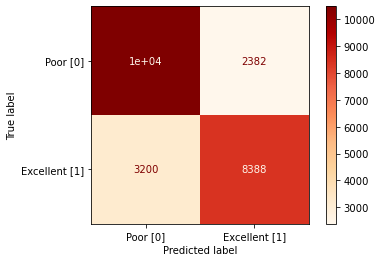

TN: 10482, FP: 2382, FN: 3200, TP: 8388
Accuracy: 0.77172
Recall: 0.72385
Precision: 0.77883
F1: 0.75034
ROC_AUC: 0.85036


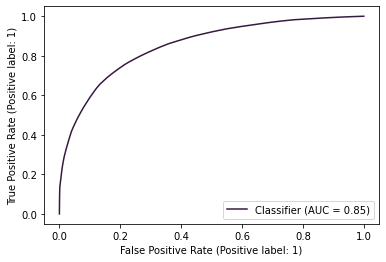

-------------------- Overall Test Result--------------------
Confusion Matrix:


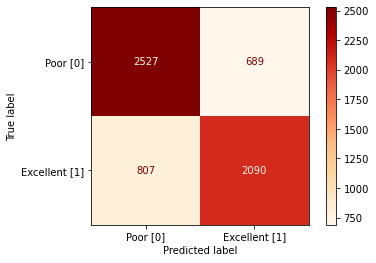

TN: 2527, FP: 689, FN: 807, TP: 2090
Accuracy: 0.75528
Recall: 0.72144
Precision: 0.75207
F1: 0.73643
ROC_AUC: 0.83847


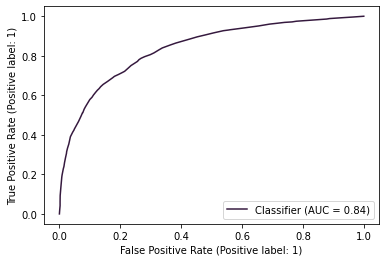

-------------------- Fold Result--------------------
Confusion Matrix:
[[471 172]
 [110 470]]
TN: 471, FP: 172, FN: 110, TP: 470
Accuracy: 0.76942
Recall: 0.81034
Precision: 0.73209
F1: 0.76923
ROC_AUC: 0.85219
-------------------- Fold Result--------------------
Confusion Matrix:
[[477 166]
 [147 433]]
TN: 477, FP: 166, FN: 147, TP: 433
Accuracy: 0.74407
Recall: 0.74655
Precision: 0.72287
F1: 0.73452
ROC_AUC: 0.83306
-------------------- Fold Result--------------------
Confusion Matrix:
[[545  99]
 [198 381]]
TN: 545, FP: 99, FN: 198, TP: 381
Accuracy: 0.75715
Recall: 0.65803
Precision: 0.79375
F1: 0.71955
ROC_AUC: 0.83803
-------------------- Fold Result--------------------
Confusion Matrix:
[[496 147]
 [160 419]]
TN: 496, FP: 147, FN: 160, TP: 419
Accuracy: 0.74877
Recall: 0.72366
Precision: 0.74028
F1: 0.73188
ROC_AUC: 0.82015
-------------------- Fold Result--------------------
Confusion Matrix:
[[538 105]
 [192 387]]
TN: 538, FP: 105, FN: 192, TP: 387
Accuracy: 0.75696
Recall: 0.

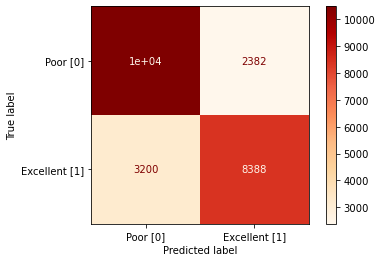

TN: 10482, FP: 2382, FN: 3200, TP: 8388
Accuracy: 0.77172
Recall: 0.72385
Precision: 0.77883
F1: 0.75034
ROC_AUC: 0.85036


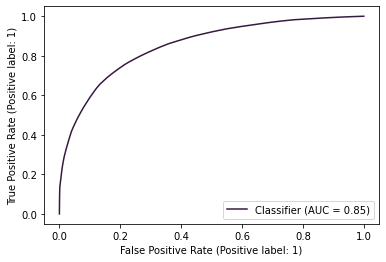

-------------------- Overall Test Result--------------------
Confusion Matrix:


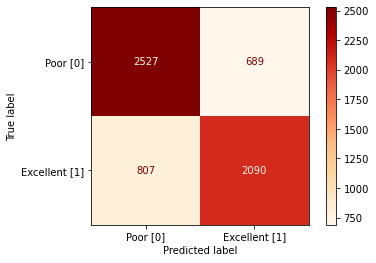

TN: 2527, FP: 689, FN: 807, TP: 2090
Accuracy: 0.75528
Recall: 0.72144
Precision: 0.75207
F1: 0.73643
ROC_AUC: 0.83847


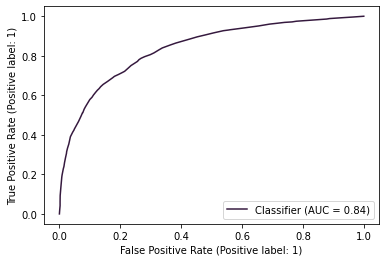

-------------------- Fold Result--------------------
Confusion Matrix:
[[471 172]
 [110 470]]
TN: 471, FP: 172, FN: 110, TP: 470
Accuracy: 0.76942
Recall: 0.81034
Precision: 0.73209
F1: 0.76923
ROC_AUC: 0.85219
-------------------- Fold Result--------------------
Confusion Matrix:
[[477 166]
 [147 433]]
TN: 477, FP: 166, FN: 147, TP: 433
Accuracy: 0.74407
Recall: 0.74655
Precision: 0.72287
F1: 0.73452
ROC_AUC: 0.83306
-------------------- Fold Result--------------------
Confusion Matrix:
[[545  99]
 [198 381]]
TN: 545, FP: 99, FN: 198, TP: 381
Accuracy: 0.75715
Recall: 0.65803
Precision: 0.79375
F1: 0.71955
ROC_AUC: 0.83803
-------------------- Fold Result--------------------
Confusion Matrix:
[[496 147]
 [160 419]]
TN: 496, FP: 147, FN: 160, TP: 419
Accuracy: 0.74877
Recall: 0.72366
Precision: 0.74028
F1: 0.73188
ROC_AUC: 0.82015
-------------------- Fold Result--------------------
Confusion Matrix:
[[538 105]
 [192 387]]
TN: 538, FP: 105, FN: 192, TP: 387
Accuracy: 0.75696
Recall: 0.

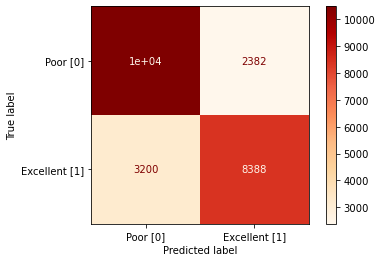

TN: 10482, FP: 2382, FN: 3200, TP: 8388
Accuracy: 0.77172
Recall: 0.72385
Precision: 0.77883
F1: 0.75034
ROC_AUC: 0.85036


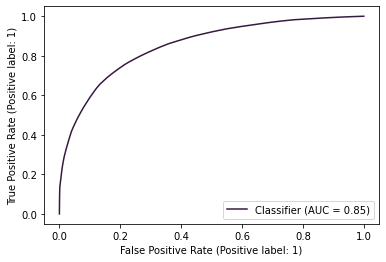

-------------------- Overall Test Result--------------------
Confusion Matrix:


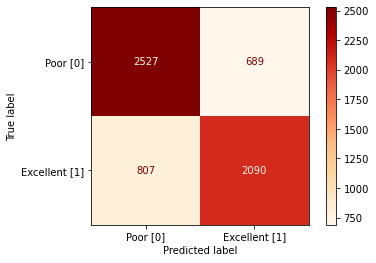

TN: 2527, FP: 689, FN: 807, TP: 2090
Accuracy: 0.75528
Recall: 0.72144
Precision: 0.75207
F1: 0.73643
ROC_AUC: 0.83847


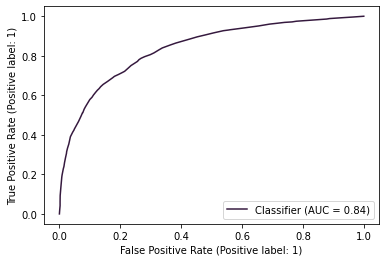

-------------------- Fold Result--------------------
Confusion Matrix:
[[471 172]
 [110 470]]
TN: 471, FP: 172, FN: 110, TP: 470
Accuracy: 0.76942
Recall: 0.81034
Precision: 0.73209
F1: 0.76923
ROC_AUC: 0.85219
-------------------- Fold Result--------------------
Confusion Matrix:
[[477 166]
 [147 433]]
TN: 477, FP: 166, FN: 147, TP: 433
Accuracy: 0.74407
Recall: 0.74655
Precision: 0.72287
F1: 0.73452
ROC_AUC: 0.83306
-------------------- Fold Result--------------------
Confusion Matrix:
[[545  99]
 [198 381]]
TN: 545, FP: 99, FN: 198, TP: 381
Accuracy: 0.75715
Recall: 0.65803
Precision: 0.79375
F1: 0.71955
ROC_AUC: 0.83803
-------------------- Fold Result--------------------
Confusion Matrix:
[[496 147]
 [160 419]]
TN: 496, FP: 147, FN: 160, TP: 419
Accuracy: 0.74877
Recall: 0.72366
Precision: 0.74028
F1: 0.73188
ROC_AUC: 0.82015
-------------------- Fold Result--------------------
Confusion Matrix:
[[538 105]
 [192 387]]
TN: 538, FP: 105, FN: 192, TP: 387
Accuracy: 0.75696
Recall: 0.

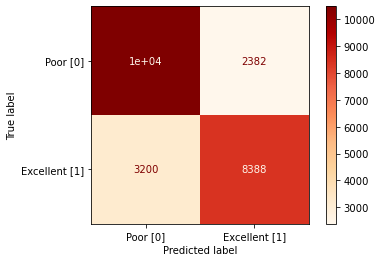

TN: 10482, FP: 2382, FN: 3200, TP: 8388
Accuracy: 0.77172
Recall: 0.72385
Precision: 0.77883
F1: 0.75034
ROC_AUC: 0.85036


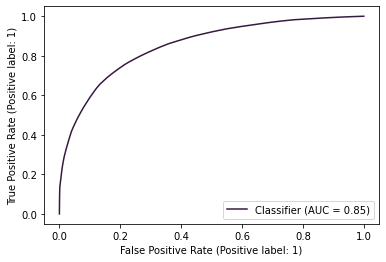

-------------------- Overall Test Result--------------------
Confusion Matrix:


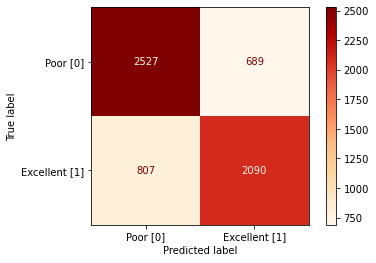

TN: 2527, FP: 689, FN: 807, TP: 2090
Accuracy: 0.75528
Recall: 0.72144
Precision: 0.75207
F1: 0.73643
ROC_AUC: 0.83847


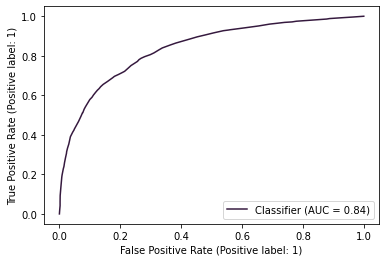

-------------------- Fold Result--------------------
Confusion Matrix:
[[471 172]
 [110 470]]
TN: 471, FP: 172, FN: 110, TP: 470
Accuracy: 0.76942
Recall: 0.81034
Precision: 0.73209
F1: 0.76923
ROC_AUC: 0.85219
-------------------- Fold Result--------------------
Confusion Matrix:
[[477 166]
 [147 433]]
TN: 477, FP: 166, FN: 147, TP: 433
Accuracy: 0.74407
Recall: 0.74655
Precision: 0.72287
F1: 0.73452
ROC_AUC: 0.83415
-------------------- Fold Result--------------------
Confusion Matrix:
[[545  99]
 [198 381]]
TN: 545, FP: 99, FN: 198, TP: 381
Accuracy: 0.75715
Recall: 0.65803
Precision: 0.79375
F1: 0.71955
ROC_AUC: 0.83803
-------------------- Fold Result--------------------
Confusion Matrix:
[[496 147]
 [160 419]]
TN: 496, FP: 147, FN: 160, TP: 419
Accuracy: 0.74877
Recall: 0.72366
Precision: 0.74028
F1: 0.73188
ROC_AUC: 0.82015
-------------------- Fold Result--------------------
Confusion Matrix:
[[541 102]
 [192 387]]
TN: 541, FP: 102, FN: 192, TP: 387
Accuracy: 0.75941
Recall: 0.

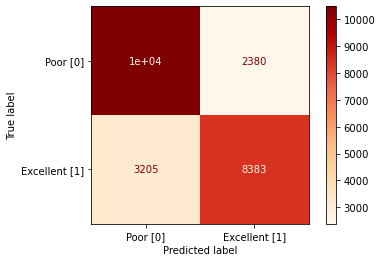

TN: 10484, FP: 2380, FN: 3205, TP: 8383
Accuracy: 0.77159
Recall: 0.72342
Precision: 0.77887
F1: 0.75012
ROC_AUC: 0.85024


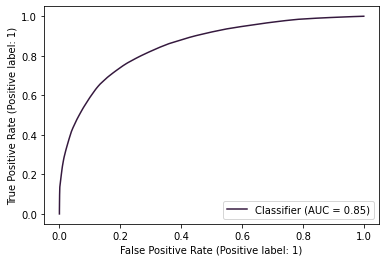

-------------------- Overall Test Result--------------------
Confusion Matrix:


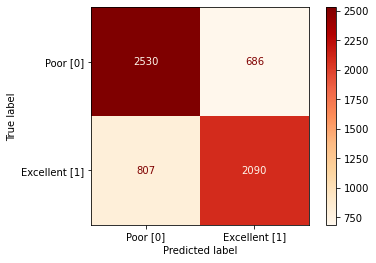

TN: 2530, FP: 686, FN: 807, TP: 2090
Accuracy: 0.75577
Recall: 0.72144
Precision: 0.75288
F1: 0.73682
ROC_AUC: 0.83892


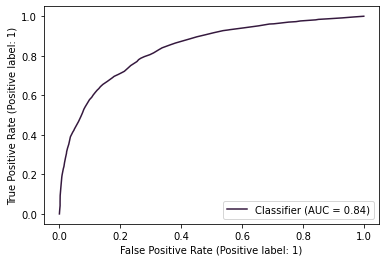

-------------------- Fold Result--------------------
Confusion Matrix:
[[471 172]
 [110 470]]
TN: 471, FP: 172, FN: 110, TP: 470
Accuracy: 0.76942
Recall: 0.81034
Precision: 0.73209
F1: 0.76923
ROC_AUC: 0.85219
-------------------- Fold Result--------------------
Confusion Matrix:
[[477 166]
 [147 433]]
TN: 477, FP: 166, FN: 147, TP: 433
Accuracy: 0.74407
Recall: 0.74655
Precision: 0.72287
F1: 0.73452
ROC_AUC: 0.83212
-------------------- Fold Result--------------------
Confusion Matrix:
[[545  99]
 [198 381]]
TN: 545, FP: 99, FN: 198, TP: 381
Accuracy: 0.75715
Recall: 0.65803
Precision: 0.79375
F1: 0.71955
ROC_AUC: 0.83803
-------------------- Fold Result--------------------
Confusion Matrix:
[[496 147]
 [160 419]]
TN: 496, FP: 147, FN: 160, TP: 419
Accuracy: 0.74877
Recall: 0.72366
Precision: 0.74028
F1: 0.73188
ROC_AUC: 0.82015
-------------------- Fold Result--------------------
Confusion Matrix:
[[541 102]
 [192 387]]
TN: 541, FP: 102, FN: 192, TP: 387
Accuracy: 0.75941
Recall: 0.

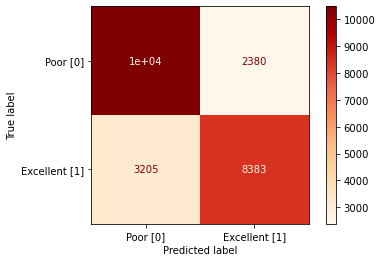

TN: 10484, FP: 2380, FN: 3205, TP: 8383
Accuracy: 0.77159
Recall: 0.72342
Precision: 0.77887
F1: 0.75012
ROC_AUC: 0.85022


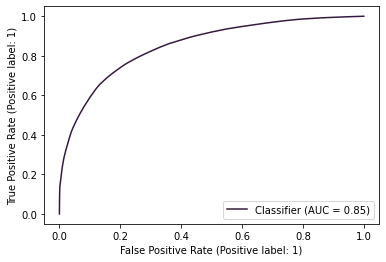

-------------------- Overall Test Result--------------------
Confusion Matrix:


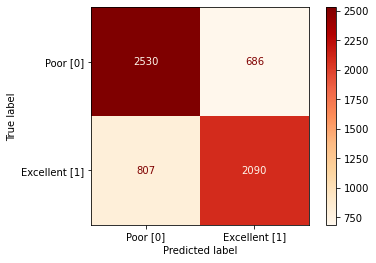

TN: 2530, FP: 686, FN: 807, TP: 2090
Accuracy: 0.75577
Recall: 0.72144
Precision: 0.75288
F1: 0.73682
ROC_AUC: 0.83858


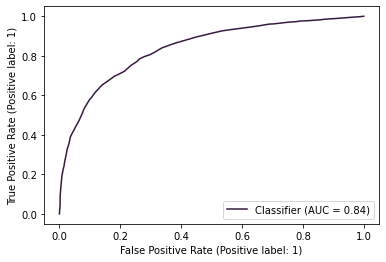

-------------------- Fold Result--------------------
Confusion Matrix:
[[471 172]
 [110 470]]
TN: 471, FP: 172, FN: 110, TP: 470
Accuracy: 0.76942
Recall: 0.81034
Precision: 0.73209
F1: 0.76923
ROC_AUC: 0.85219
-------------------- Fold Result--------------------
Confusion Matrix:
[[477 166]
 [147 433]]
TN: 477, FP: 166, FN: 147, TP: 433
Accuracy: 0.74407
Recall: 0.74655
Precision: 0.72287
F1: 0.73452
ROC_AUC: 0.83212
-------------------- Fold Result--------------------
Confusion Matrix:
[[545  99]
 [198 381]]
TN: 545, FP: 99, FN: 198, TP: 381
Accuracy: 0.75715
Recall: 0.65803
Precision: 0.79375
F1: 0.71955
ROC_AUC: 0.83803
-------------------- Fold Result--------------------
Confusion Matrix:
[[496 147]
 [160 419]]
TN: 496, FP: 147, FN: 160, TP: 419
Accuracy: 0.74877
Recall: 0.72366
Precision: 0.74028
F1: 0.73188
ROC_AUC: 0.82015
-------------------- Fold Result--------------------
Confusion Matrix:
[[541 102]
 [192 387]]
TN: 541, FP: 102, FN: 192, TP: 387
Accuracy: 0.75941
Recall: 0.

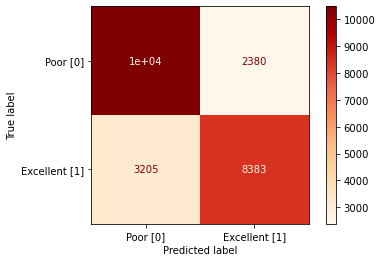

TN: 10484, FP: 2380, FN: 3205, TP: 8383
Accuracy: 0.77159
Recall: 0.72342
Precision: 0.77887
F1: 0.75012
ROC_AUC: 0.85022


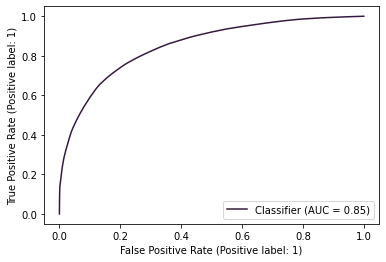

-------------------- Overall Test Result--------------------
Confusion Matrix:


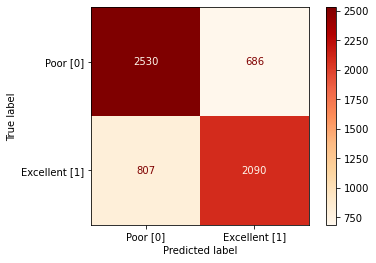

TN: 2530, FP: 686, FN: 807, TP: 2090
Accuracy: 0.75577
Recall: 0.72144
Precision: 0.75288
F1: 0.73682
ROC_AUC: 0.83858


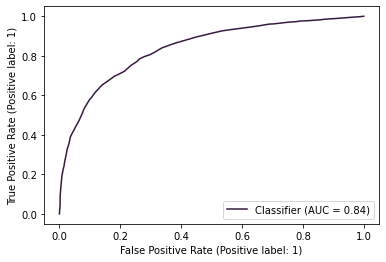

-------------------- Fold Result--------------------
Confusion Matrix:
[[471 172]
 [110 470]]
TN: 471, FP: 172, FN: 110, TP: 470
Accuracy: 0.76942
Recall: 0.81034
Precision: 0.73209
F1: 0.76923
ROC_AUC: 0.85219
-------------------- Fold Result--------------------
Confusion Matrix:
[[477 166]
 [147 433]]
TN: 477, FP: 166, FN: 147, TP: 433
Accuracy: 0.74407
Recall: 0.74655
Precision: 0.72287
F1: 0.73452
ROC_AUC: 0.83212
-------------------- Fold Result--------------------
Confusion Matrix:
[[545  99]
 [198 381]]
TN: 545, FP: 99, FN: 198, TP: 381
Accuracy: 0.75715
Recall: 0.65803
Precision: 0.79375
F1: 0.71955
ROC_AUC: 0.83803
-------------------- Fold Result--------------------
Confusion Matrix:
[[496 147]
 [160 419]]
TN: 496, FP: 147, FN: 160, TP: 419
Accuracy: 0.74877
Recall: 0.72366
Precision: 0.74028
F1: 0.73188
ROC_AUC: 0.82015
-------------------- Fold Result--------------------
Confusion Matrix:
[[541 102]
 [192 387]]
TN: 541, FP: 102, FN: 192, TP: 387
Accuracy: 0.75941
Recall: 0.

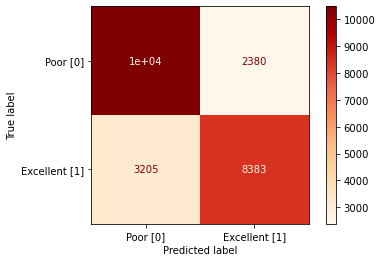

TN: 10484, FP: 2380, FN: 3205, TP: 8383
Accuracy: 0.77159
Recall: 0.72342
Precision: 0.77887
F1: 0.75012
ROC_AUC: 0.85022


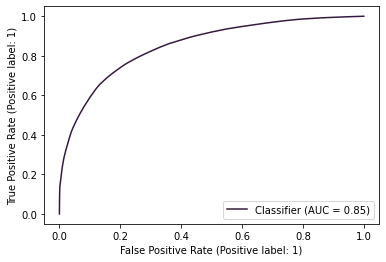

-------------------- Overall Test Result--------------------
Confusion Matrix:


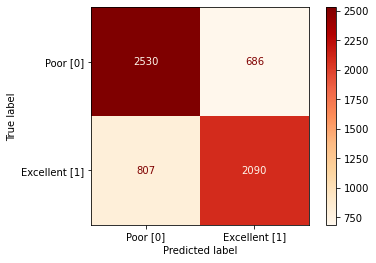

TN: 2530, FP: 686, FN: 807, TP: 2090
Accuracy: 0.75577
Recall: 0.72144
Precision: 0.75288
F1: 0.73682
ROC_AUC: 0.83858


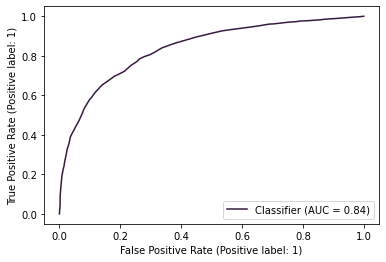

-------------------- Fold Result--------------------
Confusion Matrix:
[[471 172]
 [110 470]]
TN: 471, FP: 172, FN: 110, TP: 470
Accuracy: 0.76942
Recall: 0.81034
Precision: 0.73209
F1: 0.76923
ROC_AUC: 0.85219
-------------------- Fold Result--------------------
Confusion Matrix:
[[477 166]
 [147 433]]
TN: 477, FP: 166, FN: 147, TP: 433
Accuracy: 0.74407
Recall: 0.74655
Precision: 0.72287
F1: 0.73452
ROC_AUC: 0.83212
-------------------- Fold Result--------------------
Confusion Matrix:
[[545  99]
 [198 381]]
TN: 545, FP: 99, FN: 198, TP: 381
Accuracy: 0.75715
Recall: 0.65803
Precision: 0.79375
F1: 0.71955
ROC_AUC: 0.83803
-------------------- Fold Result--------------------
Confusion Matrix:
[[496 147]
 [160 419]]
TN: 496, FP: 147, FN: 160, TP: 419
Accuracy: 0.74877
Recall: 0.72366
Precision: 0.74028
F1: 0.73188
ROC_AUC: 0.82015
-------------------- Fold Result--------------------
Confusion Matrix:
[[541 102]
 [192 387]]
TN: 541, FP: 102, FN: 192, TP: 387
Accuracy: 0.75941
Recall: 0.

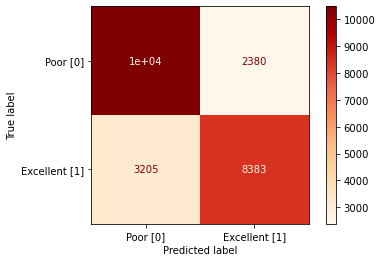

TN: 10484, FP: 2380, FN: 3205, TP: 8383
Accuracy: 0.77159
Recall: 0.72342
Precision: 0.77887
F1: 0.75012
ROC_AUC: 0.85022


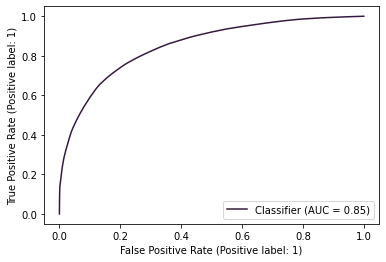

-------------------- Overall Test Result--------------------
Confusion Matrix:


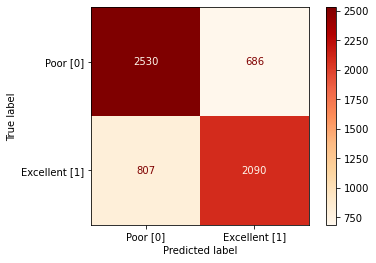

TN: 2530, FP: 686, FN: 807, TP: 2090
Accuracy: 0.75577
Recall: 0.72144
Precision: 0.75288
F1: 0.73682
ROC_AUC: 0.83861


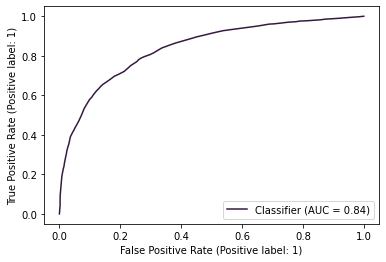

-------------------- Fold Result--------------------
Confusion Matrix:
[[471 172]
 [110 470]]
TN: 471, FP: 172, FN: 110, TP: 470
Accuracy: 0.76942
Recall: 0.81034
Precision: 0.73209
F1: 0.76923
ROC_AUC: 0.85219
-------------------- Fold Result--------------------
Confusion Matrix:
[[477 166]
 [147 433]]
TN: 477, FP: 166, FN: 147, TP: 433
Accuracy: 0.74407
Recall: 0.74655
Precision: 0.72287
F1: 0.73452
ROC_AUC: 0.83212
-------------------- Fold Result--------------------
Confusion Matrix:
[[545  99]
 [198 381]]
TN: 545, FP: 99, FN: 198, TP: 381
Accuracy: 0.75715
Recall: 0.65803
Precision: 0.79375
F1: 0.71955
ROC_AUC: 0.83803
-------------------- Fold Result--------------------
Confusion Matrix:
[[496 147]
 [160 419]]
TN: 496, FP: 147, FN: 160, TP: 419
Accuracy: 0.74877
Recall: 0.72366
Precision: 0.74028
F1: 0.73188
ROC_AUC: 0.82015
-------------------- Fold Result--------------------
Confusion Matrix:
[[541 102]
 [192 387]]
TN: 541, FP: 102, FN: 192, TP: 387
Accuracy: 0.75941
Recall: 0.

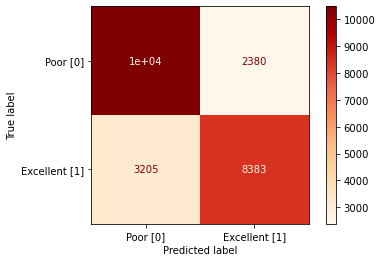

TN: 10484, FP: 2380, FN: 3205, TP: 8383
Accuracy: 0.77159
Recall: 0.72342
Precision: 0.77887
F1: 0.75012
ROC_AUC: 0.85022


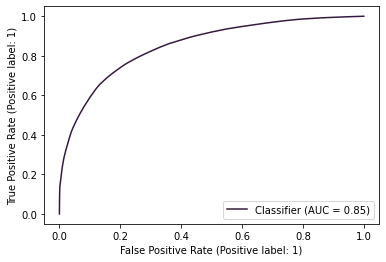

-------------------- Overall Test Result--------------------
Confusion Matrix:


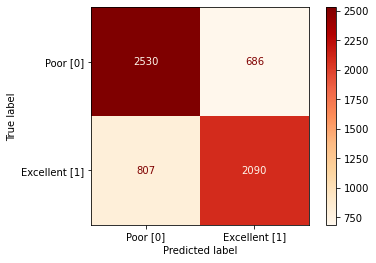

TN: 2530, FP: 686, FN: 807, TP: 2090
Accuracy: 0.75577
Recall: 0.72144
Precision: 0.75288
F1: 0.73682
ROC_AUC: 0.83861


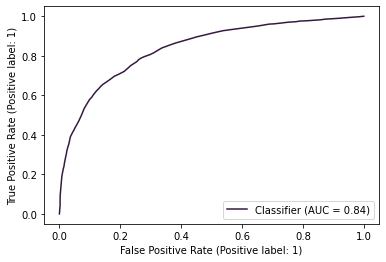

-------------------- Fold Result--------------------
Confusion Matrix:
[[471 172]
 [110 470]]
TN: 471, FP: 172, FN: 110, TP: 470
Accuracy: 0.76942
Recall: 0.81034
Precision: 0.73209
F1: 0.76923
ROC_AUC: 0.85219
-------------------- Fold Result--------------------
Confusion Matrix:
[[477 166]
 [147 433]]
TN: 477, FP: 166, FN: 147, TP: 433
Accuracy: 0.74407
Recall: 0.74655
Precision: 0.72287
F1: 0.73452
ROC_AUC: 0.83212
-------------------- Fold Result--------------------
Confusion Matrix:
[[545  99]
 [198 381]]
TN: 545, FP: 99, FN: 198, TP: 381
Accuracy: 0.75715
Recall: 0.65803
Precision: 0.79375
F1: 0.71955
ROC_AUC: 0.83803
-------------------- Fold Result--------------------
Confusion Matrix:
[[496 147]
 [160 419]]
TN: 496, FP: 147, FN: 160, TP: 419
Accuracy: 0.74877
Recall: 0.72366
Precision: 0.74028
F1: 0.73188
ROC_AUC: 0.82015
-------------------- Fold Result--------------------
Confusion Matrix:
[[541 102]
 [192 387]]
TN: 541, FP: 102, FN: 192, TP: 387
Accuracy: 0.75941
Recall: 0.

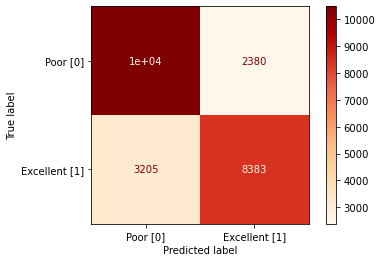

TN: 10484, FP: 2380, FN: 3205, TP: 8383
Accuracy: 0.77159
Recall: 0.72342
Precision: 0.77887
F1: 0.75012
ROC_AUC: 0.85022


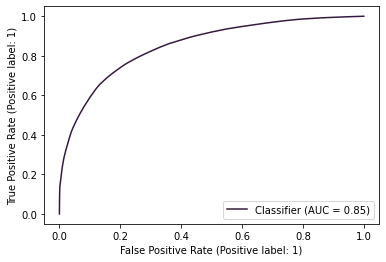

-------------------- Overall Test Result--------------------
Confusion Matrix:


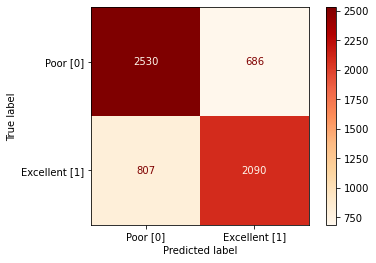

TN: 2530, FP: 686, FN: 807, TP: 2090
Accuracy: 0.75577
Recall: 0.72144
Precision: 0.75288
F1: 0.73682
ROC_AUC: 0.83861


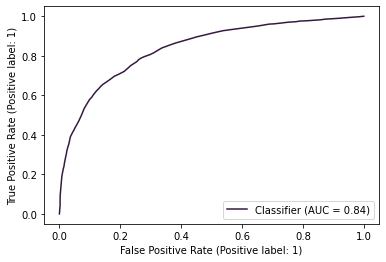

-------------------- Fold Result--------------------
Confusion Matrix:
[[471 172]
 [110 470]]
TN: 471, FP: 172, FN: 110, TP: 470
Accuracy: 0.76942
Recall: 0.81034
Precision: 0.73209
F1: 0.76923
ROC_AUC: 0.85219
-------------------- Fold Result--------------------
Confusion Matrix:
[[477 166]
 [147 433]]
TN: 477, FP: 166, FN: 147, TP: 433
Accuracy: 0.74407
Recall: 0.74655
Precision: 0.72287
F1: 0.73452
ROC_AUC: 0.83212
-------------------- Fold Result--------------------
Confusion Matrix:
[[545  99]
 [198 381]]
TN: 545, FP: 99, FN: 198, TP: 381
Accuracy: 0.75715
Recall: 0.65803
Precision: 0.79375
F1: 0.71955
ROC_AUC: 0.83803
-------------------- Fold Result--------------------
Confusion Matrix:
[[496 147]
 [160 419]]
TN: 496, FP: 147, FN: 160, TP: 419
Accuracy: 0.74877
Recall: 0.72366
Precision: 0.74028
F1: 0.73188
ROC_AUC: 0.82015
-------------------- Fold Result--------------------
Confusion Matrix:
[[541 102]
 [192 387]]
TN: 541, FP: 102, FN: 192, TP: 387
Accuracy: 0.75941
Recall: 0.

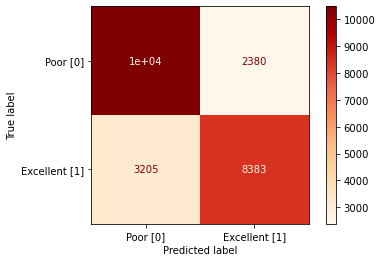

TN: 10484, FP: 2380, FN: 3205, TP: 8383
Accuracy: 0.77159
Recall: 0.72342
Precision: 0.77887
F1: 0.75012
ROC_AUC: 0.85022


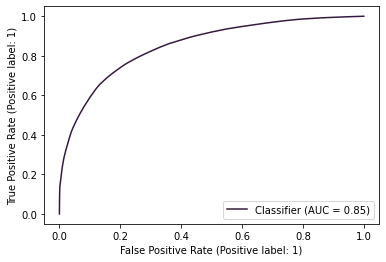

-------------------- Overall Test Result--------------------
Confusion Matrix:


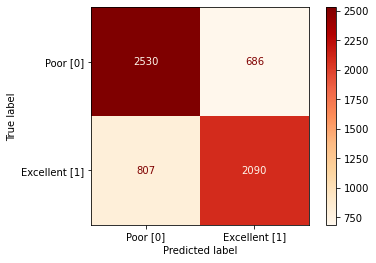

TN: 2530, FP: 686, FN: 807, TP: 2090
Accuracy: 0.75577
Recall: 0.72144
Precision: 0.75288
F1: 0.73682
ROC_AUC: 0.83861


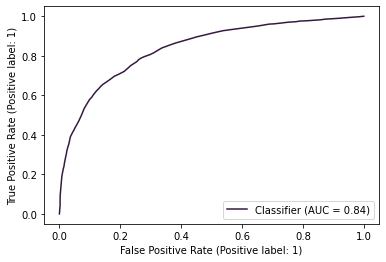

-------------------- Fold Result--------------------
Confusion Matrix:
[[471 172]
 [110 470]]
TN: 471, FP: 172, FN: 110, TP: 470
Accuracy: 0.76942
Recall: 0.81034
Precision: 0.73209
F1: 0.76923
ROC_AUC: 0.85219
-------------------- Fold Result--------------------
Confusion Matrix:
[[477 166]
 [147 433]]
TN: 477, FP: 166, FN: 147, TP: 433
Accuracy: 0.74407
Recall: 0.74655
Precision: 0.72287
F1: 0.73452
ROC_AUC: 0.83212
-------------------- Fold Result--------------------
Confusion Matrix:
[[545  99]
 [198 381]]
TN: 545, FP: 99, FN: 198, TP: 381
Accuracy: 0.75715
Recall: 0.65803
Precision: 0.79375
F1: 0.71955
ROC_AUC: 0.83803
-------------------- Fold Result--------------------
Confusion Matrix:
[[496 147]
 [160 419]]
TN: 496, FP: 147, FN: 160, TP: 419
Accuracy: 0.74877
Recall: 0.72366
Precision: 0.74028
F1: 0.73188
ROC_AUC: 0.82015
-------------------- Fold Result--------------------
Confusion Matrix:
[[541 102]
 [192 387]]
TN: 541, FP: 102, FN: 192, TP: 387
Accuracy: 0.75941
Recall: 0.

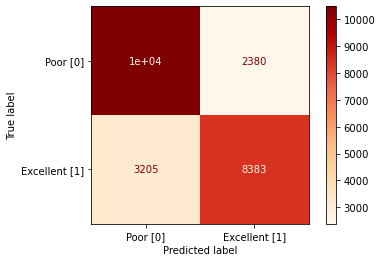

TN: 10484, FP: 2380, FN: 3205, TP: 8383
Accuracy: 0.77159
Recall: 0.72342
Precision: 0.77887
F1: 0.75012
ROC_AUC: 0.85022


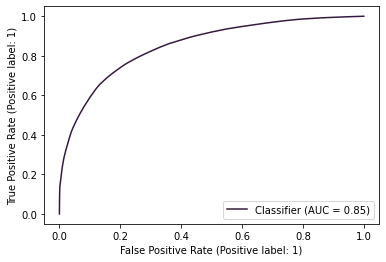

-------------------- Overall Test Result--------------------
Confusion Matrix:


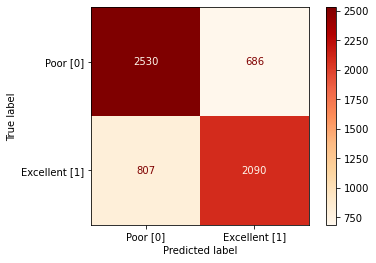

TN: 2530, FP: 686, FN: 807, TP: 2090
Accuracy: 0.75577
Recall: 0.72144
Precision: 0.75288
F1: 0.73682
ROC_AUC: 0.83861


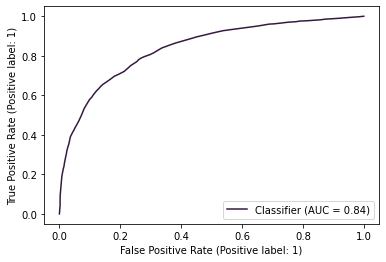

-------------------- Fold Result--------------------
Confusion Matrix:
[[471 172]
 [110 470]]
TN: 471, FP: 172, FN: 110, TP: 470
Accuracy: 0.76942
Recall: 0.81034
Precision: 0.73209
F1: 0.76923
ROC_AUC: 0.85219
-------------------- Fold Result--------------------
Confusion Matrix:
[[477 166]
 [147 433]]
TN: 477, FP: 166, FN: 147, TP: 433
Accuracy: 0.74407
Recall: 0.74655
Precision: 0.72287
F1: 0.73452
ROC_AUC: 0.83212
-------------------- Fold Result--------------------
Confusion Matrix:
[[545  99]
 [198 381]]
TN: 545, FP: 99, FN: 198, TP: 381
Accuracy: 0.75715
Recall: 0.65803
Precision: 0.79375
F1: 0.71955
ROC_AUC: 0.83803
-------------------- Fold Result--------------------
Confusion Matrix:
[[496 147]
 [160 419]]
TN: 496, FP: 147, FN: 160, TP: 419
Accuracy: 0.74877
Recall: 0.72366
Precision: 0.74028
F1: 0.73188
ROC_AUC: 0.82015
-------------------- Fold Result--------------------
Confusion Matrix:
[[541 102]
 [192 387]]
TN: 541, FP: 102, FN: 192, TP: 387
Accuracy: 0.75941
Recall: 0.

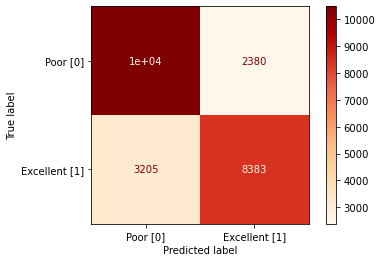

TN: 10484, FP: 2380, FN: 3205, TP: 8383
Accuracy: 0.77159
Recall: 0.72342
Precision: 0.77887
F1: 0.75012
ROC_AUC: 0.85022


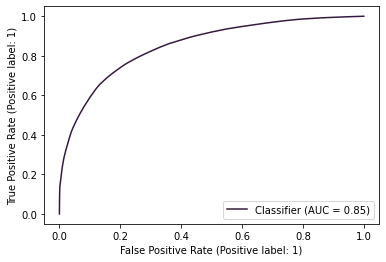

-------------------- Overall Test Result--------------------
Confusion Matrix:


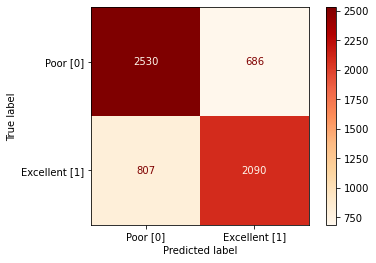

TN: 2530, FP: 686, FN: 807, TP: 2090
Accuracy: 0.75577
Recall: 0.72144
Precision: 0.75288
F1: 0.73682
ROC_AUC: 0.83861


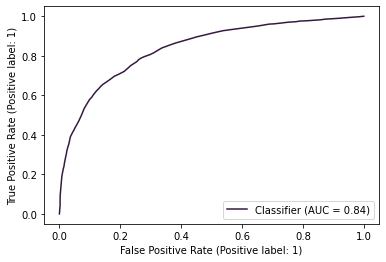

-------------------- Fold Result--------------------
Confusion Matrix:
[[471 172]
 [110 470]]
TN: 471, FP: 172, FN: 110, TP: 470
Accuracy: 0.76942
Recall: 0.81034
Precision: 0.73209
F1: 0.76923
ROC_AUC: 0.85219
-------------------- Fold Result--------------------
Confusion Matrix:
[[477 166]
 [147 433]]
TN: 477, FP: 166, FN: 147, TP: 433
Accuracy: 0.74407
Recall: 0.74655
Precision: 0.72287
F1: 0.73452
ROC_AUC: 0.83212
-------------------- Fold Result--------------------
Confusion Matrix:
[[545  99]
 [198 381]]
TN: 545, FP: 99, FN: 198, TP: 381
Accuracy: 0.75715
Recall: 0.65803
Precision: 0.79375
F1: 0.71955
ROC_AUC: 0.83803
-------------------- Fold Result--------------------
Confusion Matrix:
[[496 147]
 [160 419]]
TN: 496, FP: 147, FN: 160, TP: 419
Accuracy: 0.74877
Recall: 0.72366
Precision: 0.74028
F1: 0.73188
ROC_AUC: 0.82015
-------------------- Fold Result--------------------
Confusion Matrix:
[[541 102]
 [192 387]]
TN: 541, FP: 102, FN: 192, TP: 387
Accuracy: 0.75941
Recall: 0.

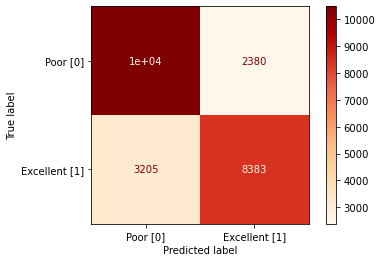

TN: 10484, FP: 2380, FN: 3205, TP: 8383
Accuracy: 0.77159
Recall: 0.72342
Precision: 0.77887
F1: 0.75012
ROC_AUC: 0.85022


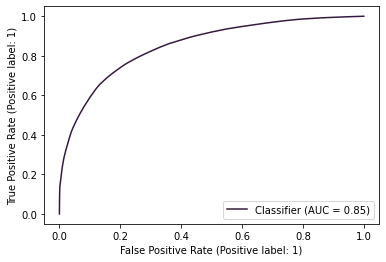

-------------------- Overall Test Result--------------------
Confusion Matrix:


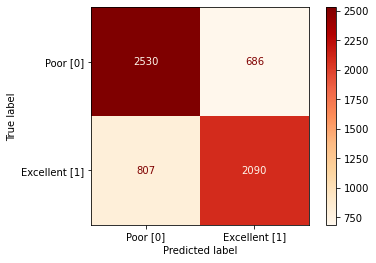

TN: 2530, FP: 686, FN: 807, TP: 2090
Accuracy: 0.75577
Recall: 0.72144
Precision: 0.75288
F1: 0.73682
ROC_AUC: 0.83861


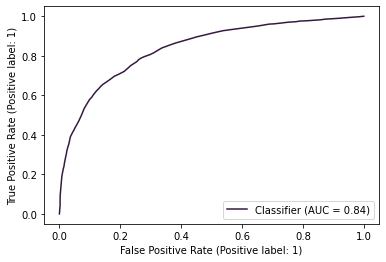

-------------------- Fold Result--------------------
Confusion Matrix:
[[471 172]
 [110 470]]
TN: 471, FP: 172, FN: 110, TP: 470
Accuracy: 0.76942
Recall: 0.81034
Precision: 0.73209
F1: 0.76923
ROC_AUC: 0.85219
-------------------- Fold Result--------------------
Confusion Matrix:
[[477 166]
 [147 433]]
TN: 477, FP: 166, FN: 147, TP: 433
Accuracy: 0.74407
Recall: 0.74655
Precision: 0.72287
F1: 0.73452
ROC_AUC: 0.83212
-------------------- Fold Result--------------------
Confusion Matrix:
[[545  99]
 [198 381]]
TN: 545, FP: 99, FN: 198, TP: 381
Accuracy: 0.75715
Recall: 0.65803
Precision: 0.79375
F1: 0.71955
ROC_AUC: 0.83803
-------------------- Fold Result--------------------
Confusion Matrix:
[[496 147]
 [160 419]]
TN: 496, FP: 147, FN: 160, TP: 419
Accuracy: 0.74877
Recall: 0.72366
Precision: 0.74028
F1: 0.73188
ROC_AUC: 0.82015
-------------------- Fold Result--------------------
Confusion Matrix:
[[541 102]
 [192 387]]
TN: 541, FP: 102, FN: 192, TP: 387
Accuracy: 0.75941
Recall: 0.

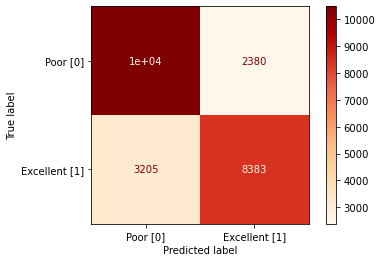

TN: 10484, FP: 2380, FN: 3205, TP: 8383
Accuracy: 0.77159
Recall: 0.72342
Precision: 0.77887
F1: 0.75012
ROC_AUC: 0.85022


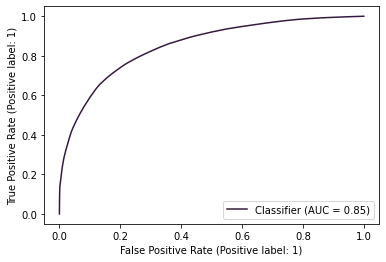

-------------------- Overall Test Result--------------------
Confusion Matrix:


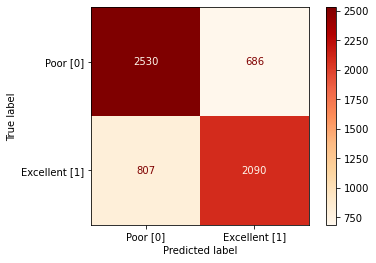

TN: 2530, FP: 686, FN: 807, TP: 2090
Accuracy: 0.75577
Recall: 0.72144
Precision: 0.75288
F1: 0.73682
ROC_AUC: 0.83861


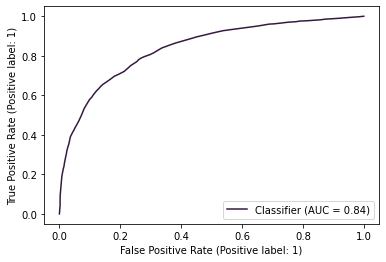

In [88]:
min_samples_leaf = []
roc_auc_train_list = []
roc_auc_test_list = []

# Create Decision Tree classifer object
for n in range(3, 20):
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=4, min_samples_leaf = n) #because max_depth = 4 gives the best score
    roc_auc_train, roc_auc_test = stratified_k_fold_model_fit(X, y, clf, splits=5, shuffle=True, verbose=True, plot_confusion_matrix=True, plot_roc=True, hide_fold_result=False, title=None)
    min_samples_leaf.append(n)
    roc_auc_train_list.append(roc_auc_train)
    roc_auc_test_list.append(roc_auc_test)

df_decision_tree = pd.DataFrame(list(zip(min_samples_leaf, roc_auc_train_list, roc_auc_test_list)), columns = ["min_samples_leaf", "roc_auc_train", "roc_auc_test"])

In [89]:
df_decision_tree #min_samples_leaf = 8 gives the best roc_auc_test scores

min_samples_leaf  roc_auc_train  roc_auc_test
0                  3       0.850357      0.838446
1                  4       0.850357      0.838473
2                  5       0.850357      0.838473
3                  6       0.850357      0.838473
4                  7       0.850357      0.838473
5                  8       0.850235      0.838923
6                  9       0.850219      0.838581
7                 10       0.850219      0.838581
8                 11       0.850219      0.838581
9                 12       0.850219      0.838608
10                13       0.850219      0.838608
11                14       0.850219      0.838608
12                15       0.850219      0.838608
13                16       0.850219      0.838608
14                17       0.850219      0.838608
15                18       0.850219      0.838608
16                19       0.850219      0.838608

-------------------- Overall Train Result--------------------
Confusion Matrix:


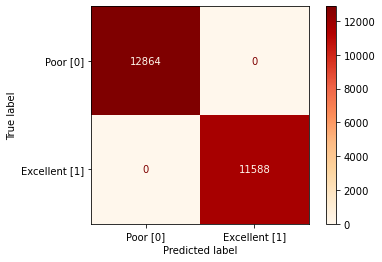

TN: 12864, FP: 0, FN: 0, TP: 11588
Accuracy: 1.00000
Recall: 1.00000
Precision: 1.00000
F1: 1.00000
ROC_AUC: 1.00000


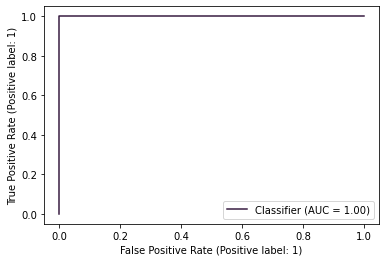

-------------------- Overall Test Result--------------------
Confusion Matrix:


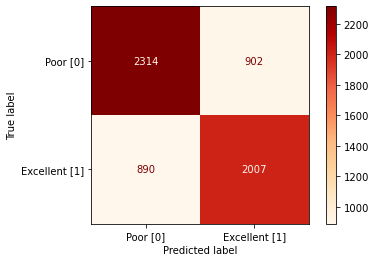

TN: 2314, FP: 902, FN: 890, TP: 2007
Accuracy: 0.70685
Recall: 0.69279
Precision: 0.68993
F1: 0.69135
ROC_AUC: 0.70616


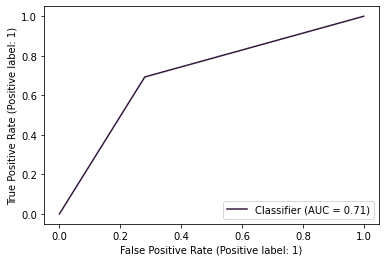

In [ ]:
roc_auc_train_ada_boost, roc_auc_test_ada_boost = stratified_k_fold_model_fit(X, y, base_decision_tree, 5, shuffle=True, hide_fold_result=True)

##### AdaBoost

In [ ]:
adaboost = AdaBoostClassifier(
    base_decision_tree,
    n_estimators=100,           # default
    algorithm='SAMME.R',
    random_state=2022,
)

-------------------- Overall Train Result--------------------
Confusion Matrix:


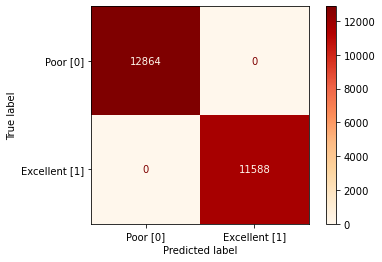

TN: 12864, FP: 0, FN: 0, TP: 11588
Accuracy: 1.00000
Recall: 1.00000
Precision: 1.00000
F1: 1.00000
ROC_AUC: 1.00000


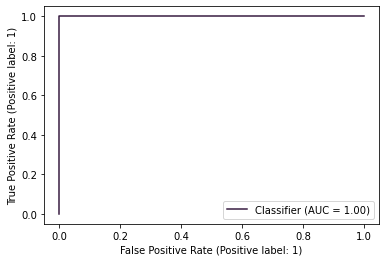

-------------------- Overall Test Result--------------------
Confusion Matrix:


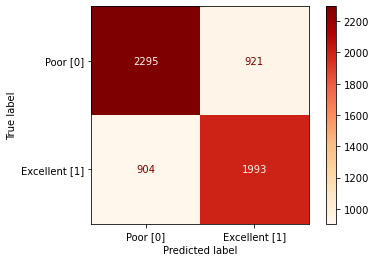

TN: 2295, FP: 921, FN: 904, TP: 1993
Accuracy: 0.70146
Recall: 0.68795
Precision: 0.68394
F1: 0.68594
ROC_AUC: 0.70079


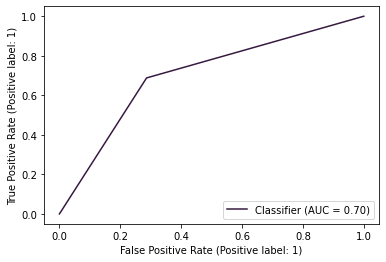

In [ ]:
roc_auc_train_ada_boost, roc_auc_test_ada_boost = stratified_k_fold_model_fit(X, y, adaboost, 5, shuffle=True, hide_fold_result=True)

##### Gradient Boosting

In [ ]:
gboost = GradientBoostingClassifier(
    n_estimators=100,           # default
    random_state=2022
)

-------------------- Overall Train Result--------------------
Confusion Matrix:


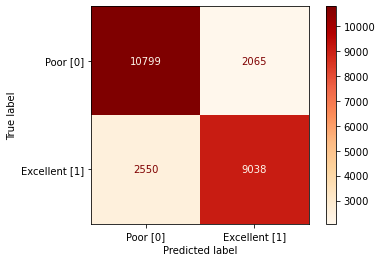

TN: 10799, FP: 2065, FN: 2550, TP: 9038
Accuracy: 0.81126
Recall: 0.77994
Precision: 0.81401
F1: 0.79662
ROC_AUC: 0.89953


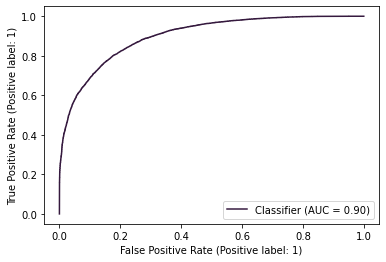

-------------------- Overall Test Result--------------------
Confusion Matrix:


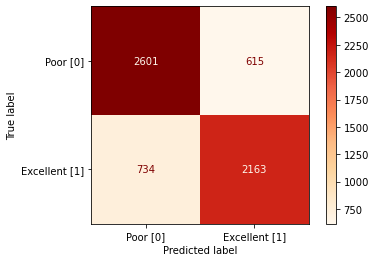

TN: 2601, FP: 615, FN: 734, TP: 2163
Accuracy: 0.77932
Recall: 0.74663
Precision: 0.77862
F1: 0.76229
ROC_AUC: 0.86054


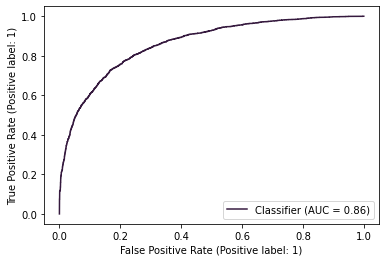

In [ ]:
roc_auc_train_gboost, roc_auc_test_gboost = stratified_k_fold_model_fit(X, y, gboost, 5, shuffle=True, hide_fold_result=True)

In [ ]:
# xgb = XGBClassifier(
#     n_estimators=100,
#     max_depth=None,
#     learning_rate=0.1,
#     booster="gbtree",
#     n_jobs=-1,
#     use_label_encoder=False,
#     random_state=2022
# )

In [ ]:
# roc_auc_train_xgboost, roc_auc_test_xgboost = stratified_k_fold_model_fit(X, y, xgb, 5, shuffle=True, hide_fold_result=True)

##### Random Forest

In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,           # default (to be tuned)
    max_depth=None,             # default (to be tuned)
    criterion="entropy",        # used in lecture
    random_state=2022,
    n_jobs=-1
)

-------------------- Fold Result--------------------
Confusion Matrix:
[[508 135]
 [133 447]]
TN: 508, FP: 135, FN: 133, TP: 447
Accuracy: 0.78087
Recall: 0.77069
Precision: 0.76804
F1: 0.76936
ROC_AUC: 0.86420
-------------------- Fold Result--------------------
Confusion Matrix:
[[519 124]
 [156 424]]
TN: 519, FP: 124, FN: 156, TP: 424
Accuracy: 0.77105
Recall: 0.73103
Precision: 0.77372
F1: 0.75177
ROC_AUC: 0.84479
-------------------- Fold Result--------------------
Confusion Matrix:
[[517 127]
 [162 417]]
TN: 517, FP: 127, FN: 162, TP: 417
Accuracy: 0.76370
Recall: 0.72021
Precision: 0.76654
F1: 0.74265
ROC_AUC: 0.84862
-------------------- Fold Result--------------------
Confusion Matrix:
[[499 144]
 [150 429]]
TN: 499, FP: 144, FN: 150, TP: 429
Accuracy: 0.75941
Recall: 0.74093
Precision: 0.74869
F1: 0.74479
ROC_AUC: 0.83948
-------------------- Fold Result--------------------
Confusion Matrix:
[[508 135]
 [140 439]]
TN: 508, FP: 135, FN: 140, TP: 439
Accuracy: 0.77496
Recall: 0

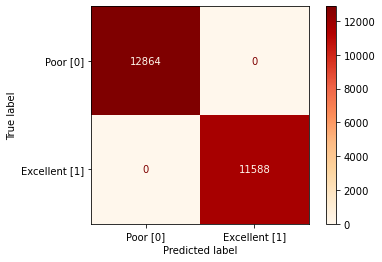

TN: 12864, FP: 0, FN: 0, TP: 11588
Accuracy: 1.00000
Recall: 1.00000
Precision: 1.00000
F1: 1.00000
ROC_AUC: 1.00000


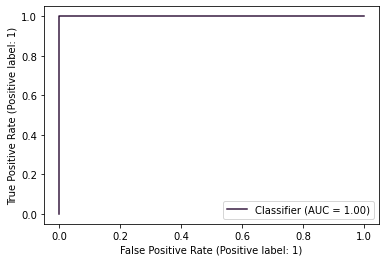

-------------------- Overall Test Result--------------------
Confusion Matrix:


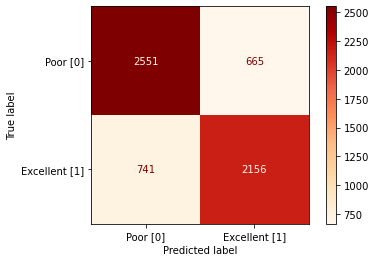

TN: 2551, FP: 665, FN: 741, TP: 2156
Accuracy: 0.77000
Recall: 0.74422
Precision: 0.76427
F1: 0.75411
ROC_AUC: 0.85015


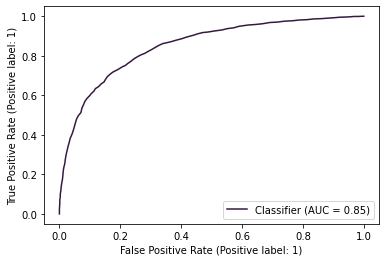

In [ ]:
roc_auc_train, roc_auc_test = stratified_k_fold_model_fit(X, y, rf, 5, shuffle=True, hide_fold_result=False)

<strong>Observations:</strong>
- Train AUC of 1.00 implies that model overfits train data since we did not limit the max_depth of the tree
- Fitting on Test data achieved a Cross Validated AUC_ROC of 0.769

### Hyper-Parameter Tuning to reduce Overfitting from Baseline Model

#### Tuning max_depth

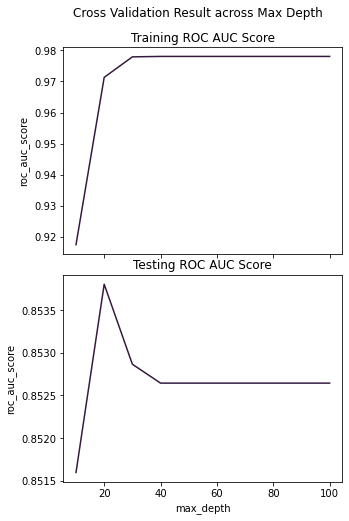

In [ ]:
df_max_depth_tuning = pd.DataFrame()

# Zoom into: 10 - 30

for n in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    clf = RandomForestClassifier(
                n_estimators=100,           # default
                max_depth=n,             # default
                max_features="auto",        # default
                min_samples_split=3,        # do not want too little data in one split
                min_samples_leaf=3,         # do not want too little data in one leaf node
                criterion="entropy",        # covered in lecture
                bootstrap=True,
                oob_score=True,
                random_state=2022,
                n_jobs=-1
    )
    
    roc_auc_train, roc_auc_test = stratified_k_fold_model_fit(X, y, clf, 5, shuffle=True, verbose=False, plot_confusion_matrix=False, hide_fold_result=True, plot_roc=False)

    df_max_depth_tuning = df_max_depth_tuning.append(
            pd.DataFrame({
                    'max_depth': [n],
                    'train': [roc_auc_train],
                    'test': [roc_auc_test],
            })
    )

df_max_depth_tuning.set_index("max_depth", inplace=True)
df_max_depth_tuning = df_max_depth_tuning.stack().reset_index().rename(columns={"level_1": "result", 0: "roc_auc_score"})

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(5,8))
fig.suptitle("Cross Validation Result across Max Depth", y=0.95)

sns.lineplot(
    ax=axes[0],
    data=df_max_depth_tuning[df_max_depth_tuning['result'] == 'train'],
    x='max_depth',
    y="roc_auc_score",
)
axes[0].set_title("Training ROC AUC Score")

sns.lineplot(
    ax=axes[1],
    data=df_max_depth_tuning[df_max_depth_tuning['result'] == 'test'],
    x='max_depth',
    y="roc_auc_score",
)
axes[1].set_title("Testing ROC AUC Score")

plt.subplots_adjust(hspace=0.1)
plt.show()

<strong>Observations:</strong>
- For both train and test data, we will be able to improve model performance by increasing the max_depth from 0 to 20.
- However as max_depth increases beyond 20, ROC AUC score of test data prediction decreases while that of the train data prediction increases which could imply that the model is over-fitting the training data.
- <strong>Optimal max_depth: 20</strong>

#### N_Estimators

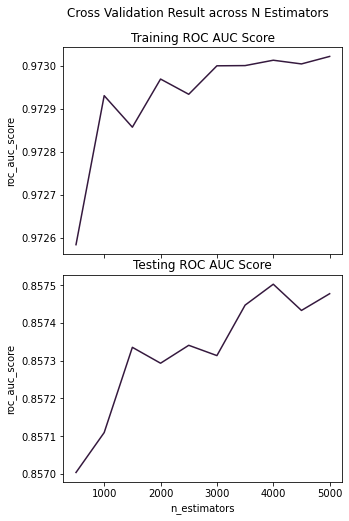

In [ ]:
df_n_estimators_tuning = pd.DataFrame()

for n in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]:
    clf = RandomForestClassifier(
                n_estimators=n,           # default
                max_depth=20,             # from earlier tuning
                max_features="auto",        # default
                min_samples_split=3,        # do not want too little data in one split
                min_samples_leaf=3,         # do not want too little data in one leaf node
                criterion="entropy",        # covered in lecture
                bootstrap=True,
                oob_score=True,
                random_state=2022,
                n_jobs=-1
    )
    
    roc_auc_train, roc_auc_test = stratified_k_fold_model_fit(X, y, clf, 5, shuffle=True, verbose=False, plot_confusion_matrix=False, hide_fold_result=True, plot_roc=False)

    df_n_estimators_tuning = df_n_estimators_tuning.append(
            pd.DataFrame({
                    'n_estimators': [n],
                    'train': [roc_auc_train],
                    'test': [roc_auc_test],
            })
    )

df_n_estimators_tuning.set_index("n_estimators", inplace=True)
df_n_estimators_tuning = df_n_estimators_tuning.stack().reset_index().rename(columns={"level_1": "result", 0: "roc_auc_score"})

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(5,8))
fig.suptitle("Cross Validation Result across N Estimators", y=0.95)

sns.lineplot(
    ax=axes[0],
    data=df_n_estimators_tuning[df_n_estimators_tuning['result'] == 'train'],
    x='n_estimators',
    y="roc_auc_score",
)
axes[0].set_title("Training ROC AUC Score")

sns.lineplot(
    ax=axes[1],
    data=df_n_estimators_tuning[df_n_estimators_tuning['result'] == 'test'],
    x='n_estimators',
    y="roc_auc_score",
)
axes[1].set_title("Testing ROC AUC Score")

plt.subplots_adjust(hspace=0.1)
plt.show()

<strong>Observations:</strong>
- <strong>Optimal n_estimators: 4000</strong>

#### min_samples_leaf

In [ ]:
df_min_samples_leaf_tuning = pd.DataFrame()

for n in [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    clf = RandomForestClassifier(
                n_estimators=4000,          # default
                max_depth=20,               # from earlier
                max_features="auto",        # default
                min_samples_split=3,        # do not want too little data in one split
                min_samples_leaf=n,         
                criterion="entropy",        # covered in lecture
                bootstrap=True,
                oob_score=True,
                random_state=2022,
                n_jobs=-1
    )
    
    roc_auc_train, roc_auc_test = stratified_k_fold_model_fit(X, y, clf, 5, shuffle=True, verbose=False, plot_confusion_matrix=False, hide_fold_result=True, plot_roc=False)

    df_min_samples_leaf_tuning = df_min_samples_leaf_tuning.append(
            pd.DataFrame({
                    'min_samples_leaf': [n],
                    'train': [roc_auc_train],
                    'test': [roc_auc_test],
            })
    )

df_min_samples_leaf_tuning.set_index("min_samples_leaf", inplace=True)
df_min_samples_leaf_tuning = df_min_samples_leaf_tuning.stack().reset_index().rename(columns={"level_1": "result", 0: "roc_auc_score"})

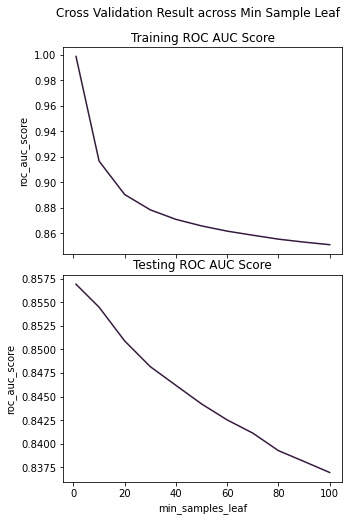

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(5,8))
fig.suptitle("Cross Validation Result across Min Sample Leaf", y=0.95)

sns.lineplot(
    ax=axes[0],
    data=df_min_samples_leaf_tuning[df_min_samples_leaf_tuning['result'] == 'train'],
    x='min_samples_leaf',
    y="roc_auc_score",
)
axes[0].set_title("Training ROC AUC Score")

sns.lineplot(
    ax=axes[1],
    data=df_min_samples_leaf_tuning[df_min_samples_leaf_tuning['result'] == 'test'],
    x='min_samples_leaf',
    y="roc_auc_score",
)
axes[1].set_title("Testing ROC AUC Score")

plt.subplots_adjust(hspace=0.1)
plt.show()

<strong>Observations:</strong>
- <strong>Optimal min_samples_leaf: 3</strong>

### Model after Basic Tuning

In [ ]:
rf2 = RandomForestClassifier(
    n_estimators=4000,           # default
    max_depth=20,             # default
    max_features="auto",        # default
    min_samples_leaf=3,         # do not want too little data in one leaf node
    criterion="entropy",        # covered in lecture
    bootstrap=True,
    oob_score=True,
    random_state=2022,
    n_jobs=-1
)

-------------------- Overall Train Result--------------------
Confusion Matrix:


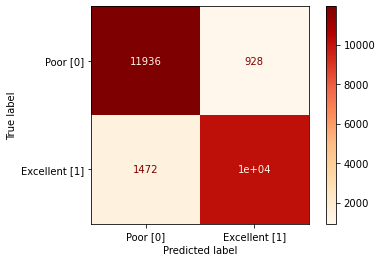

TN: 11936, FP: 928, FN: 1472, TP: 10116
Accuracy: 0.90185
Recall: 0.87297
Precision: 0.91597
F1: 0.89396
ROC_AUC: 0.97301


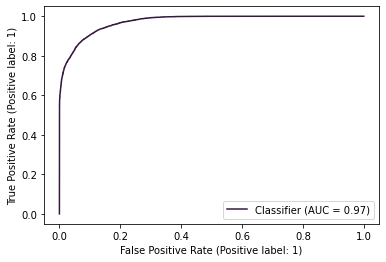

-------------------- Overall Test Result--------------------
Confusion Matrix:


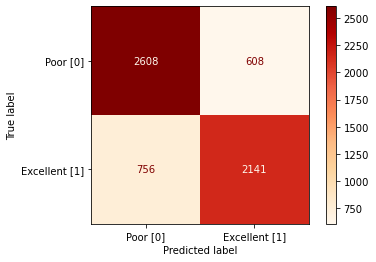

TN: 2608, FP: 608, FN: 756, TP: 2141
Accuracy: 0.77687
Recall: 0.73904
Precision: 0.77883
F1: 0.75841
ROC_AUC: 0.85750


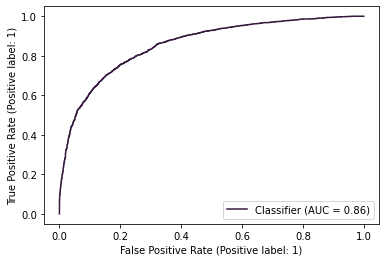

In [ ]:
roc_auc_train_2, roc_auc_test_2 = stratified_k_fold_model_fit(X, y, rf2, 5, shuffle=True, hide_fold_result=True)

<strong>Observations:</strong>
- Train AUC decreases from 1.00 to 0.91 thus reducing the issue of overfitting
- Test AUC improved from 0.768 to 0.777

### Analysing Feature Importances from Model

In [ ]:
df_feature_importance = pd.DataFrame(list(zip(X.columns, rf2.feature_importances_)), columns=['features', 'importance'])
df_feature_importance["feature_category"] = df_feature_importance["features"].map(dct_feature_category)
df_feature_importance['importance_pct'] = df_feature_importance['importance'] * 100

In [ ]:
df_feature_importance.sort_values('importance_pct', ascending=False).iloc[:20,:]

features  importance  \
99                    average_sentiment_score    0.373165   
100                   img_uploaded_per_review    0.078873   
104                          walking_distance    0.063035   
94                      total_operating_hours    0.034778   
23                             price_category    0.020649   
103                                is_in_mall    0.020224   
101                      is_travellors_choice    0.017860   
95                           num_of_days_open    0.012874   
70                       feature_reservations    0.010834   
86                   diet_gluten_free_options    0.009285   
83                               has_features    0.009172   
72                            feature_seating    0.009016   
68                               has_cuisines    0.008924   
88              nearest_train_line_color_blue    0.008766   
36                      nearby_attraction_nan    0.008717   
89             nearest_train_line_color_green    0.008717   
26                nearby_attraction_chinatown    0.008644   
82                   feature_creditcard_avail    0.008374   
105  above_median_dist_from_nearby_attraction    0.008361   
78                      feature_table_service    0.007211   

                             feature_category  importance_pct  
99                    Average Sentiment Score       37.316487  
100                   Img Uploaded Per Review        7.887317  
104                          Walking Distance        6.303478  
94                   Operating Hours Features        3.477811  
23                             Price Features        2.064945  
103                                Is In Mall        2.022409  
101                      Is Travellors Choice        1.786035  
95                   Operating Hours Features        1.287386  
70                                Feature OHE        1.083408  
86                                   Diet OHE        0.928484  
83                                Feature OHE        0.917162  
72                                Feature OHE        0.901640  
68                                Cuisine OHE        0.892432  
88            Nearest Train Station Color OHE        0.876645  
36                      Nearby Attraction OHE        0.871719  
89            Nearest Train Station Color OHE        0.871654  
26                      Nearby Attraction OHE        0.864404  
82                                Feature OHE        0.837400  
105  Above Median Dist From Nearby Attraction        0.836058  
78                                Feature OHE        0.721121

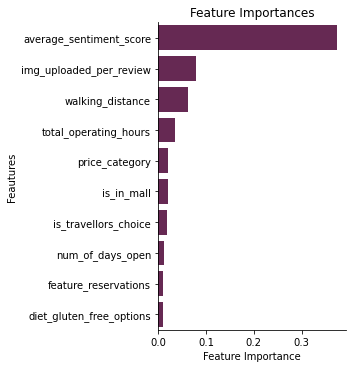

In [ ]:
ax = sns.catplot(
    y = 'features',
    x = 'importance',
    data = df_feature_importance.sort_values(by=['importance'], ascending=False).head(10),
    kind='bar',
    # hue='feature_category',
    color=hex_colors[1]
)

# ax.fig.gca().set(xlim=(3.5,4.1))
ax.fig.gca().set_title("Feature Importances")
ax.fig.gca().set_ylabel("Feautures")
ax.fig.gca().set_xlabel("Feature Importance")
plt.show()

<strong>Observations:</strong>
- Average Sentiment Score overwhelmingly outweighs the other features in the dataset.

In [ ]:
df_feature_importance.groupby(["feature_category"]).agg({"importance": ["min", "max", "mean"], "features": ["count"]}).sort_values(by=[("importance", "mean")], ascending=False)

importance                      \
                                                min       max      mean   
feature_category                                                          
Average Sentiment Score                    0.373165  0.373165  0.373165   
Img Uploaded Per Review                    0.078873  0.078873  0.078873   
Walking Distance                           0.063035  0.063035  0.063035   
Is In Mall                                 0.020224  0.020224  0.020224   
Is Travellors Choice                       0.017860  0.017860  0.017860   
Price Features                             0.006495  0.020649  0.013572   
Operating Hours Features                   0.004558  0.034778  0.012520   
Above Median Dist From Nearby Attraction   0.008361  0.008361  0.008361   
Nearest Train Station Color OHE            0.002871  0.008766  0.006357   
Diet OHE                                   0.001758  0.009285  0.005978   
Feature OHE                                0.000780  0.010834  0.005613   
Meal OHE                                   0.002947  0.005974  0.005091   
Nearby Attraction OHE                      0.001160  0.008717  0.003722   
Cuisine OHE                                0.000026  0.008924  0.003434   
Region OHE                                 0.001076  0.006410  0.002472   
Is Michellin                               0.001973  0.001973  0.001973   
Nearby Attraction Feature Cross            0.000283  0.002902  0.001455   

                                         features  
                                            count  
feature_category                                   
Average Sentiment Score                         1  
Img Uploaded Per Review                         1  
Walking Distance                                1  
Is In Mall                                      1  
Is Travellors Choice                            1  
Price Features                                  2  
Operating Hours Features                        5  
Above Median Dist From Nearby Attraction        1  
Nearest Train Station Color OHE                 6  
Diet OHE                                        4  
Feature OHE                                    15  
Meal OHE                                        7  
Nearby Attraction OHE                          13  
Cuisine OHE                                    13  
Region OHE                                     22  
Is Michellin                                    1  
Nearby Attraction Feature Cross                12

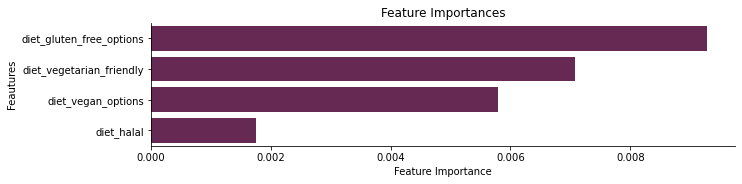

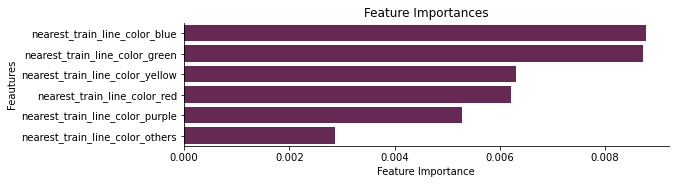

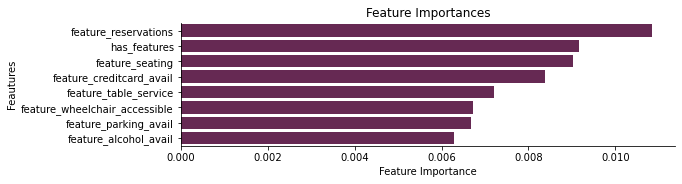

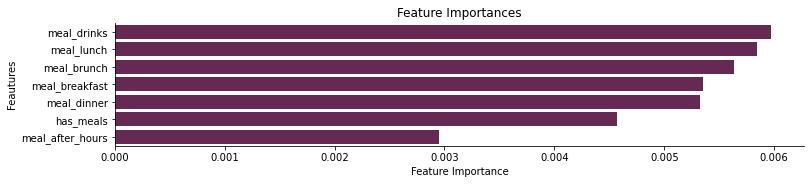

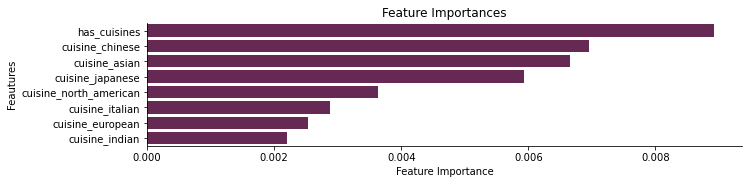

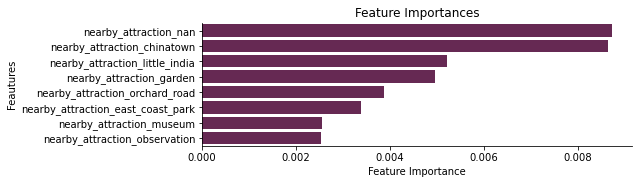

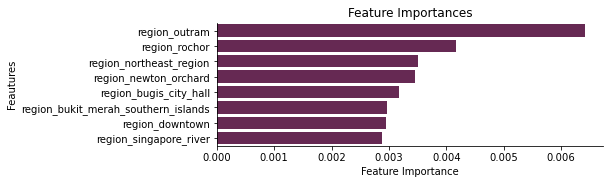

In [ ]:
for i in ["Diet OHE", "Nearest Train Station Color OHE", "Feature OHE", "Meal OHE", "Cuisine OHE", "Nearby Attraction OHE", "Region OHE"]:
    ax = sns.catplot(
        y = 'features',
        x = 'importance',
        data = df_feature_importance[df_feature_importance["feature_category"]==i].sort_values(by=['importance'], ascending=False).head(8),
        kind='bar',
        # hue='feature_category',
        color=hex_colors[1]
    )

    # ax.fig.gca().set(xlim=(3.5,4.1))
    ax.fig.set_figheight(2)
    ax.fig.set_figwidth(15)
    ax.fig.gca().set_title("Feature Importances")
    ax.fig.gca().set_ylabel("Feautures")
    ax.fig.gca().set_xlabel("Feature Importance")
    plt.show()

## 4. Selecting Most Important Features

In [ ]:
# ------------------- Feature Selection Cell --------------------- #

features_to_exclude = [
    # price features
    # 'has_price_category',
    # 'price_category',

    # other features
    # 'average_sentiment_score',
    # 'img_uploaded_per_review',
    # 'is_travellors_choice',
    'is_michellin',
    # 'is_in_mall',
    # 'walking_distance',
    # 'above_median_dist_from_nearby_attraction',
    
    # operating hours
    # 'total_operating_hours',
    # 'num_of_days_open',
    'operates_on_weekends',
    'operates_on_sat_or_sun',
    # 'has_operating_hours'
]

features_to_exclude.extend(nearby_attraction_feature_cross)
features_to_exclude.extend(train_station_ohe)
features_to_exclude.remove("nearest_train_line_color_green")
features_to_exclude.remove("nearest_train_line_color_blue")

features_to_exclude.extend(region_ohe)
features_to_exclude.remove("region_outram")

features_to_exclude.append("meal_after_hours")
features_to_exclude.append("has_meals")
# features_to_exclude.extend(meal_ohe)

cuisines_ohe_subset = cuisine_ohe.copy()
cuisines_ohe_subset.remove("has_cuisines")
cuisines_ohe_subset.remove("cuisine_chinese")
cuisines_ohe_subset.remove("cuisine_asian")
cuisines_ohe_subset.remove("cuisine_japanese")
features_to_exclude.extend(cuisines_ohe_subset)

nearby_attraction_ohe_subset = nearby_attraction_ohe.copy()
nearby_attraction_ohe_subset.remove("nearby_attraction_chinatown")
nearby_attraction_ohe_subset.remove("nearby_attraction_nan")
features_to_exclude.extend(nearby_attraction_ohe_subset)

# feature_ohe_subset = feature_ohe.copy()
# feature_ohe_subset.remove("feature_reservations")
# feature_ohe_subset.remove("has_features")
# feature_ohe_subset.remove("feature_seating")
# feature_ohe_subset.remove("feature_creditcard_avail")
# feature_ohe_subset.remove("feature_table_service")
# features_to_exclude.extend(feature_ohe)

# diet_ohe_subset = diet_ohe.copy()
# diet_ohe_subset.remove("diet_halal")
# features_to_exclude.extend(diet_ohe)
features_to_exclude.append("diet_halal")
features_to_exclude.append("diet_vegan_options")
features_to_exclude.append("diet_vegetarian_friendly")

### Model after Feature Selection

In [ ]:
X2 = X.drop(columns=features_to_exclude)

In [ ]:
X2.shape

(6113, 41)

In [ ]:
rf3 = RandomForestClassifier(
    n_estimators=4000,           # default
    max_depth=20,             # default
    max_features="auto",        # default
    min_samples_leaf=3,         # do not want too little data in one leaf node
    criterion="entropy",        # covered in lecture
    bootstrap=True,
    oob_score=True,
    random_state=2022,
    n_jobs=-1
)

-------------------- Overall Train Result--------------------
Confusion Matrix:


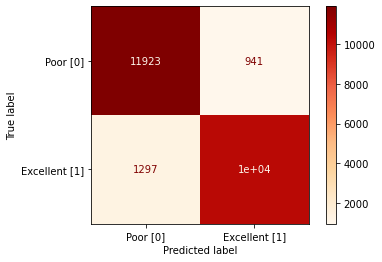

TN: 11923, FP: 941, FN: 1297, TP: 10291
Accuracy: 0.90847
Recall: 0.88807
Precision: 0.91622
F1: 0.90193
ROC_AUC: 0.97661


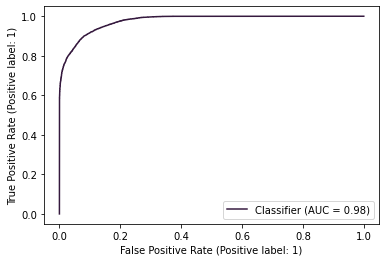

-------------------- Overall Test Result--------------------
Confusion Matrix:


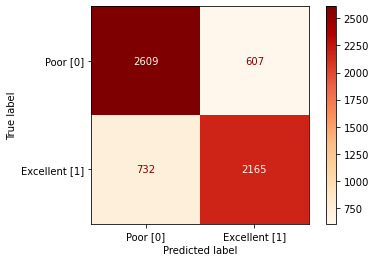

TN: 2609, FP: 607, FN: 732, TP: 2165
Accuracy: 0.78096
Recall: 0.74732
Precision: 0.78102
F1: 0.76380
ROC_AUC: 0.86031


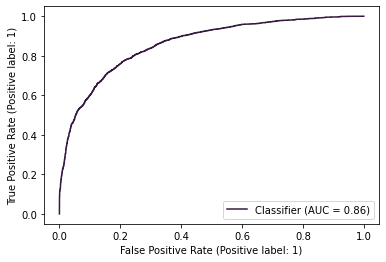

In [ ]:
roc_auc_train_3, roc_auc_test_3 = stratified_k_fold_model_fit(X2, y, rf3, 5, shuffle=True, hide_fold_result=True)

In [ ]:
X2.columns

Index(['region_outram', 'has_price_category', 'price_category',
       'nearby_attraction_chinatown', 'nearby_attraction_nan', 'meal_lunch',
       'meal_dinner', 'meal_drinks', 'meal_breakfast', 'meal_brunch',
       'cuisine_asian', 'cuisine_chinese', 'cuisine_japanese', 'has_cuisines',
       'feature_delivery', 'feature_reservations', 'feature_outdoor_seating',
       'feature_seating', 'feature_highchairs_available',
       'feature_digital_payments', 'feature_free_wifi', 'feature_cash_only',
       'feature_wheelchair_accessible', 'feature_table_service',
       'feature_live_music', 'feature_parking_avail', 'feature_alcohol_avail',
       'feature_creditcard_avail', 'has_features', 'diet_gluten_free_options',
       'nearest_train_line_color_blue', 'nearest_train_line_color_green',
       'total_operating_hours', 'num_of_days_open', 'has_operating_hours',
       'average_sentiment_score', 'img_uploaded_per_review',
       'is_travellors_choice', 'is_in_mall', 'walking_distance',

In [ ]:
df_feature_importance_2 = pd.DataFrame(list(zip(X2.columns, rf3.feature_importances_)), columns=['features', 'importance'])
df_feature_importance_2['importance_pct'] = df_feature_importance_2['importance'] * 100

In [ ]:
df_feature_importance_2.sort_values('importance_pct', ascending=False)

features  importance  importance_pct
35                   average_sentiment_score    0.424648       42.464754
36                   img_uploaded_per_review    0.103714       10.371434
39                          walking_distance    0.089427        8.942714
32                     total_operating_hours    0.044822        4.482186
2                             price_category    0.023457        2.345708
38                                is_in_mall    0.022105        2.210461
37                      is_travellors_choice    0.018580        1.857961
33                          num_of_days_open    0.016375        1.637520
40  above_median_dist_from_nearby_attraction    0.013656        1.365596
31            nearest_train_line_color_green    0.013379        1.337897
15                      feature_reservations    0.012943        1.294251
13                              has_cuisines    0.011812        1.181150
4                      nearby_attraction_nan    0.011663        1.166320
30             nearest_train_line_color_blue    0.011431        1.143132
28                              has_features    0.010316        1.031638
17                           feature_seating    0.009915        0.991480
29                  diet_gluten_free_options    0.009686        0.968560
3                nearby_attraction_chinatown    0.009583        0.958266
11                           cuisine_chinese    0.009381        0.938105
10                             cuisine_asian    0.008953        0.895349
27                  feature_creditcard_avail    0.008656        0.865560
23                     feature_table_service    0.008414        0.841378
22             feature_wheelchair_accessible    0.008212        0.821232
5                                 meal_lunch    0.007883        0.788305
1                         has_price_category    0.007871        0.787055
12                          cuisine_japanese    0.007608        0.760826
26                     feature_alcohol_avail    0.007375        0.737506
6                                meal_dinner    0.007056        0.705621
9                                meal_brunch    0.007052        0.705223
25                     feature_parking_avail    0.006799        0.679895
0                              region_outram    0.006514        0.651440
8                             meal_breakfast    0.006482        0.648179
34                       has_operating_hours    0.006190        0.619049
7                                meal_drinks    0.006059        0.605929
16                   feature_outdoor_seating    0.004877        0.487706
20                         feature_free_wifi    0.004610        0.460984
18              feature_highchairs_available    0.004228        0.422798
14                          feature_delivery    0.003897        0.389728
19                  feature_digital_payments    0.002151        0.215060
21                         feature_cash_only    0.001327        0.132662
24                        feature_live_music    0.000894        0.089383

### Bayesian Optimisation Hyperparameter Tuning

In [ ]:
rf4 = RandomForestClassifier(
    max_features="auto",        # default
    min_samples_leaf=3,         # do not want too little data in one leaf node
    bootstrap=True,
    oob_score=True,
    random_state=2022,
    n_jobs=-1
)

In [ ]:
def hyperopt(X, Y, classifier, param_space, num_eval, splits=5, shuffle=False, verbose=True):
    '''
    Function to perform Bayesian Optimisation Hyper-Param Tuning
    '''
    start = time()
    def objective_function(params):
        clf = classifier(**params)
        train_score, test_score = stratified_k_fold_model_fit(X, Y, 
                                                                clf, 
                                                                splits=splits, 
                                                                shuffle=shuffle, 
                                                                plot_confusion_matrix=False, 
                                                                plot_roc=False, 
                                                                hide_fold_result=True, 
                                                                verbose=False)

        return {'loss': -test_score, 'status': STATUS_OK}
    trials = Trials()
    best_param = fmin(objective_function, param_space, algo=tpe.suggest, max_evals=num_eval, 
                      trials=trials, rstate= np.random.RandomState(1))
    loss = [x['result']['loss'] for x in trials.trials] 
    best_param_values = best_param
    # print(loss)
    return trials, best_param_values

In [ ]:
def format_bayes_trial_df(model):
    '''
    Function to visualise Hyper-Parameter Tuning Trials
    '''
    trials = model[0].trials
    record = []
    losses = []
    for trial in trials:
        loss = trial["result"]["loss"]
        values = trial["misc"]['vals']
        losses.append(loss)
        record.append(values)
        
    bayesTrialsData = pd.DataFrame(record)
    bayesTrialsData.insert(0, 'loss', losses)
    non_loss_col = list(bayesTrialsData.columns)
    non_loss_col.remove('loss')
    for col in non_loss_col:
        bayesTrialsData[col] = bayesTrialsData[col].apply(
            lambda x: x[0]
        )
    return bayesTrialsData

In [ ]:
param = {
    # Untuned Param
    'max_features': hp.choice('max_features', ['auto']),
    'random_state': hp.choice('random_state', [2022]),
    'n_jobs': hp.choice('n_jobs', [-1]),
    'oob_score': hp.choice('oob_score', [True]),
    'bootstrap': hp.choice('bootstrap', [True]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [3]),
    
    # Tuned Param
    'criterion': hp.choice('criterion', ['entropy','gini']),
    'max_depth': scope.int(hp.quniform('max_depth', 20, 25, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 3700, 4300, 100)),
}

In [ ]:
num_eval = 5

load = False #put load = True if you don't want to load the whole thing again
if(load == False):
    hyperopt_rf_results = hyperopt(X2, y, RandomForestClassifier, param, num_eval, shuffle=True)
    save_file('models/hyperopt_rf.pkl', hyperopt_rf_results)
else:
    try:
        hyperopt_rf_results = load_file('models/hyperopt_rf.pkl')
    except Exception as e:
        print(e)

100%|██████████| 5/5 [04:45<00:00, 57.18s/trial, best loss: -0.8604186308705009]


In [ ]:
df_hyperopt_rf_results = format_bayes_trial_df(hyperopt_rf_results)
df_hyperopt_rf_results

loss  bootstrap  criterion  max_depth  max_features  min_samples_leaf  \
0 -0.859188          0          1       23.0             0                 0   
1 -0.859418          0          1       20.0             0                 0   
2 -0.860419          0          0       22.0             0                 0   
3 -0.859413          0          1       20.0             0                 0   
4 -0.860419          0          0       22.0             0                 0   

   n_estimators  n_jobs  oob_score  random_state  
0        3800.0       0          0             0  
1        4100.0       0          0             0  
2        4100.0       0          0             0  
3        4200.0       0          0             0  
4        4100.0       0          0             0

In [ ]:
# from sklearn.model_selection import GridSearchCV

In [ ]:
# rf4 = RandomForestClassifier(
#     min_samples_leaf=3,         # do not want too little data in one leaf node
#     criterion='entropy',
#     bootstrap=True,
#     oob_score=True,
#     random_state=2022,
#     n_jobs=-1
# )

In [ ]:
# param_grid = {  
#     'n_estimators': [x for x in range(2000, 2600, 50)],
#     'max_depth': [x for x in range(18, 23)],
#     'max_features': [x for x in range(10, 40, 5)],
# }

# gridsearch_rf = GridSearchCV(
#     estimator=rf4,
#     param_grid=param_grid,
#     n_jobs=-1,
#     scoring='roc_auc',
#     cv=5
# )

In [ ]:
# roc_auc_train_grid_search, roc_auc_test_grid_search = stratified_k_fold_model_fit(X2, y, gridsearch_rf, 5, shuffle=True, hide_fold_result=True)

## 5. Analysing Feature Splits

### "Uncontrollable" But Most Significant Features
- average_sentiment_score
- img_uploaded_per_review

In [ ]:
X_sub_1 = X[["average_sentiment_score", "img_uploaded_per_review"]].copy()

In [ ]:
rf_sub_1 = RandomForestClassifier(
    n_estimators=2500,           
    max_depth=3,             
    max_features="auto",      
    min_samples_leaf=3,       
    criterion="entropy",  
    bootstrap=True,
    oob_score=True,
    random_state=2022,
    n_jobs=-1
)

-------------------- Overall Train Result--------------------
Confusion Matrix:


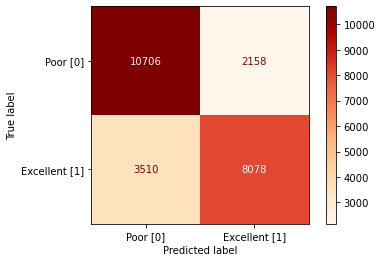

TN: 10706, FP: 2158, FN: 3510, TP: 8078
Accuracy: 0.76820
Recall: 0.69710
Precision: 0.78918
F1: 0.74029
ROC_AUC: 0.76467


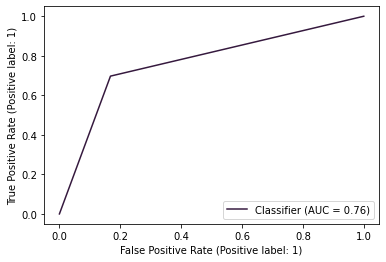

-------------------- Overall Test Result--------------------
Confusion Matrix:


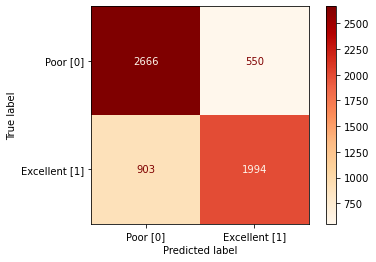

TN: 2666, FP: 550, FN: 903, TP: 1994
Accuracy: 0.76231
Recall: 0.68830
Precision: 0.78381
F1: 0.73295
ROC_AUC: 0.75864


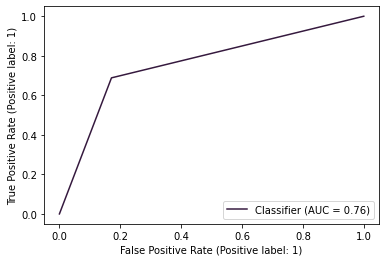

In [ ]:
roc_auc_train_sub_1, roc_auc_test_sub_2 = stratified_k_fold_model_fit(X_sub_1, y, rf_sub_1, 5, shuffle=True, plot_confusion_matrix=False, plot_roc=False, hide_fold_result=True)

In [ ]:
# Write the decision tree as a dot file
visual_tree = rf_sub_1.estimators_[0]
export_graphviz(visual_tree, out_file = 'image/random_forest_sub_1.dot', feature_names = X_sub_1.columns, 
                precision = 2, filled = True, rounded = True, max_depth = None)

# Import the dot file to a graph and then convert to a png
(graph, ) = pydot.graph_from_dot_file('image/random_forest_sub_1.dot')

# MacOs need to brew install gprof2dot
graph.write_png('image/random_forest_sub_1.png')

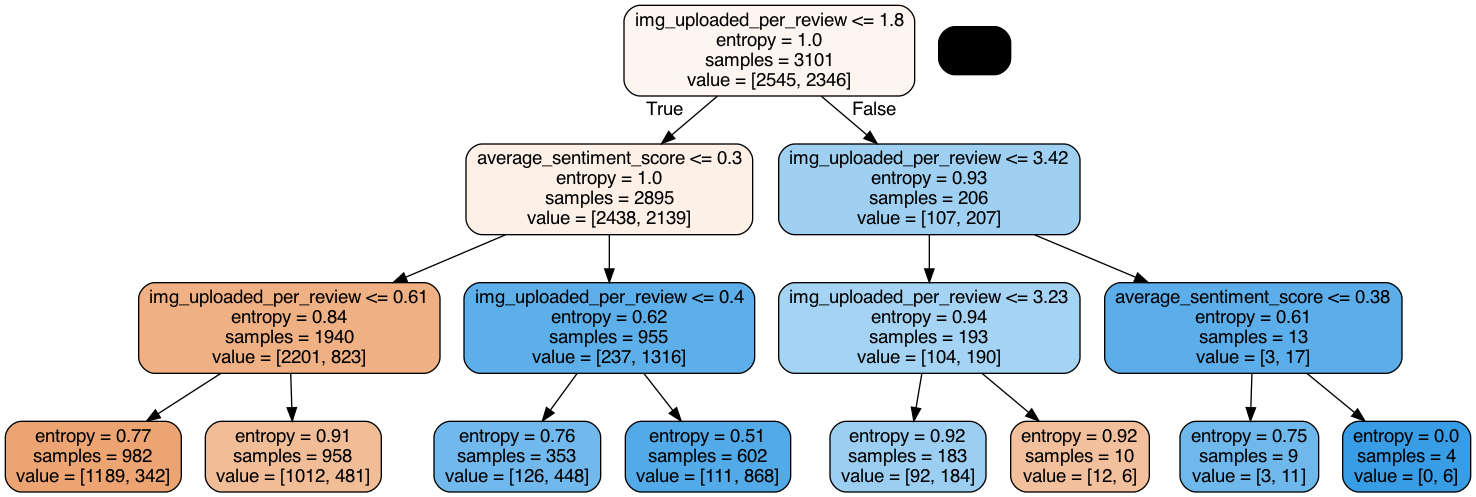

In [ ]:
Image('image/random_forest_sub_1.png') 

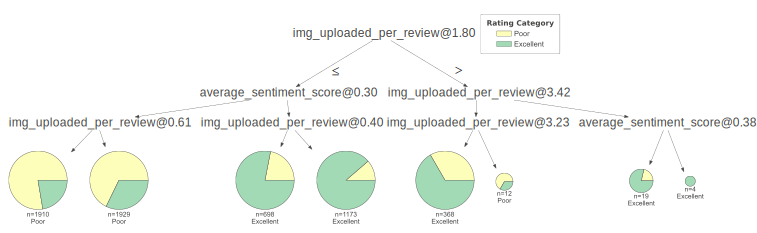

In [ ]:
viz = dtreeviz(
    rf_sub_1.estimators_[0], 
    X_sub_1, y['average_rating_category'],
    target_name="Rating Category",
    feature_names=X_sub_1.columns,
    class_names=["Poor", "Excellent"],
    fancy=False,
)

viz

### Most Important "Controllable" Features
1. Locational Features
- walking_distance
- is_in_mall
- above_median_dist_from_nearby_attraction
2. Operating Hours Features
- total_operating_hours
- num_of_days_open
3. Price and Other Services Features
- price_category
- feature_reservations

In [ ]:
X_sub_2 = X[["walking_distance", 
                "is_in_mall", 
                "above_median_dist_from_nearby_attraction",
                "nearest_train_line_color_green",
                "nearest_train_line_color_blue"]].copy()

rf_sub_2 = RandomForestClassifier(
    n_estimators=2500,           
    max_depth=5,
    max_features="auto",      
    min_samples_leaf=3,       
    criterion="entropy",  
    bootstrap=True,
    oob_score=True,
    random_state=2022,
    n_jobs=-1
)

roc_auc_train_sub_2, roc_auc_test_sub_2 = stratified_k_fold_model_fit(X_sub_2, y, rf_sub_2, 5, shuffle=True,plot_confusion_matrix=False, plot_roc=False, hide_fold_result=True)

-------------------- Overall Train Result--------------------
Confusion Matrix:
[[8568 4296]
 [5276 6312]]
TN: 8568, FP: 4296, FN: 5276, TP: 6312
Accuracy: 0.60854
Recall: 0.54470
Precision: 0.59502
F1: 0.56875
ROC_AUC: 0.60537
-------------------- Overall Test Result--------------------
Confusion Matrix:
[[2050 1166]
 [1422 1475]]
TN: 2050, FP: 1166, FN: 1422, TP: 1475
Accuracy: 0.57664
Recall: 0.50915
Precision: 0.55850
F1: 0.53268
ROC_AUC: 0.57329


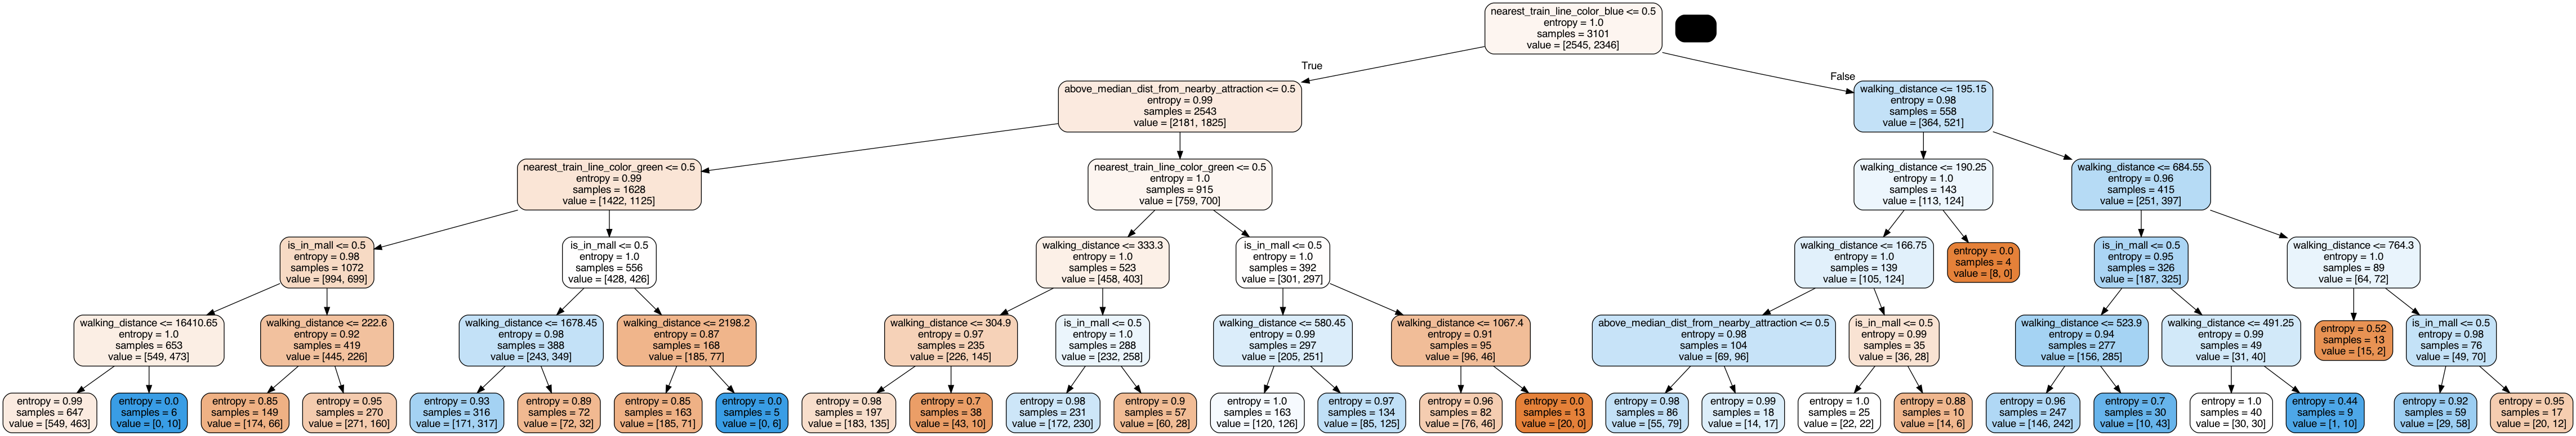

In [ ]:
# Write the decision tree as a dot file
visual_tree = rf_sub_2.estimators_[0]
export_graphviz(visual_tree, out_file = 'image/random_forest_sub_2.dot', feature_names = X_sub_2.columns, 
                precision = 2, filled = True, rounded = True, max_depth = None)

# Import the dot file to a graph and then convert to a png
(graph, ) = pydot.graph_from_dot_file('image/random_forest_sub_2.dot')

# MacOs need to brew install gprof2dot
graph.write_png('image/random_forest_sub_2.png')

Image('image/random_forest_sub_2.png') 

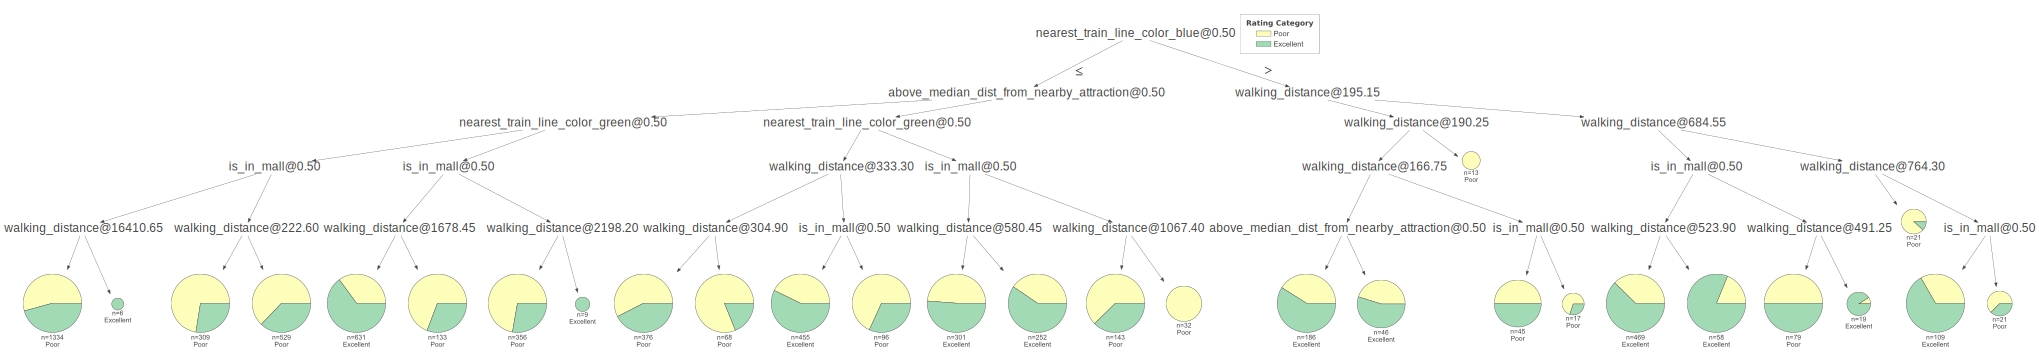

In [ ]:
viz_2 = dtreeviz(
    rf_sub_2.estimators_[0], 
    X_sub_2, y['average_rating_category'],
    target_name="Rating Category",
    feature_names=X_sub_2.columns,
    class_names=["Poor", "Excellent"],
    fancy=False,
)

viz_2

In [ ]:
X_sub_3 = X[["price_category", "has_cuisines", "cuisine_chinese", "cuisine_asian", "cuisine_japanese"]].copy()

rf_sub_3 = RandomForestClassifier(
    n_estimators=2500,           
    # max_depth=5,
    max_features="auto",      
    min_samples_leaf=3,       
    criterion="entropy",  
    bootstrap=True,
    oob_score=True,
    random_state=2022,
    n_jobs=-1
)

roc_auc_train_sub_3, roc_auc_test_sub_3 = stratified_k_fold_model_fit(X_sub_3, y, rf_sub_3, 5, shuffle=True, plot_confusion_matrix=False, plot_roc=False, hide_fold_result=True)

-------------------- Overall Train Result--------------------
Confusion Matrix:
[[10684  2180]
 [ 8624  2964]]
TN: 10684, FP: 2180, FN: 8624, TP: 2964
Accuracy: 0.55815
Recall: 0.25578
Precision: 0.57621
F1: 0.35429
ROC_AUC: 0.54316
-------------------- Overall Test Result--------------------
Confusion Matrix:
[[2636  580]
 [2182  715]]
TN: 2636, FP: 580, FN: 2182, TP: 715
Accuracy: 0.54818
Recall: 0.24681
Precision: 0.55212
F1: 0.34113
ROC_AUC: 0.53323


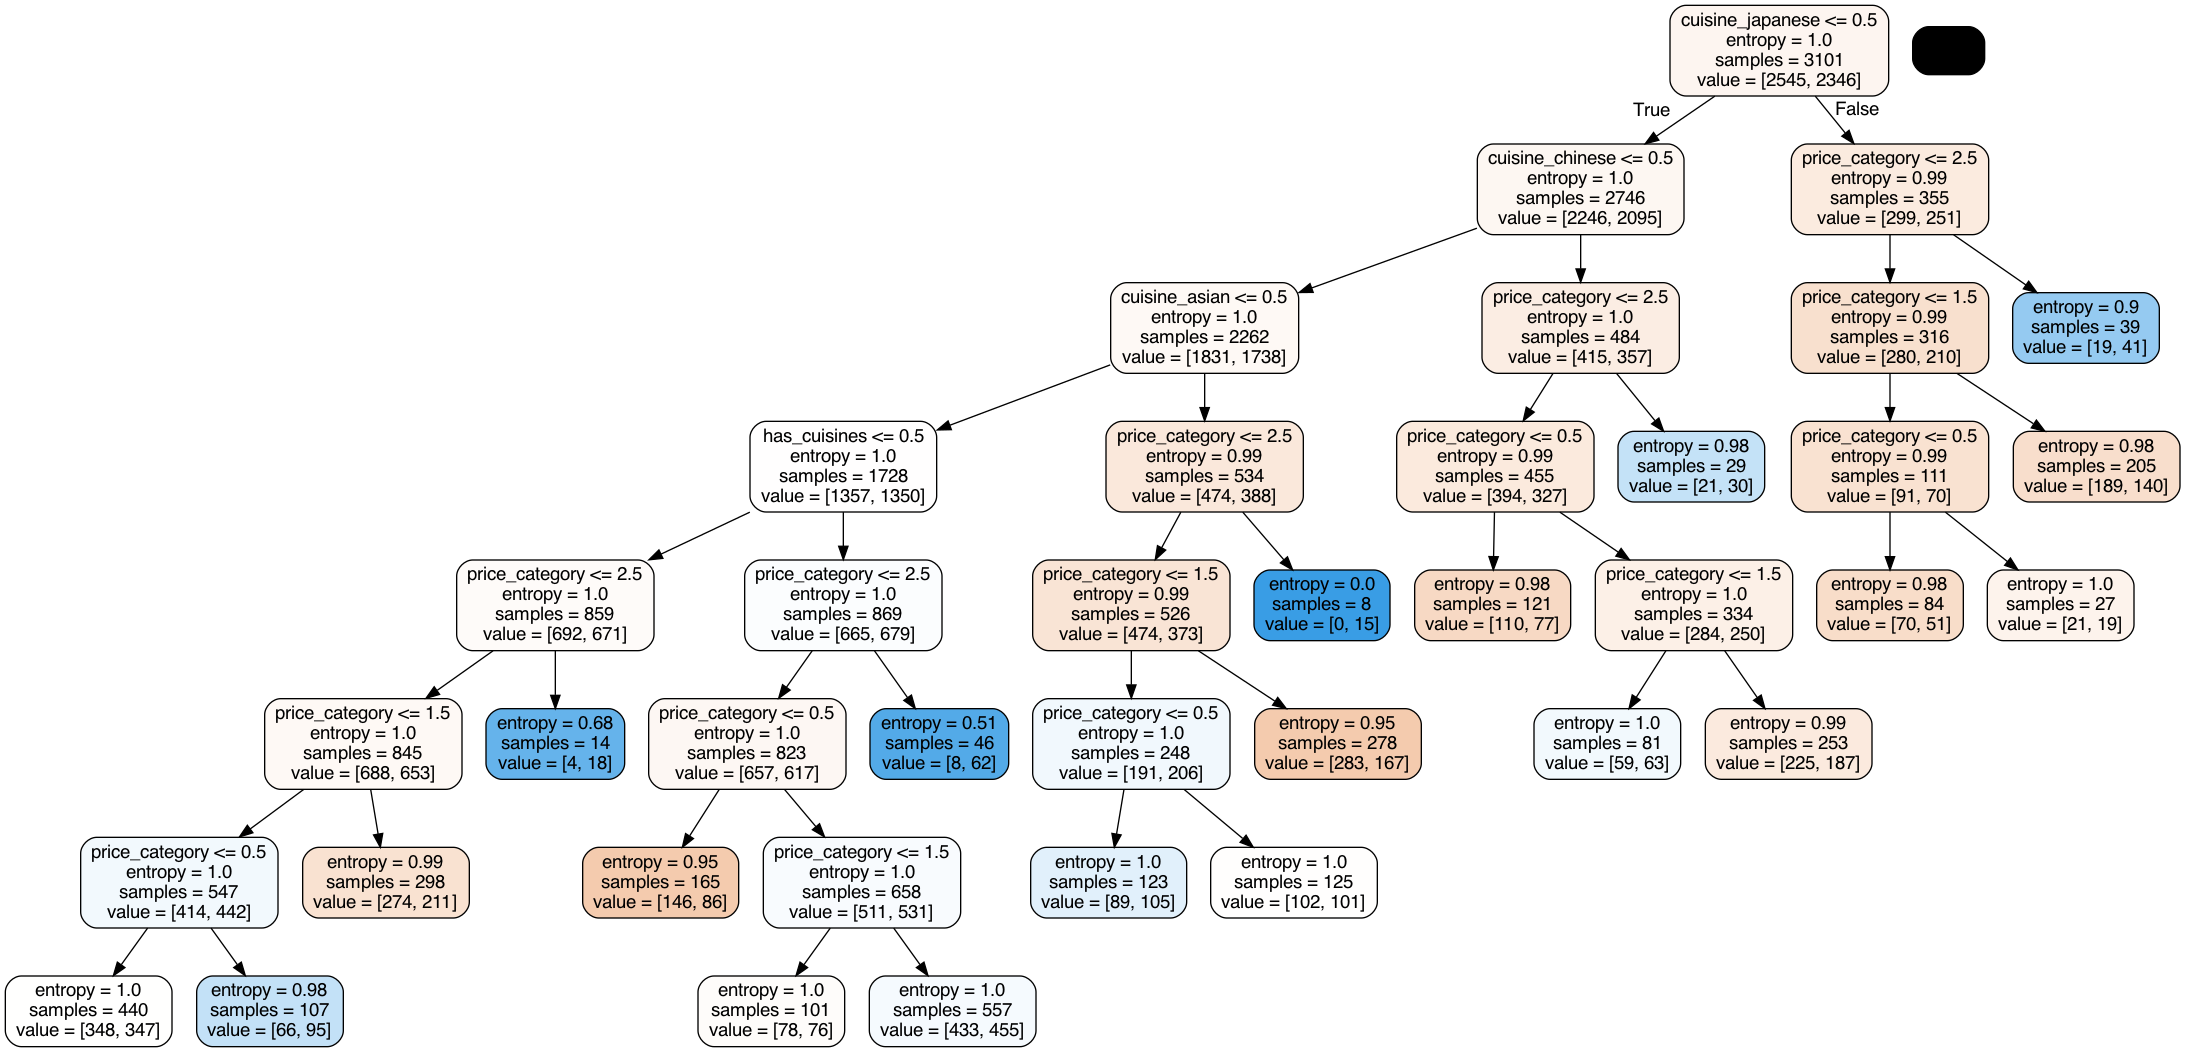

In [ ]:
# Write the decision tree as a dot file
visual_tree = rf_sub_3.estimators_[0]
export_graphviz(visual_tree, out_file = 'image/random_forest_sub_3.dot', feature_names = X_sub_3.columns, 
                precision = 2, filled = True, rounded = True, max_depth = None)

# Import the dot file to a graph and then convert to a png
(graph, ) = pydot.graph_from_dot_file('image/random_forest_sub_3.dot')

# MacOs need to brew install gprof2dot
graph.write_png('image/random_forest_sub_3.png')

Image('image/random_forest_sub_3.png') 

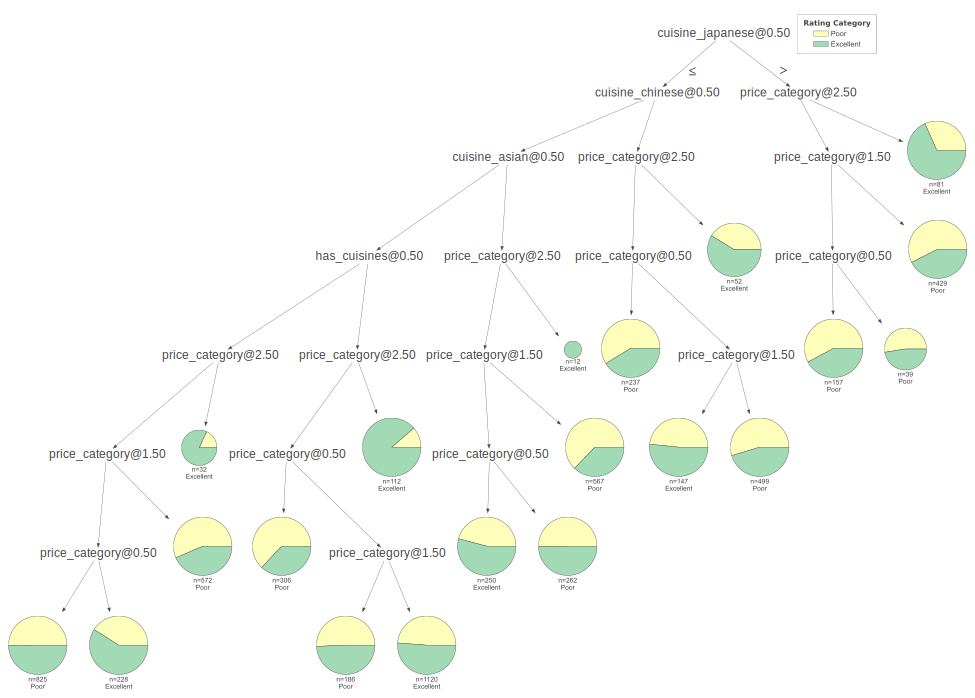

In [ ]:
viz_3 = dtreeviz(
    rf_sub_3.estimators_[0], 
    X_sub_3, y['average_rating_category'],
    target_name="Rating Category",
    feature_names=X_sub_3.columns,
    class_names=["Poor", "Excellent"],
    fancy=False,
)

viz_3

In [ ]:
X_sub_4 = X[["total_operating_hours", "num_of_days_open"]].copy()

rf_sub_4 = RandomForestClassifier(
    n_estimators=2500,           
    max_depth=5,
    max_features="auto",      
    min_samples_leaf=3,       
    criterion="entropy",  
    bootstrap=True,
    oob_score=True,
    random_state=2022,
    n_jobs=-1
)

roc_auc_train_sub_4, roc_auc_test_sub_4 = stratified_k_fold_model_fit(X_sub_4, y, rf_sub_4, 5, shuffle=True, plot_confusion_matrix=False, plot_roc=False, hide_fold_result=True)

-------------------- Overall Train Result--------------------
Confusion Matrix:
[[10376  2488]
 [ 7535  4053]]
TN: 10376, FP: 2488, FN: 7535, TP: 4053
Accuracy: 0.59009
Recall: 0.34976
Precision: 0.61963
F1: 0.44713
ROC_AUC: 0.57818
-------------------- Overall Test Result--------------------
Confusion Matrix:
[[2561  655]
 [1915  982]]
TN: 2561, FP: 655, FN: 1915, TP: 982
Accuracy: 0.57958
Recall: 0.33897
Precision: 0.59988
F1: 0.43317
ROC_AUC: 0.56765


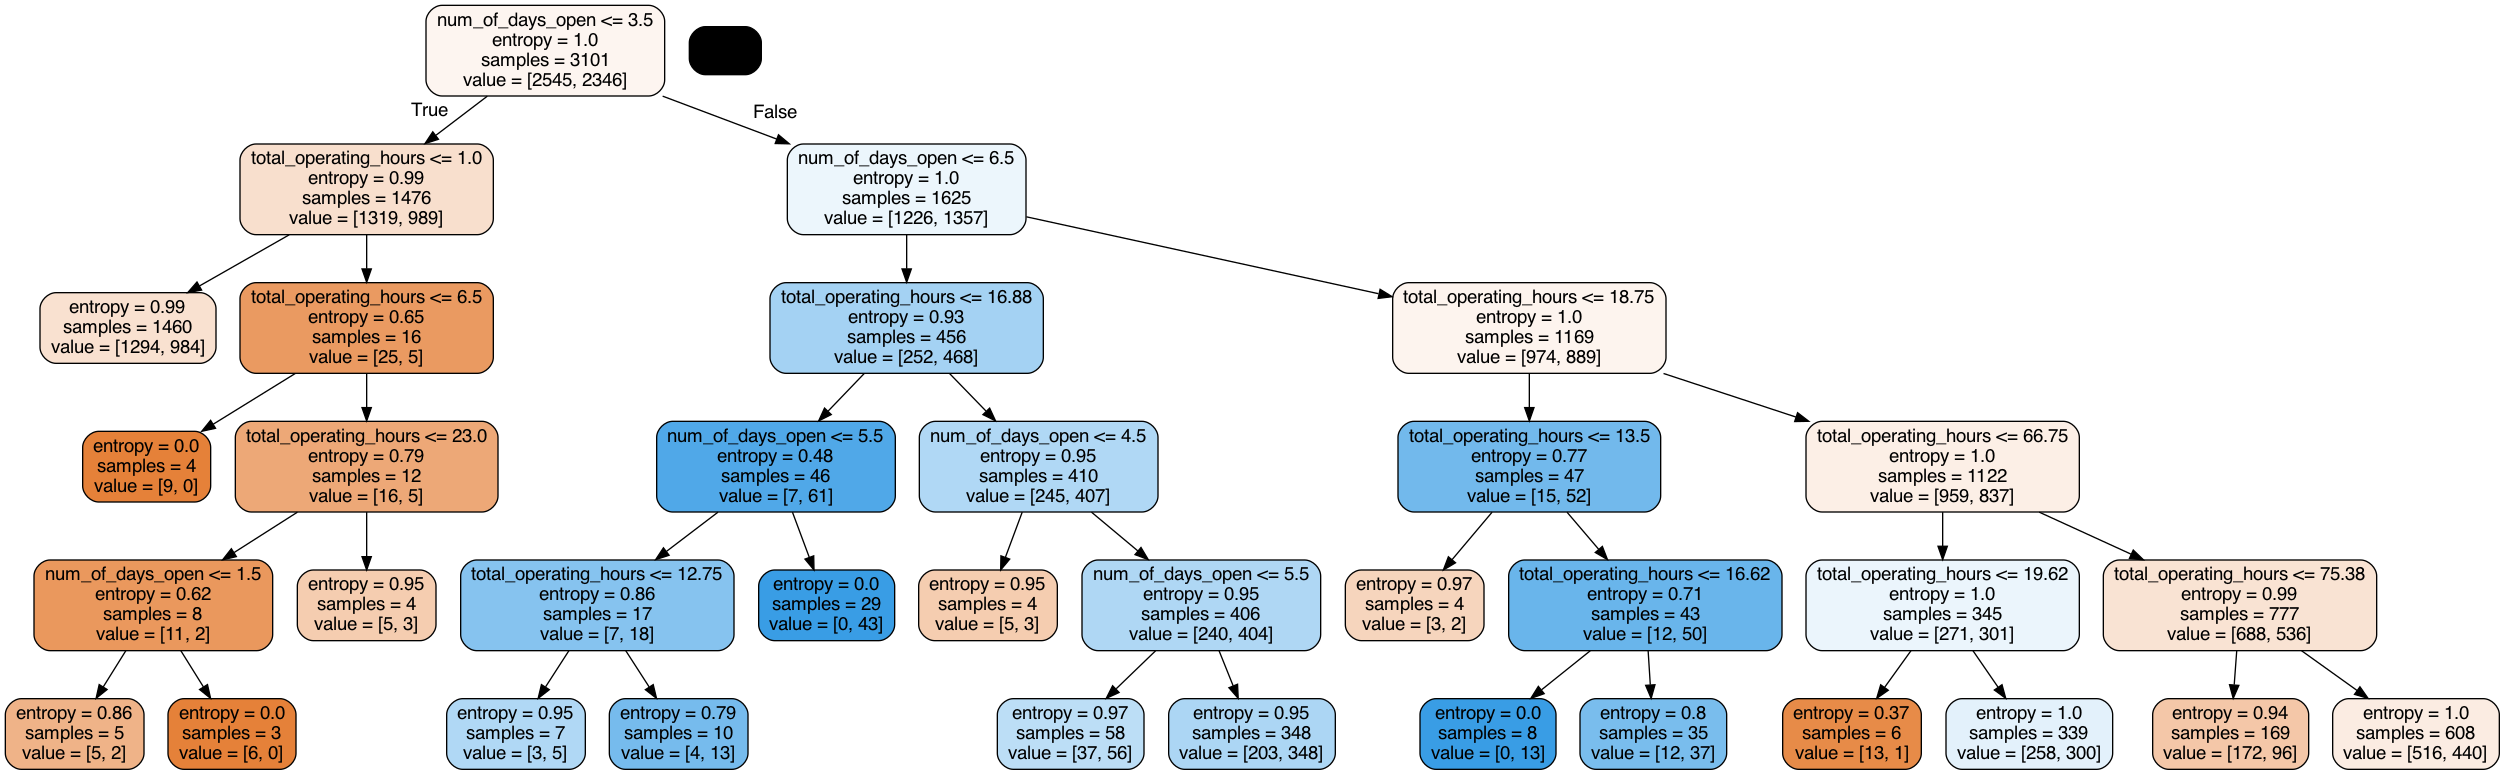

In [ ]:
# Write the decision tree as a dot file
visual_tree = rf_sub_4.estimators_[0]
export_graphviz(visual_tree, out_file = 'image/random_forest_sub_4.dot', feature_names = X_sub_4.columns, 
                precision = 2, filled = True, rounded = True, max_depth = None)

# Import the dot file to a graph and then convert to a png
(graph, ) = pydot.graph_from_dot_file('image/random_forest_sub_4.dot')

# MacOs need to brew install gprof2dot
graph.write_png('image/random_forest_sub_4.png')

Image('image/random_forest_sub_4.png') 

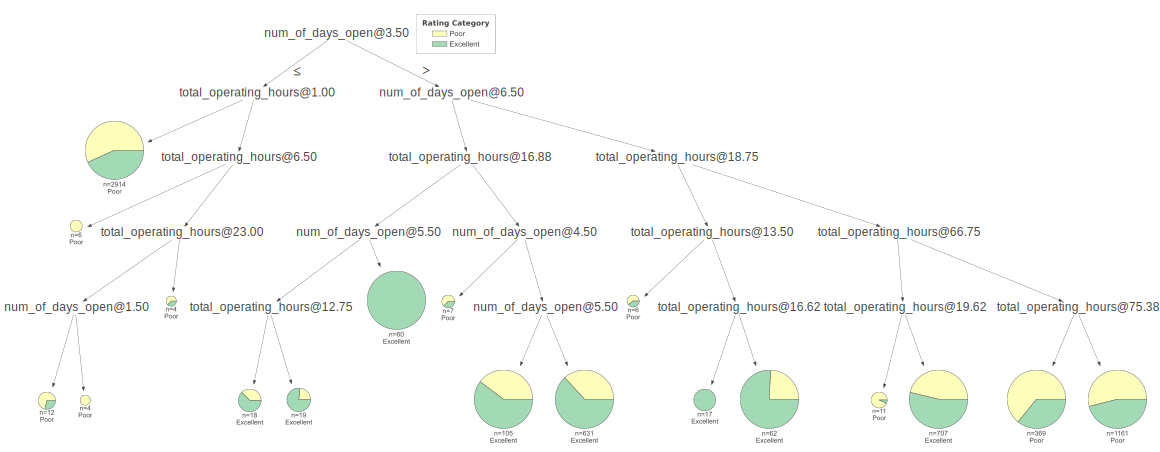

In [ ]:
viz_4 = dtreeviz(
    rf_sub_4.estimators_[0], 
    X_sub_4, y['average_rating_category'],
    target_name="Rating Category",
    feature_names=X_sub_4.columns,
    class_names=["Poor", "Excellent"],
    fancy=False,
)

viz_4

In [ ]:
X_sub_5 = X[["feature_reservations", "has_features", "feature_seating", "diet_gluten_free_options"]].copy()

rf_sub_5 = RandomForestClassifier(
    n_estimators=2500,           
    max_depth=5,
    max_features="auto",      
    min_samples_leaf=3,       
    criterion="entropy",  
    bootstrap=True,
    oob_score=True,
    random_state=2022,
    n_jobs=-1
)

roc_auc_train_sub_5, roc_auc_test_sub_5 = stratified_k_fold_model_fit(X_sub_5, y, rf_sub_5, 5, shuffle=True, plot_confusion_matrix=False, plot_roc=False, hide_fold_result=True)

-------------------- Overall Train Result--------------------
Confusion Matrix:
[[12688   176]
 [10660   928]]
TN: 12688, FP: 176, FN: 10660, TP: 928
Accuracy: 0.55685
Recall: 0.08008
Precision: 0.84058
F1: 0.14623
ROC_AUC: 0.53320
-------------------- Overall Test Result--------------------
Confusion Matrix:
[[3172   44]
 [2665  232]]
TN: 3172, FP: 44, FN: 2665, TP: 232
Accuracy: 0.55685
Recall: 0.08008
Precision: 0.84058
F1: 0.14623
ROC_AUC: 0.53320


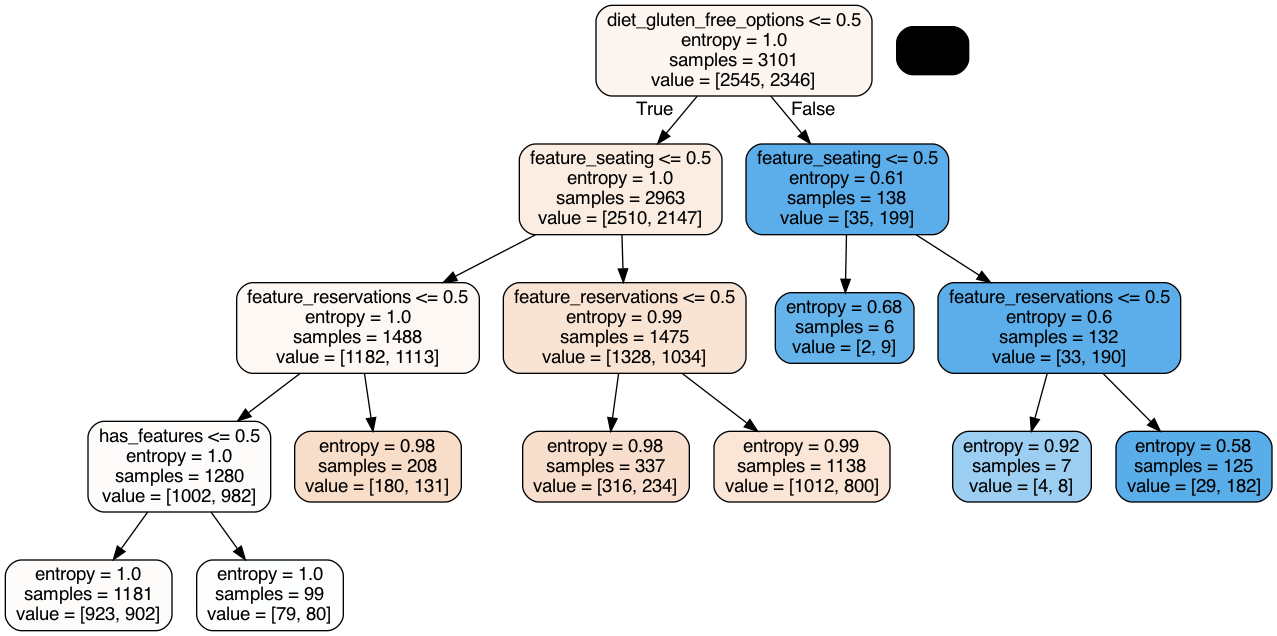

In [ ]:
# Write the decision tree as a dot file
visual_tree = rf_sub_5.estimators_[0]
export_graphviz(visual_tree, out_file = 'image/random_forest_sub_5.dot', feature_names = X_sub_5.columns, 
                precision = 2, filled = True, rounded = True, max_depth = None)

# Import the dot file to a graph and then convert to a png
(graph, ) = pydot.graph_from_dot_file('image/random_forest_sub_5.dot')

# MacOs need to brew install gprof2dot
graph.write_png('image/random_forest_sub_5.png')

Image('image/random_forest_sub_5.png')

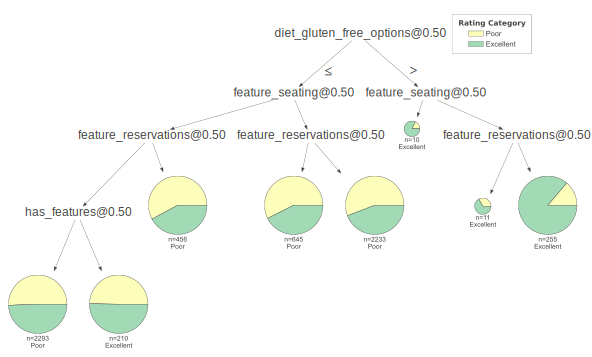

In [ ]:
viz_5 = dtreeviz(
    rf_sub_5.estimators_[0], 
    X_sub_5, y['average_rating_category'],
    target_name="Rating Category",
    feature_names=X_sub_5.columns,
    class_names=["Poor", "Excellent"],
    fancy=False,
)

viz_5